In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import RidgeCV, LassoCV

 
 answeres for the assignement here and as well as in a pdf.

In [2]:
data = pd.read_csv("../house prediction/train.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
missing_values_count = data.isnull().sum()

# Filter out columns with no missing values to focus on those that do
missing_values_count = missing_values_count[missing_values_count > 0]

# Display the count of missing values for each column
missing_values_count


LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [5]:
threshold = 0.5 * len(data)
data_cleaned = data.drop(columns=data.columns[data.isnull().sum() > threshold])

In [6]:
# Impute the remaining missing values for numerical columns
numerical_cols = data_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_imputer = SimpleImputer(strategy='median')
data_cleaned[numerical_cols] = numerical_imputer.fit_transform(data_cleaned[numerical_cols])

# Impute the remaining missing values for categorical columns
categorical_cols = data_cleaned.select_dtypes(include=['object']).columns.tolist()
categorical_imputer = SimpleImputer(strategy='most_frequent')
data_cleaned[categorical_cols] = categorical_imputer.fit_transform(data_cleaned[categorical_cols])


In [7]:
corr_matrix = data_cleaned.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.7)]
if 'SalePrice' in to_drop:
    to_drop.remove('SalePrice')
data_cleaned.drop(columns=to_drop, inplace=True)


/var/folders/0q/clpdbrcs35q427c4ncjr3ttc0000gn/T/ipykernel_21757/348292754.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data_cleaned.corr().abs()


In [8]:
to_drop

['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea']

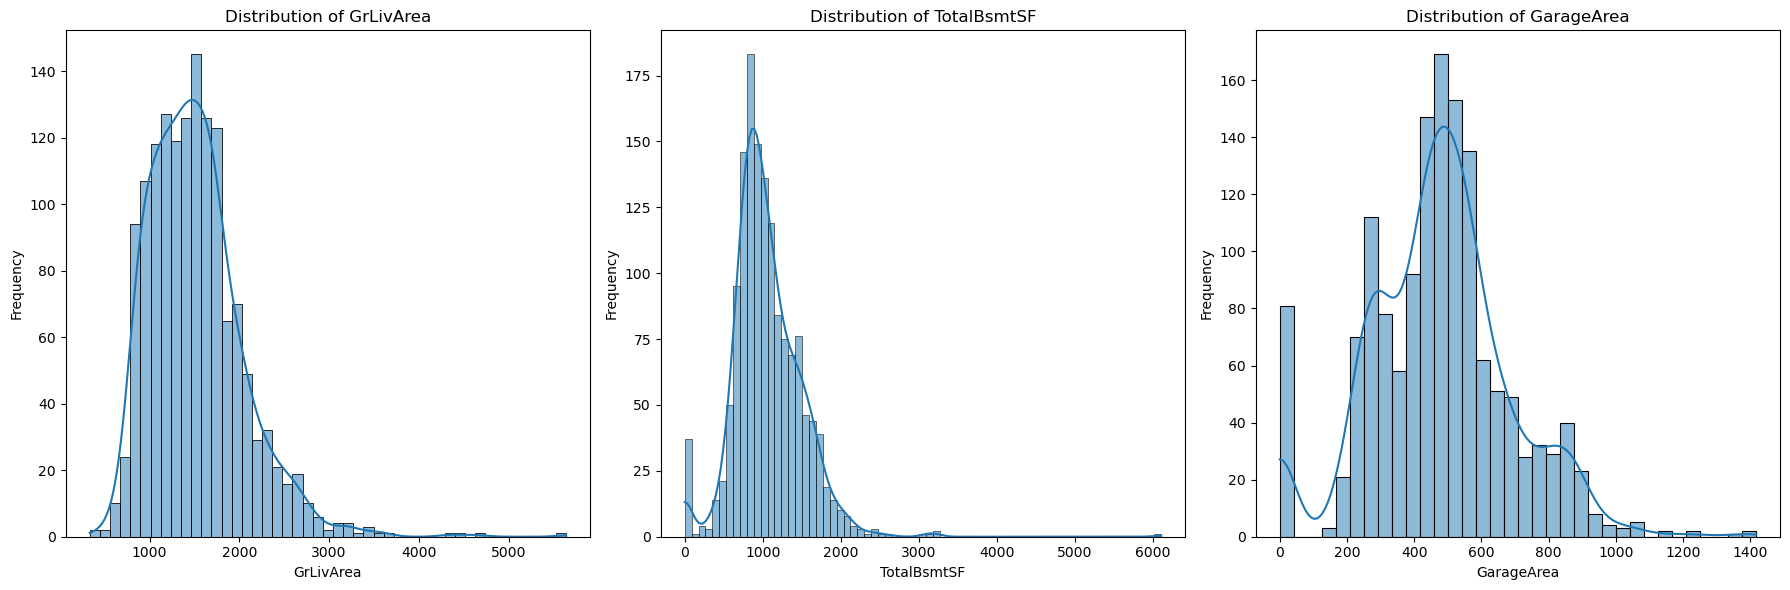

In [9]:
selected_numerical_features = ['GrLivArea', 'TotalBsmtSF', 'GarageArea']
fig, axs = plt.subplots(nrows=1, ncols=len(selected_numerical_features), figsize=(18, 6))

for i, feature in enumerate(selected_numerical_features):
    sns.histplot(data[feature], kde=True, ax=axs[i])
    axs[i].set_title(f'Distribution of {feature}')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

. Distribution and Outlier Analysis The histograms for selected numerical features would show their distribution, highlighting any skewness. For example, GrLivArea might show a right-skewed distribution, indicating that most houses have a moderate living area size, but a few have much larger areas.

In [10]:
def cap_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Capping
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

# Identify numerical columns to check for outliers, excluding 'SalePrice'
numerical_columns = data_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_columns = [col for col in numerical_columns if col != 'SalePrice']

# Apply capping to outliers
data_cleaned = cap_outliers(data_cleaned, numerical_columns)

In [11]:
corr_with_saleprice = data_cleaned.corr()['SalePrice'].sort_values(ascending=False)

# Plot the correlations with 'SalePrice'
plt.figure(figsize=(10, 12))
sns.barplot(x=corr_with_saleprice.values, y=corr_with_saleprice.index)
plt.title('Correlation with SalePrice')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

/var/folders/0q/clpdbrcs35q427c4ncjr3ttc0000gn/T/ipykernel_21757/3992117779.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_with_saleprice = data_cleaned.corr()['SalePrice'].sort_values(ascending=False)


In [12]:
# Separate features and target
X = data_cleaned.drop('SalePrice', axis=1)
y = data_cleaned['SalePrice']

In [13]:
X

Id  MSSubClass MSZoning  LotFrontage  LotArea Street LotShape  \
0        1.0        60.0       RL         65.0   8450.0   Pave      Reg   
1        2.0        20.0       RL         80.0   9600.0   Pave      Reg   
2        3.0        60.0       RL         68.0  11250.0   Pave      IR1   
3        4.0        70.0       RL         60.0   9550.0   Pave      IR1   
4        5.0        60.0       RL         84.0  14260.0   Pave      IR1   
...      ...         ...      ...          ...      ...    ...      ...   
1455  1456.0        60.0       RL         62.0   7917.0   Pave      Reg   
1456  1457.0        20.0       RL         85.0  13175.0   Pave      Reg   
1457  1458.0        70.0       RL         66.0   9042.0   Pave      Reg   
1458  1459.0        20.0       RL         68.0   9717.0   Pave      Reg   
1459  1460.0        20.0       RL         75.0   9937.0   Pave      Reg   

     LandContour Utilities LotConfig  ... OpenPorchSF EnclosedPorch 3SsnPorch  \
0            Lvl    AllPub    Inside  ...        61.0           0.0       0.0   
1            Lvl    AllPub       FR2  ...         0.0           0.0       0.0   
2            Lvl    AllPub    Inside  ...        42.0           0.0       0.0   
3            Lvl    AllPub    Corner  ...        35.0           0.0       0.0   
4            Lvl    AllPub       FR2  ...        84.0           0.0       0.0   
...          ...       ...       ...  ...         ...           ...       ...   
1455         Lvl    AllPub    Inside  ...        40.0           0.0       0.0   
1456         Lvl    AllPub    Inside  ...         0.0           0.0       0.0   
1457         Lvl    AllPub    Inside  ...        60.0           0.0       0.0   
1458         Lvl    AllPub    Inside  ...         0.0           0.0       0.0   
1459         Lvl    AllPub    Inside  ...        68.0           0.0       0.0   

     ScreenPorch PoolArea MiscVal  MoSold  YrSold  SaleType  SaleCondition  
0            0.0      0.0     0.0     2.0  2008.0        WD         Normal  
1            0.0      0.0     0.0     5.0  2007.0        WD         Normal  
2            0.0      0.0     0.0     9.0  2008.0        WD         Normal  
3            0.0      0.0     0.0     2.0  2006.0        WD        Abnorml  
4            0.0      0.0     0.0    12.0  2008.0        WD         Normal  
...          ...      ...     ...     ...     ...       ...            ...  
1455         0.0      0.0     0.0     8.0  2007.0        WD         Normal  
1456         0.0      0.0     0.0     2.0  2010.0        WD         Normal  
1457         0.0      0.0     0.0     5.0  2010.0        WD         Normal  
1458         0.0      0.0     0.0     4.0  2010.0        WD         Normal  
1459         0.0      0.0     0.0     6.0  2008.0        WD         Normal  

[1460 rows x 72 columns]

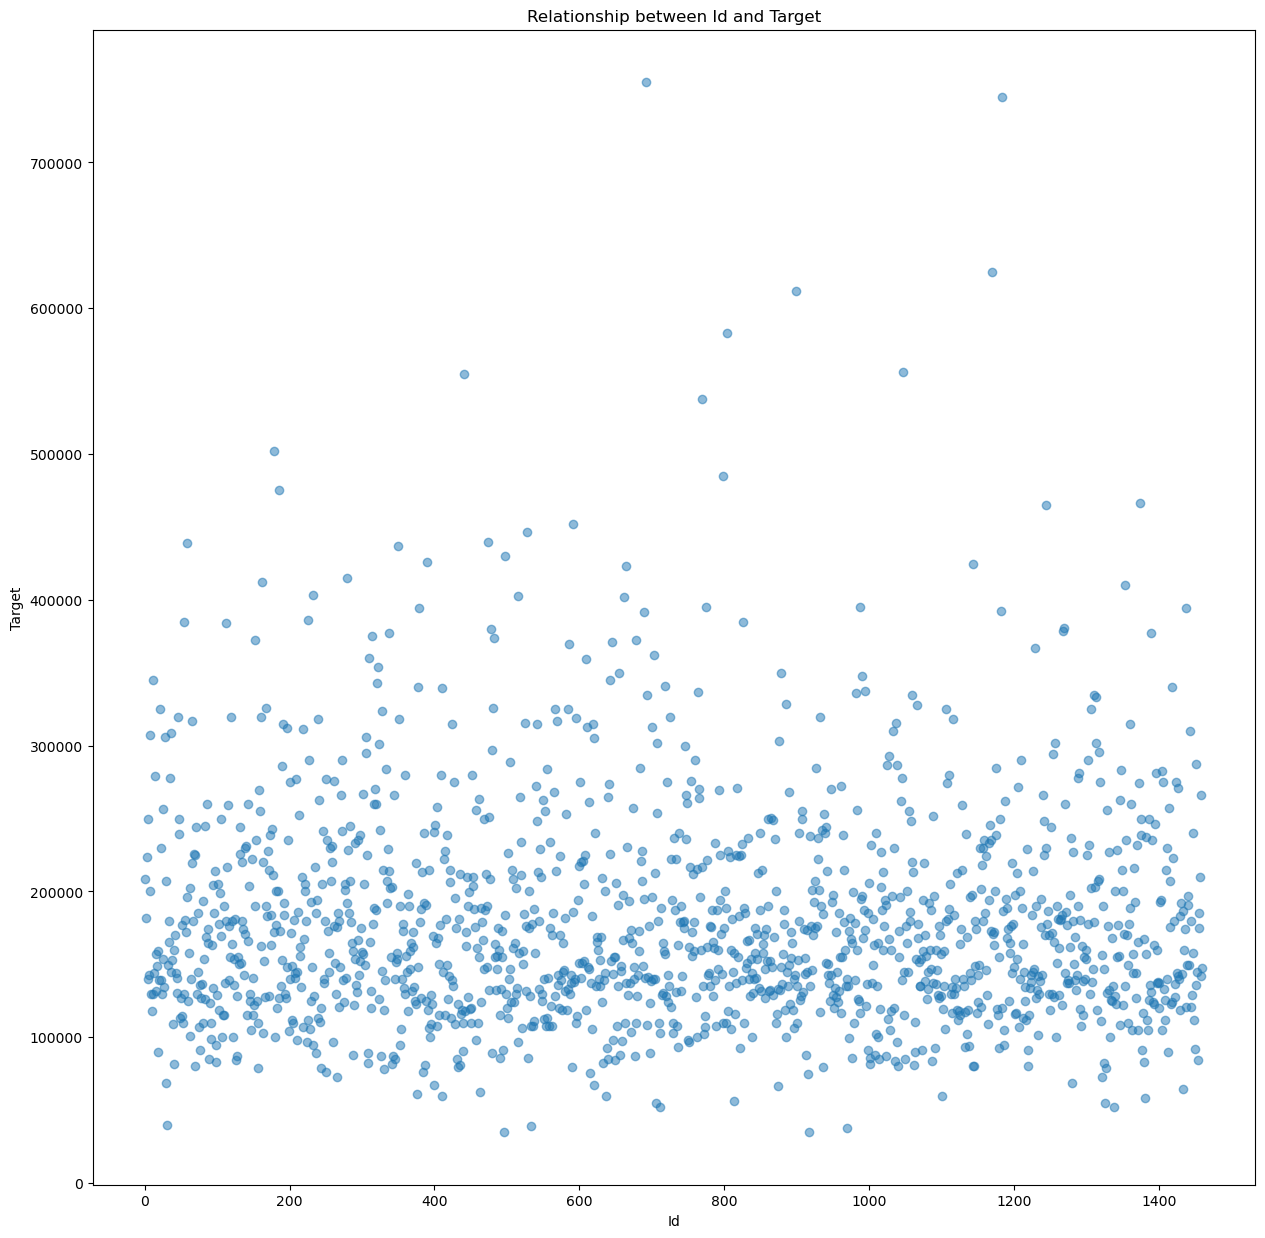

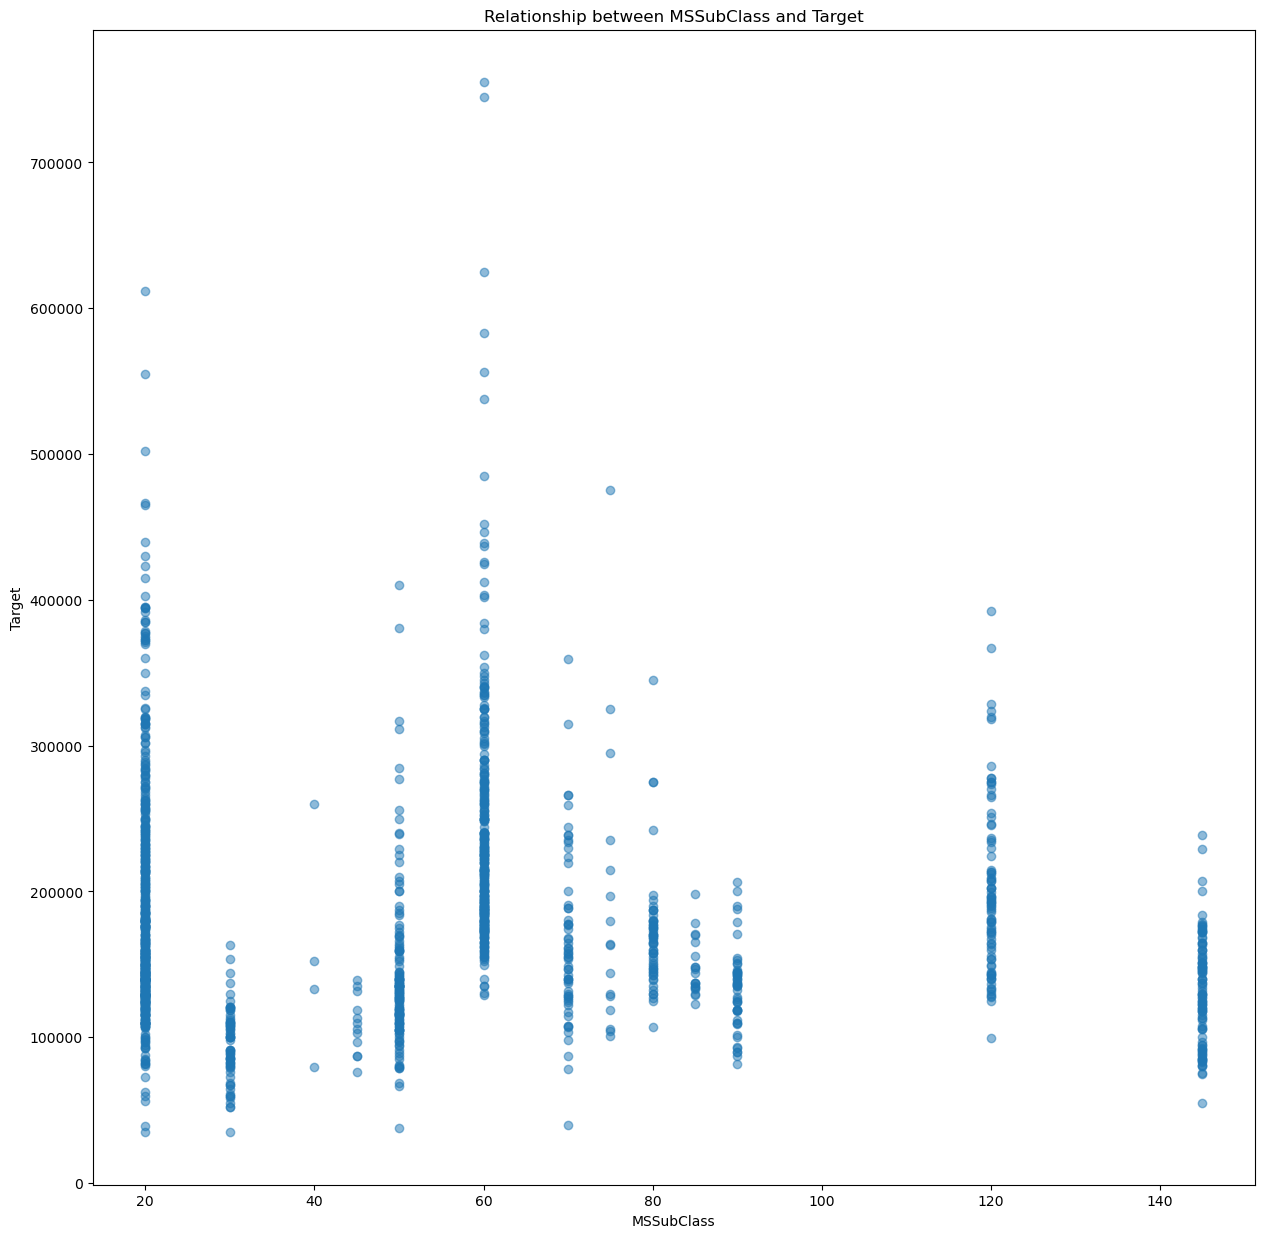

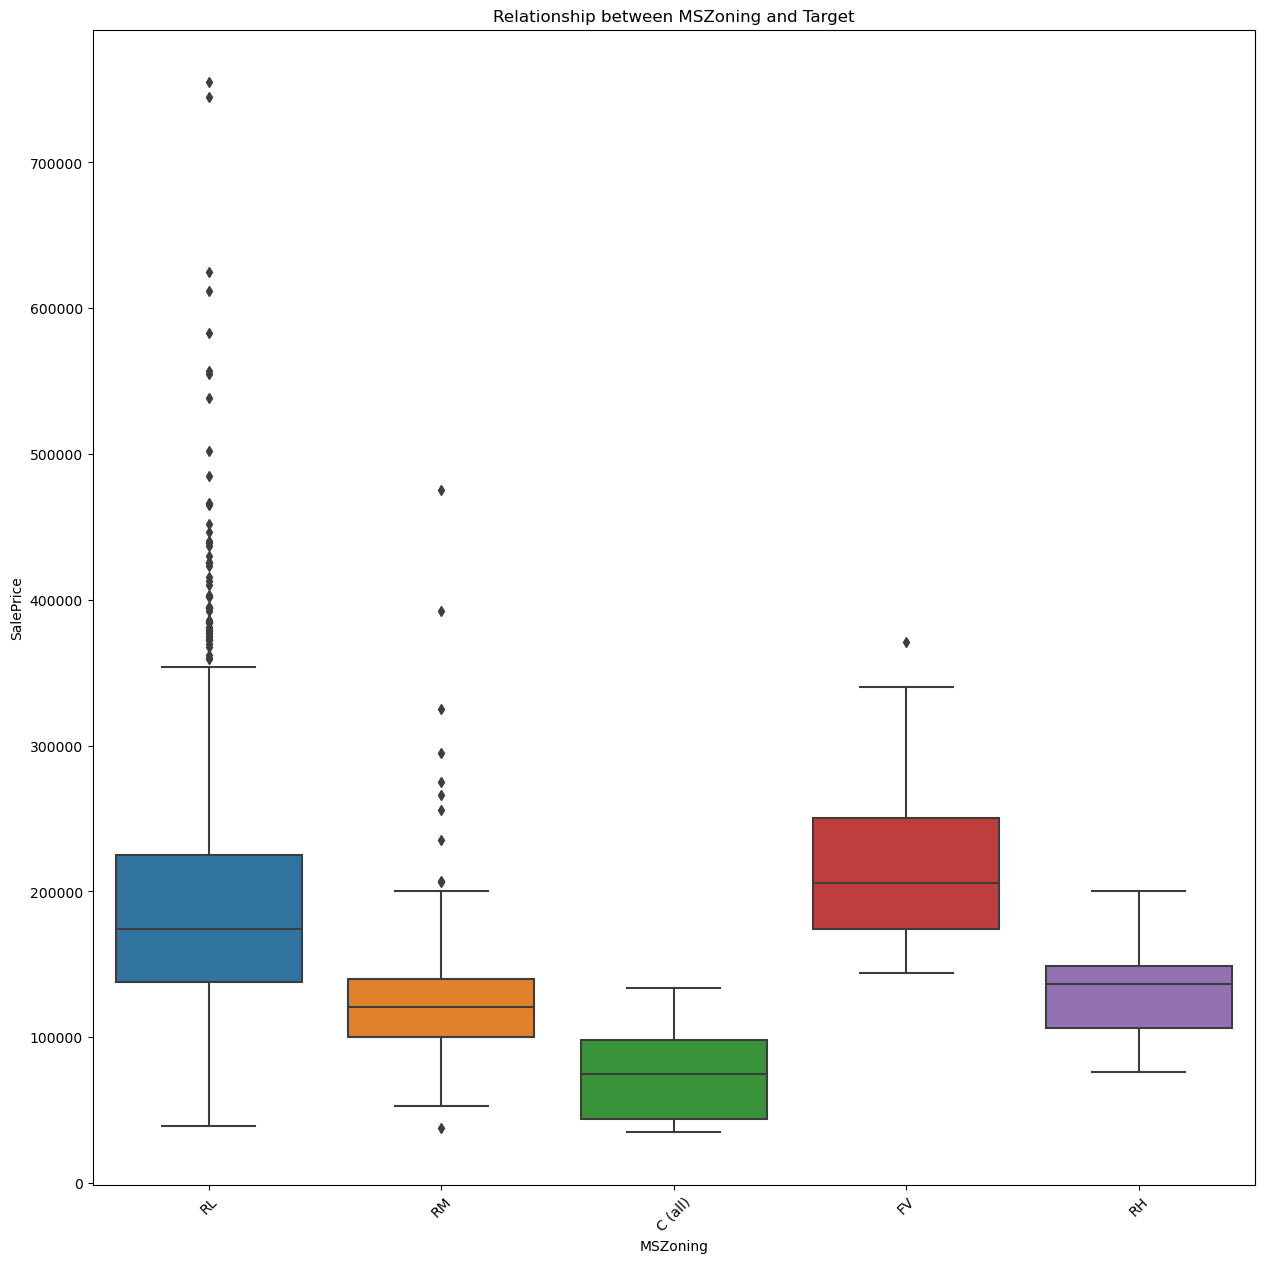

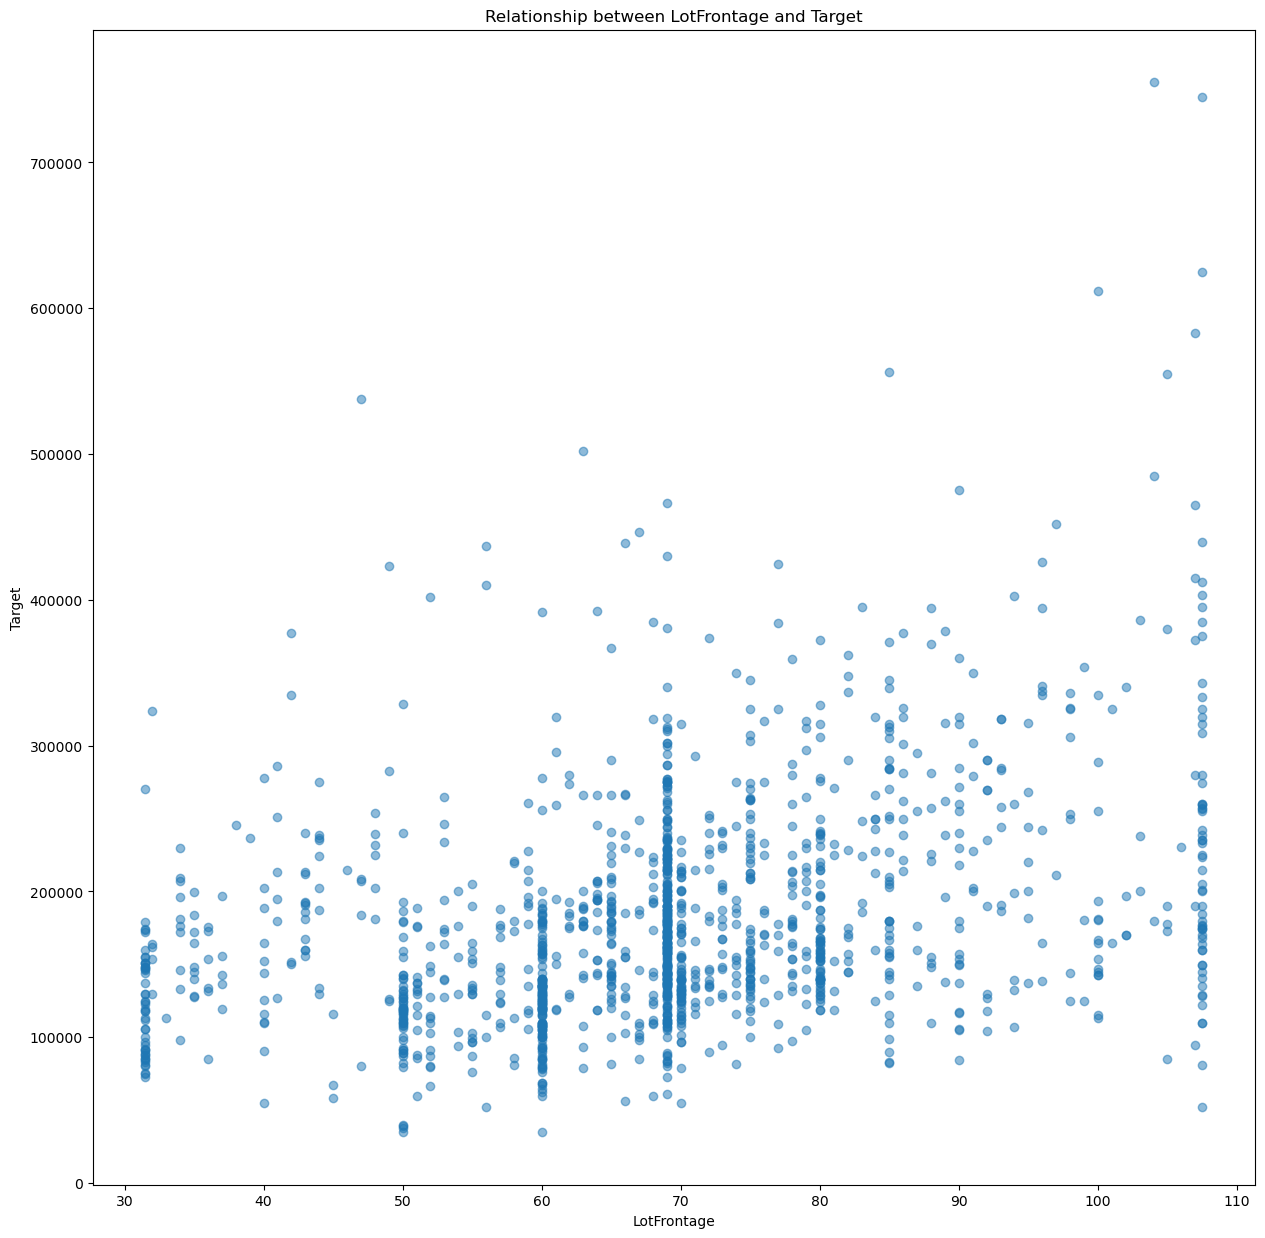

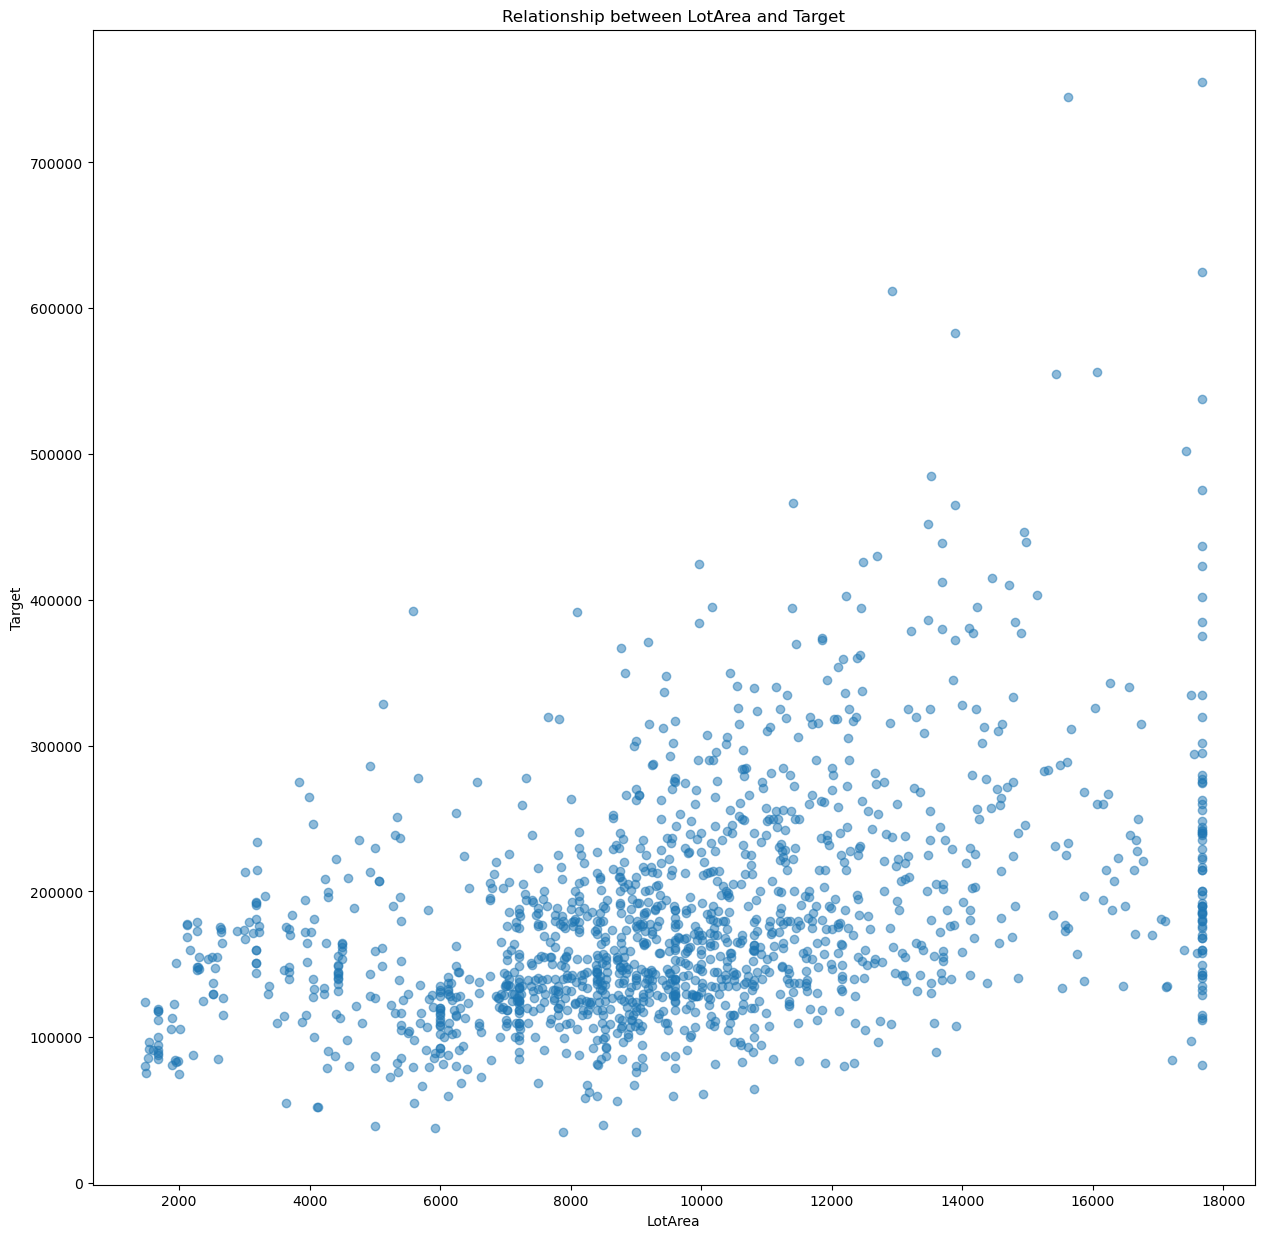

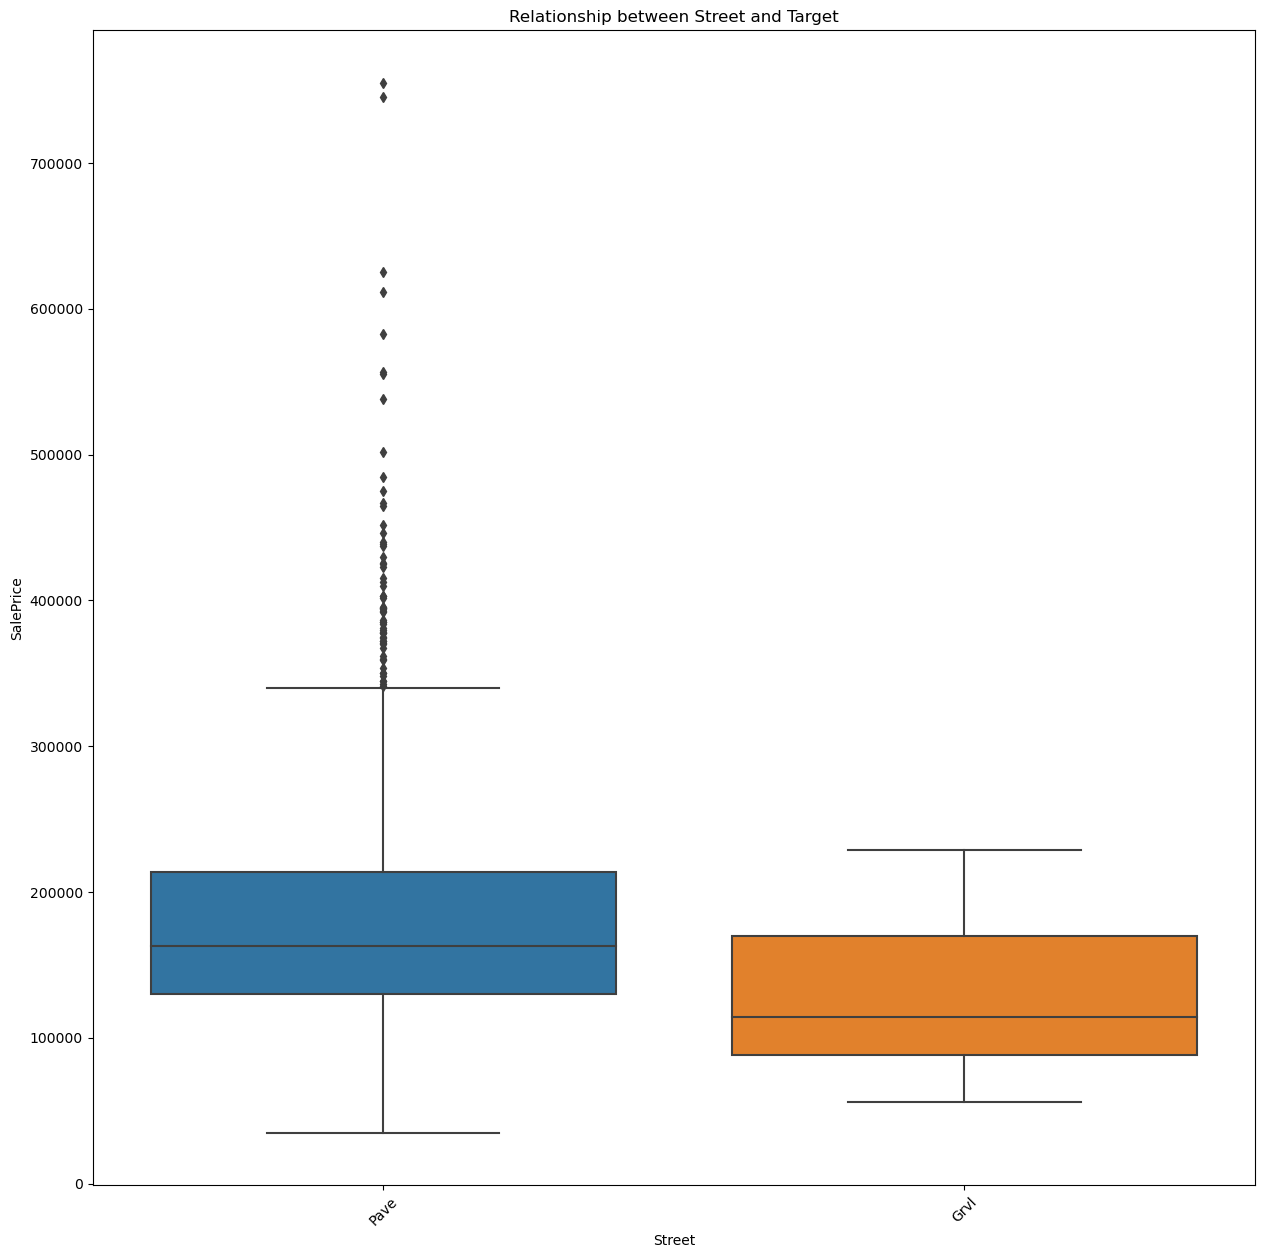

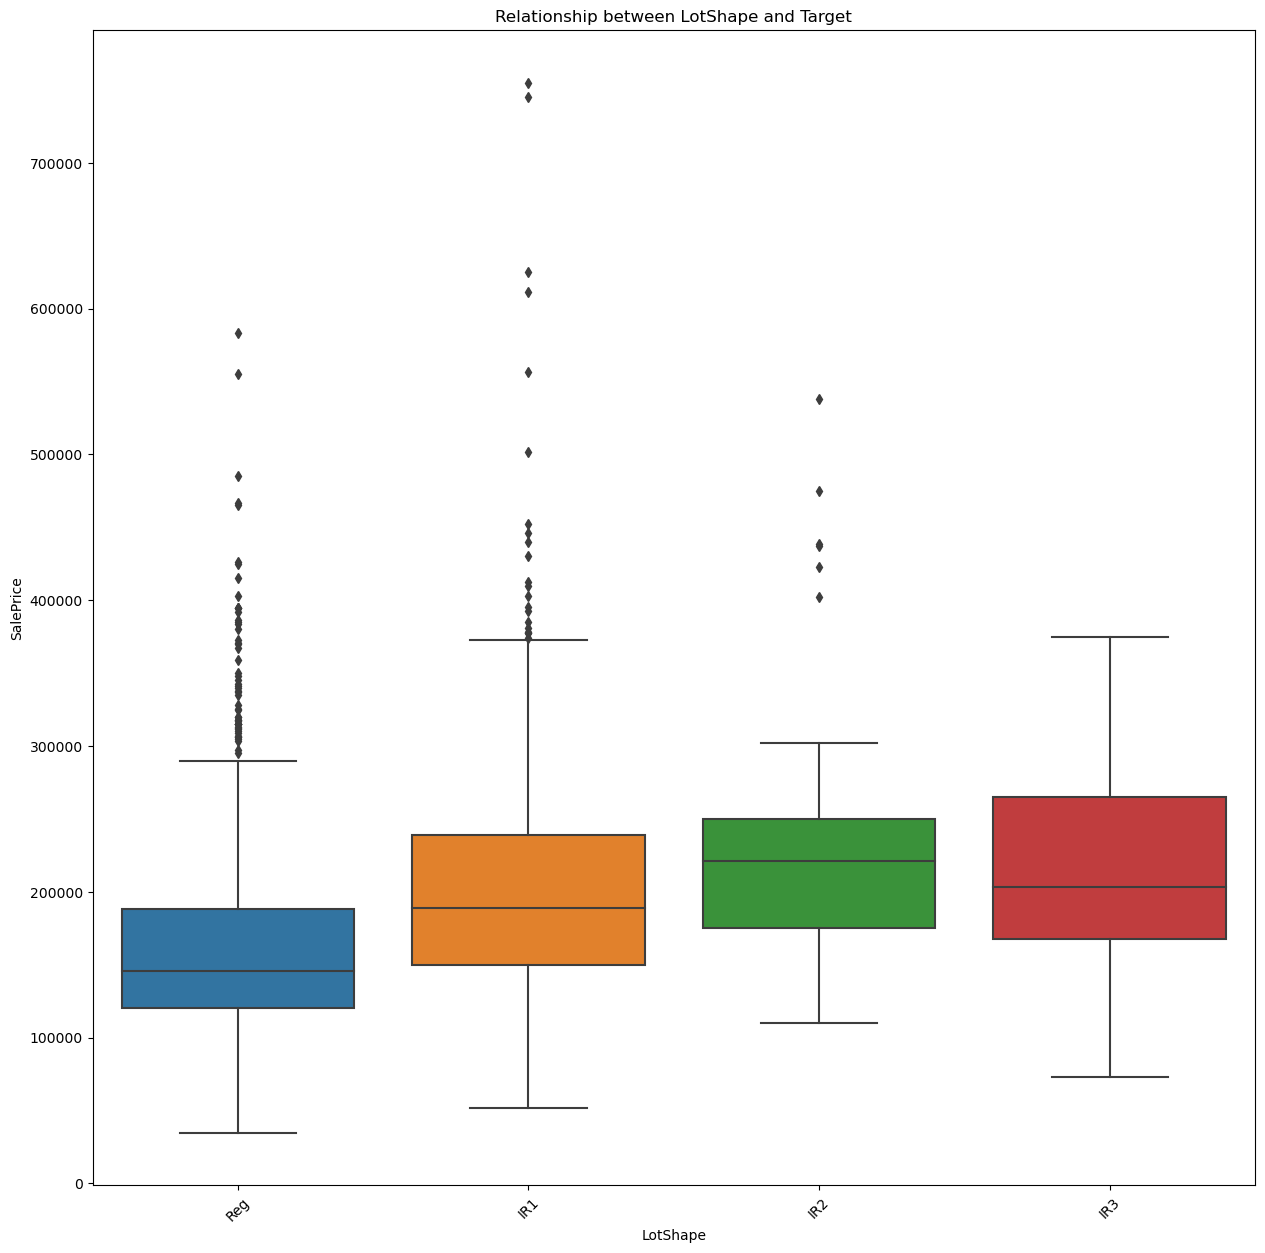

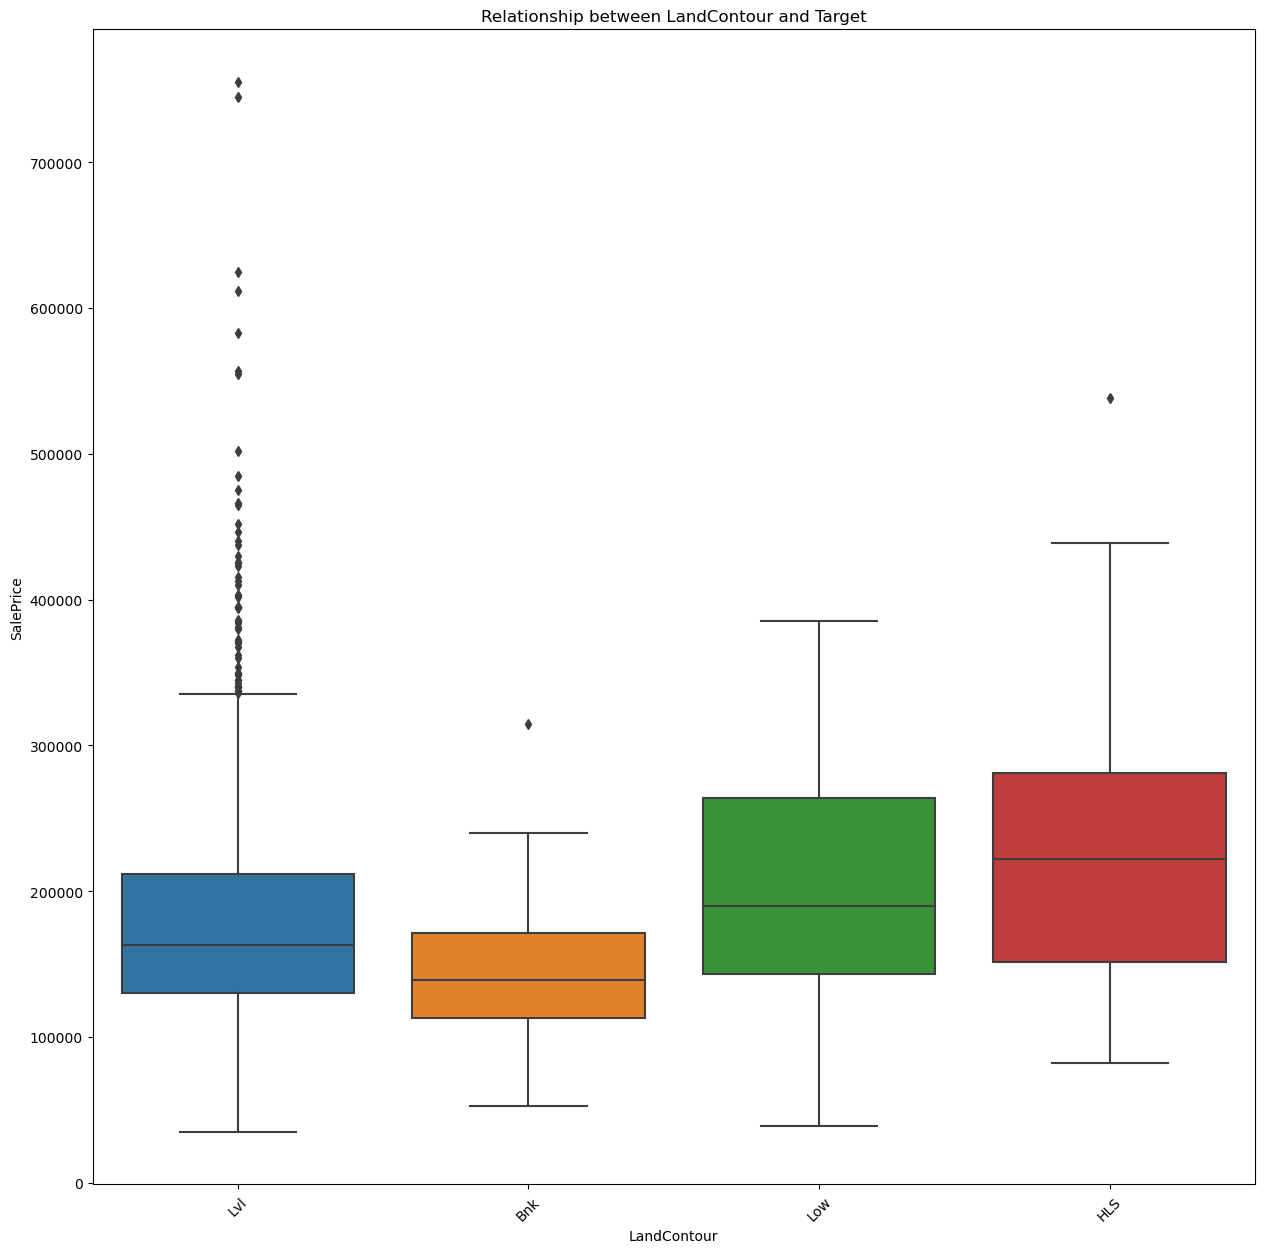

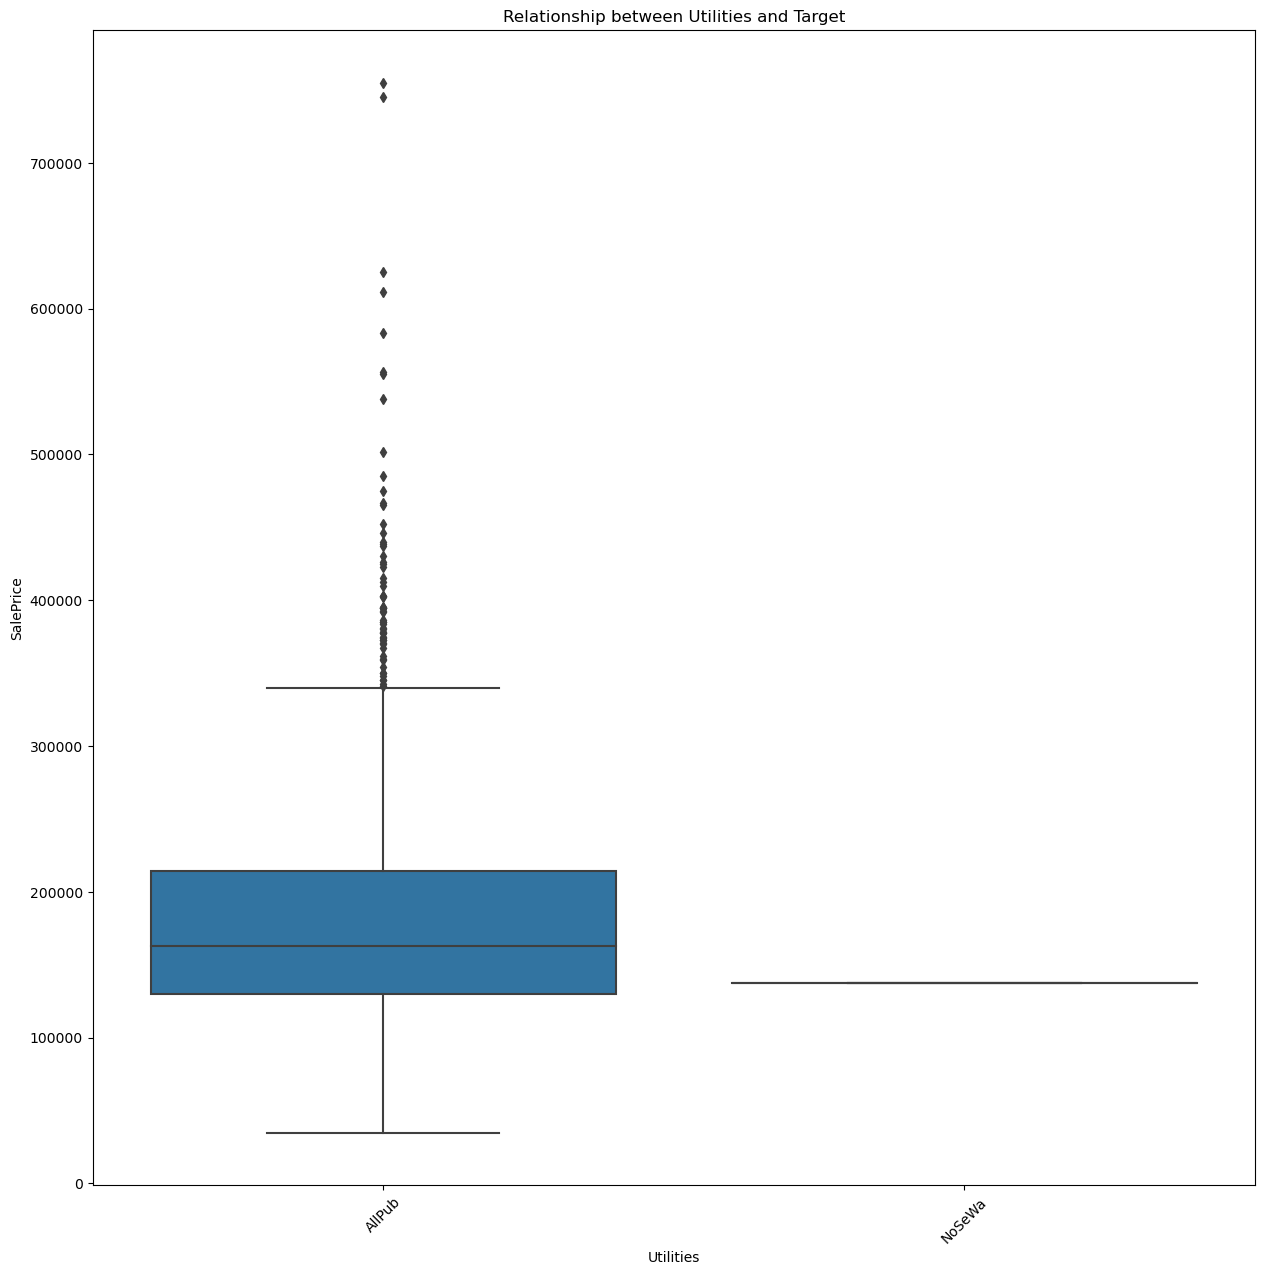

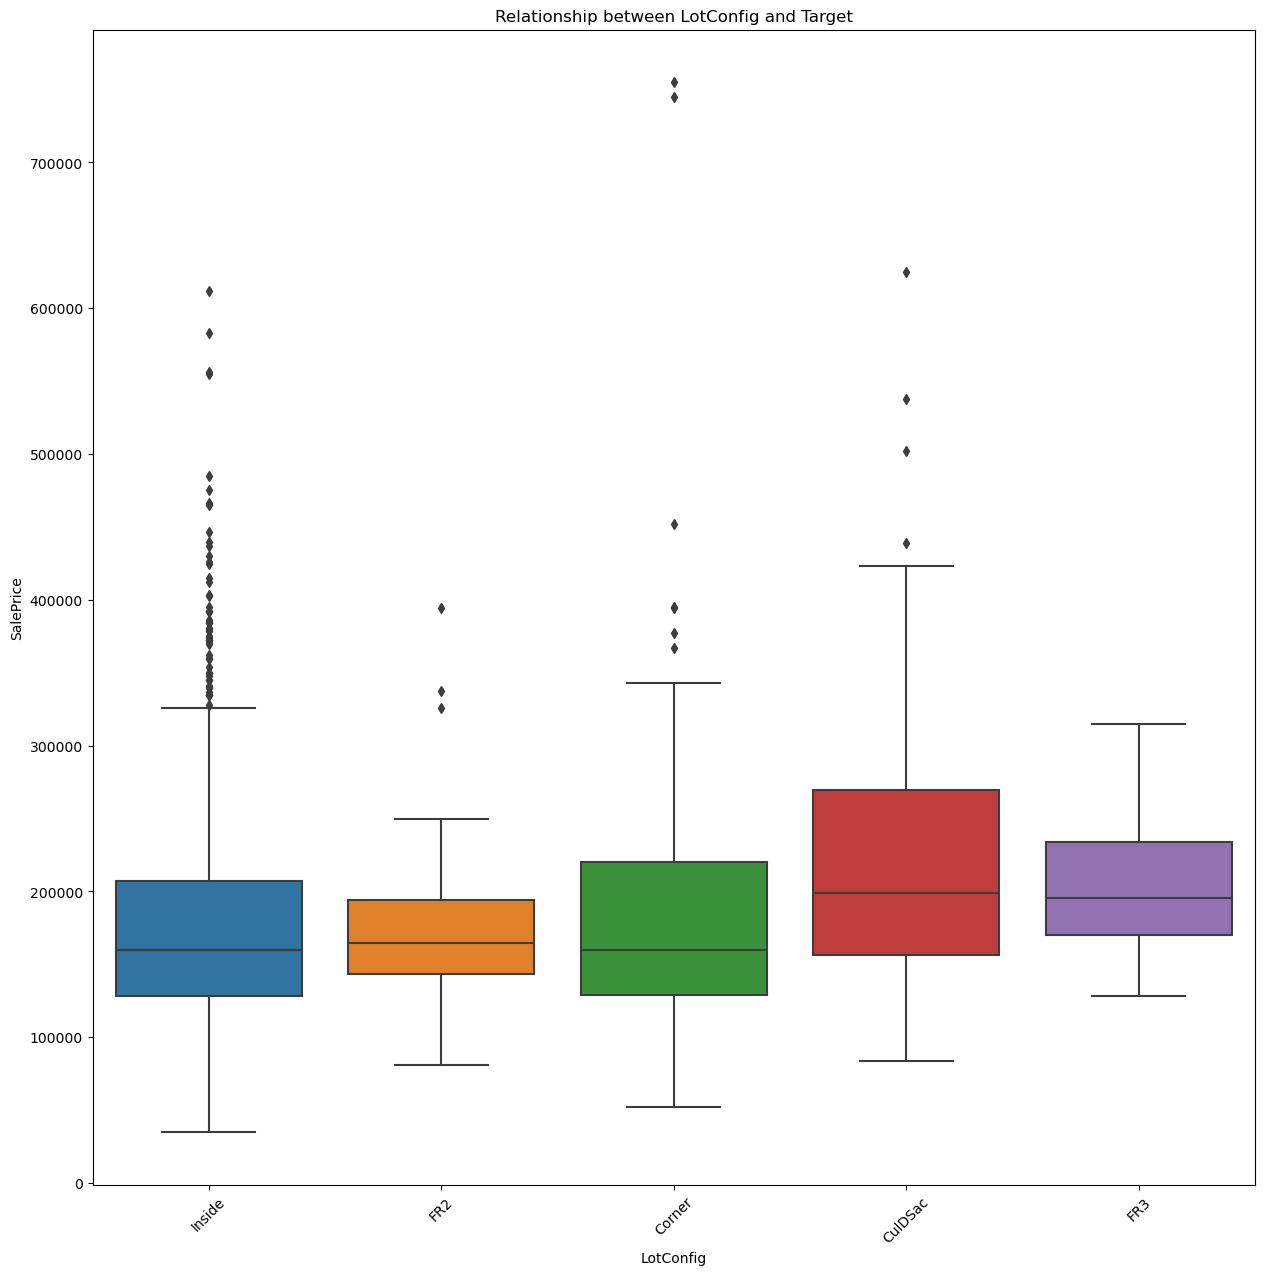

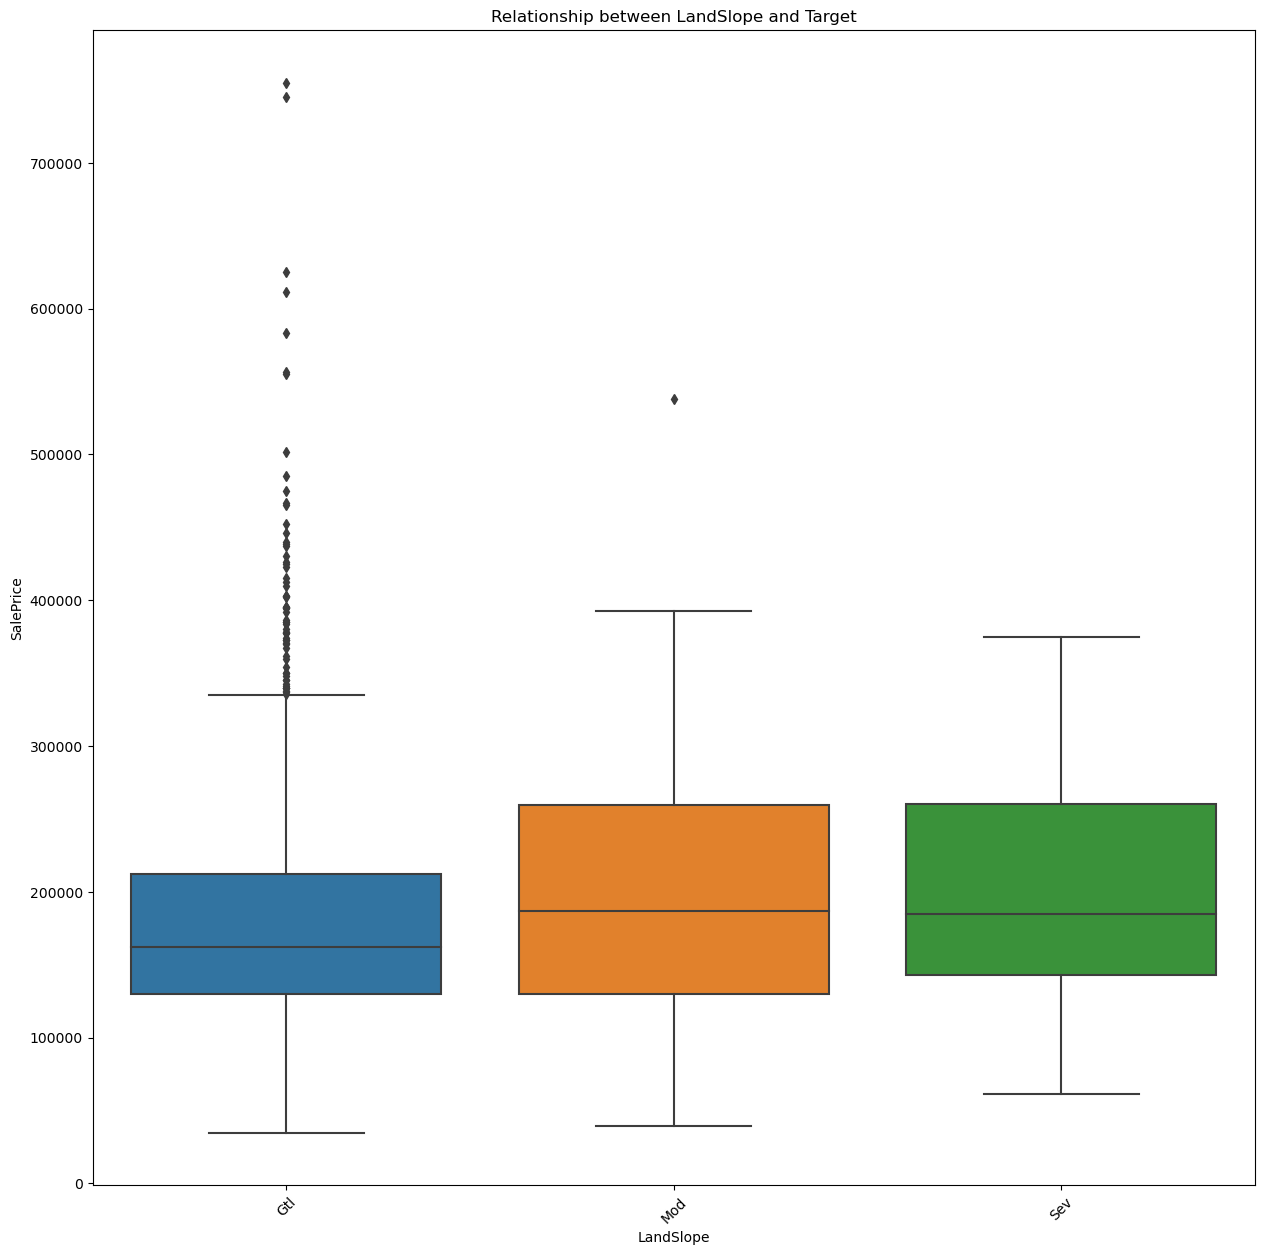

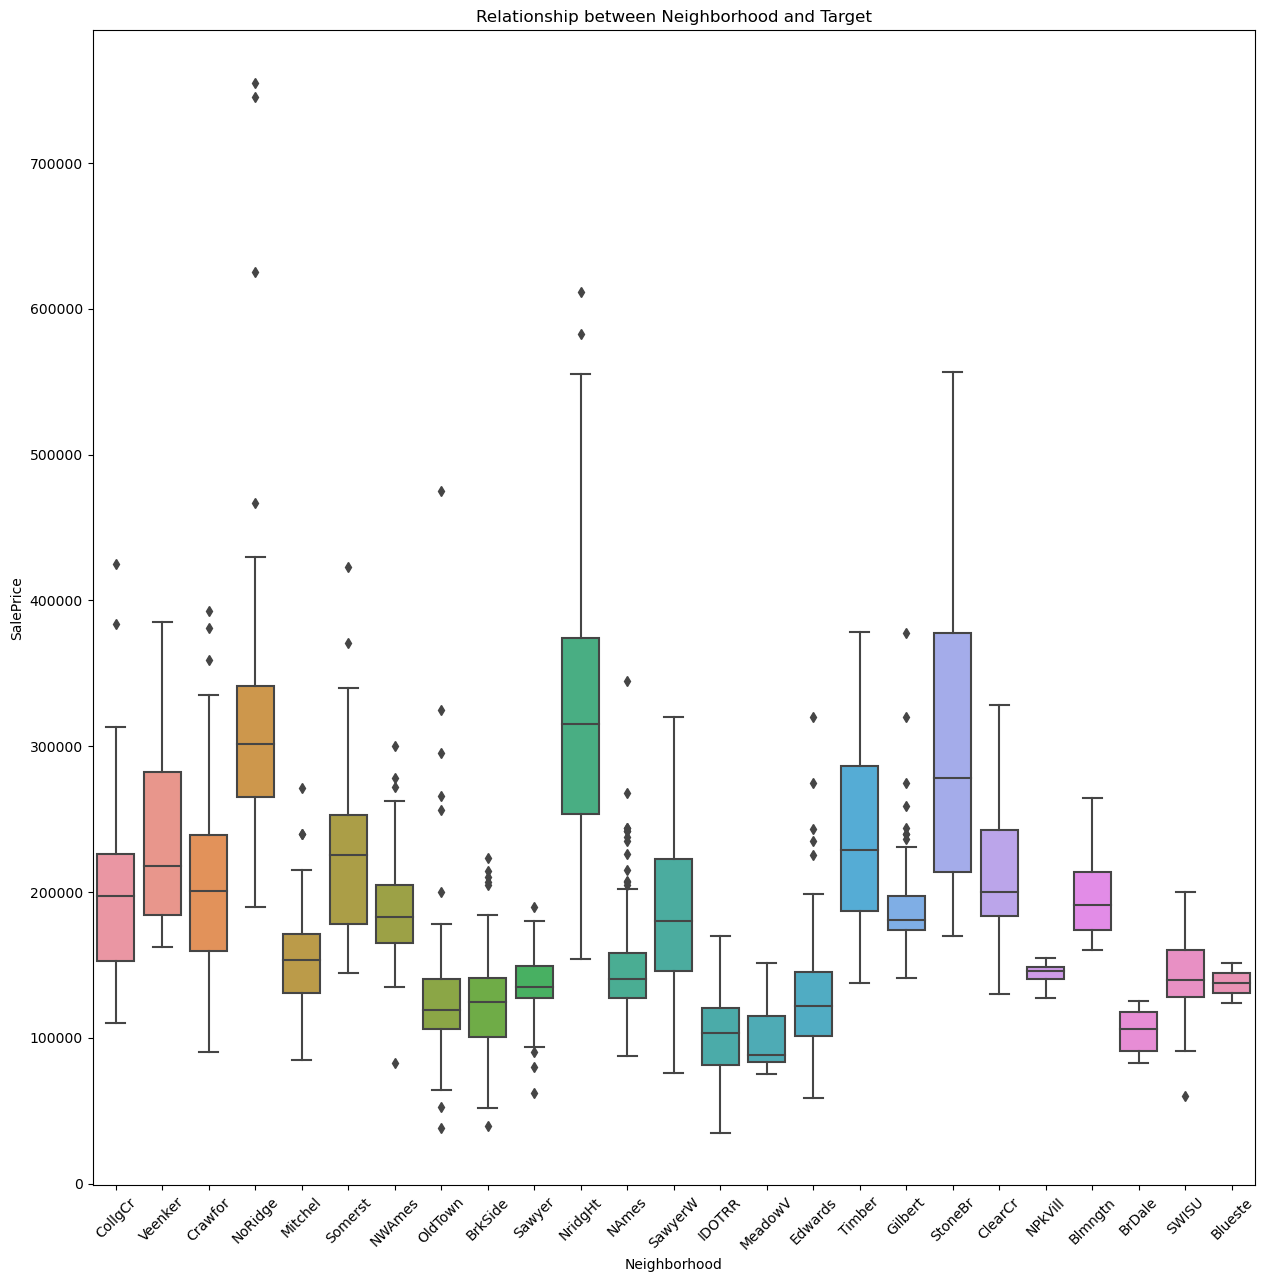

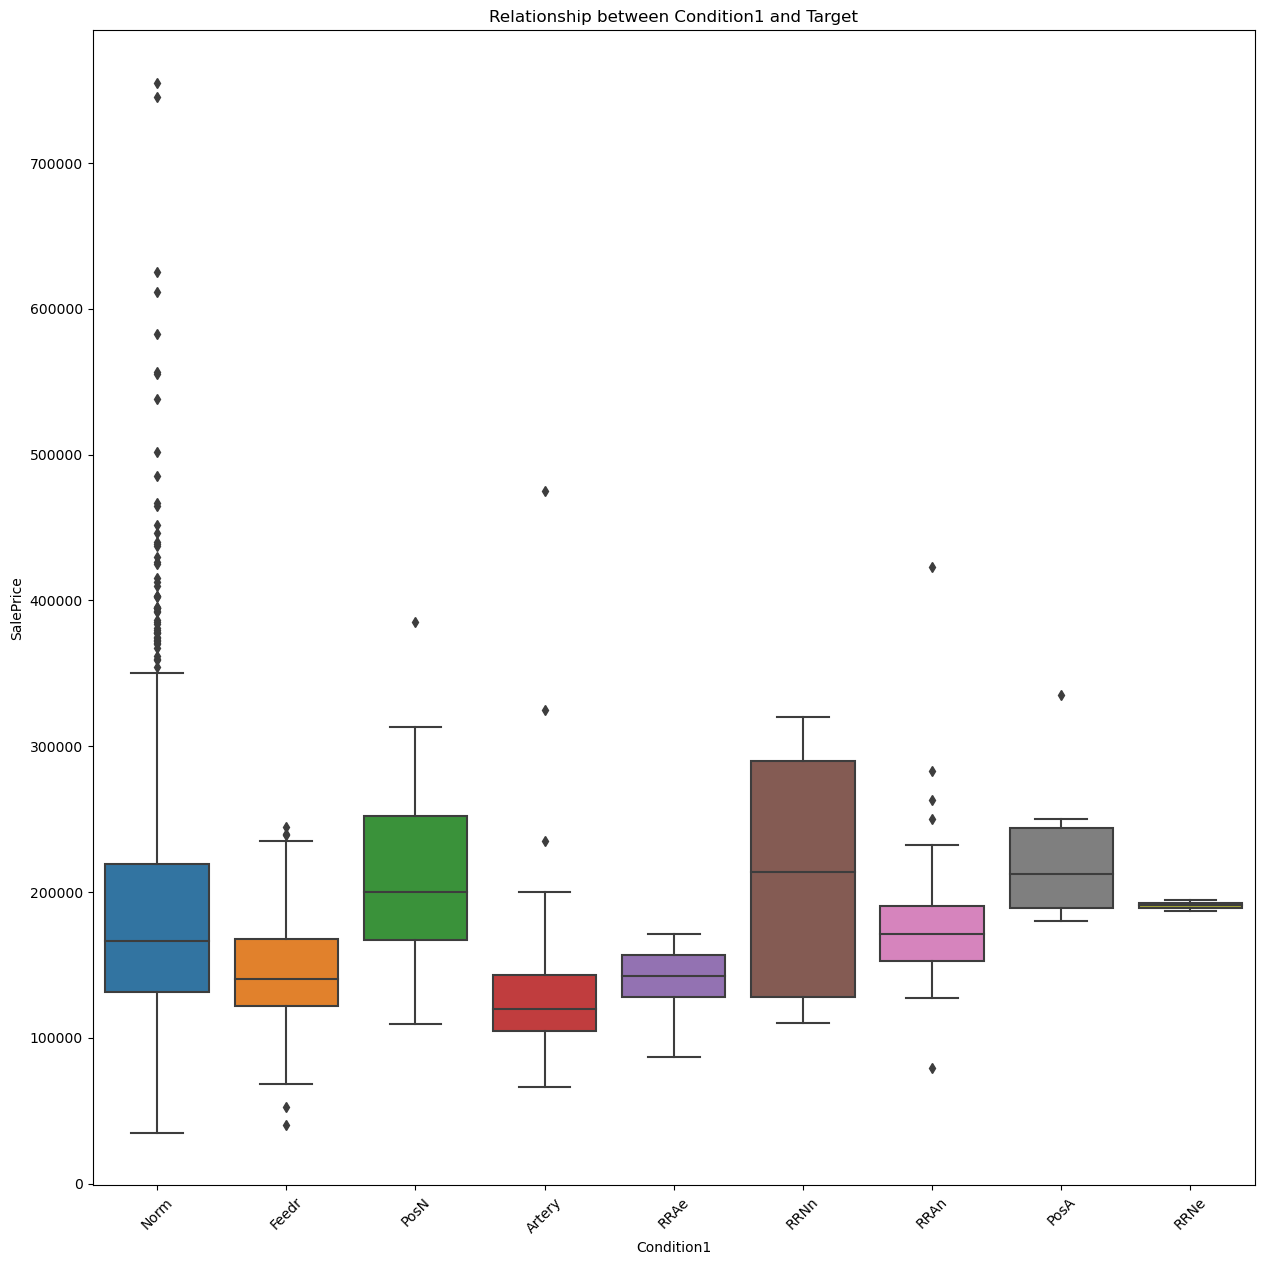

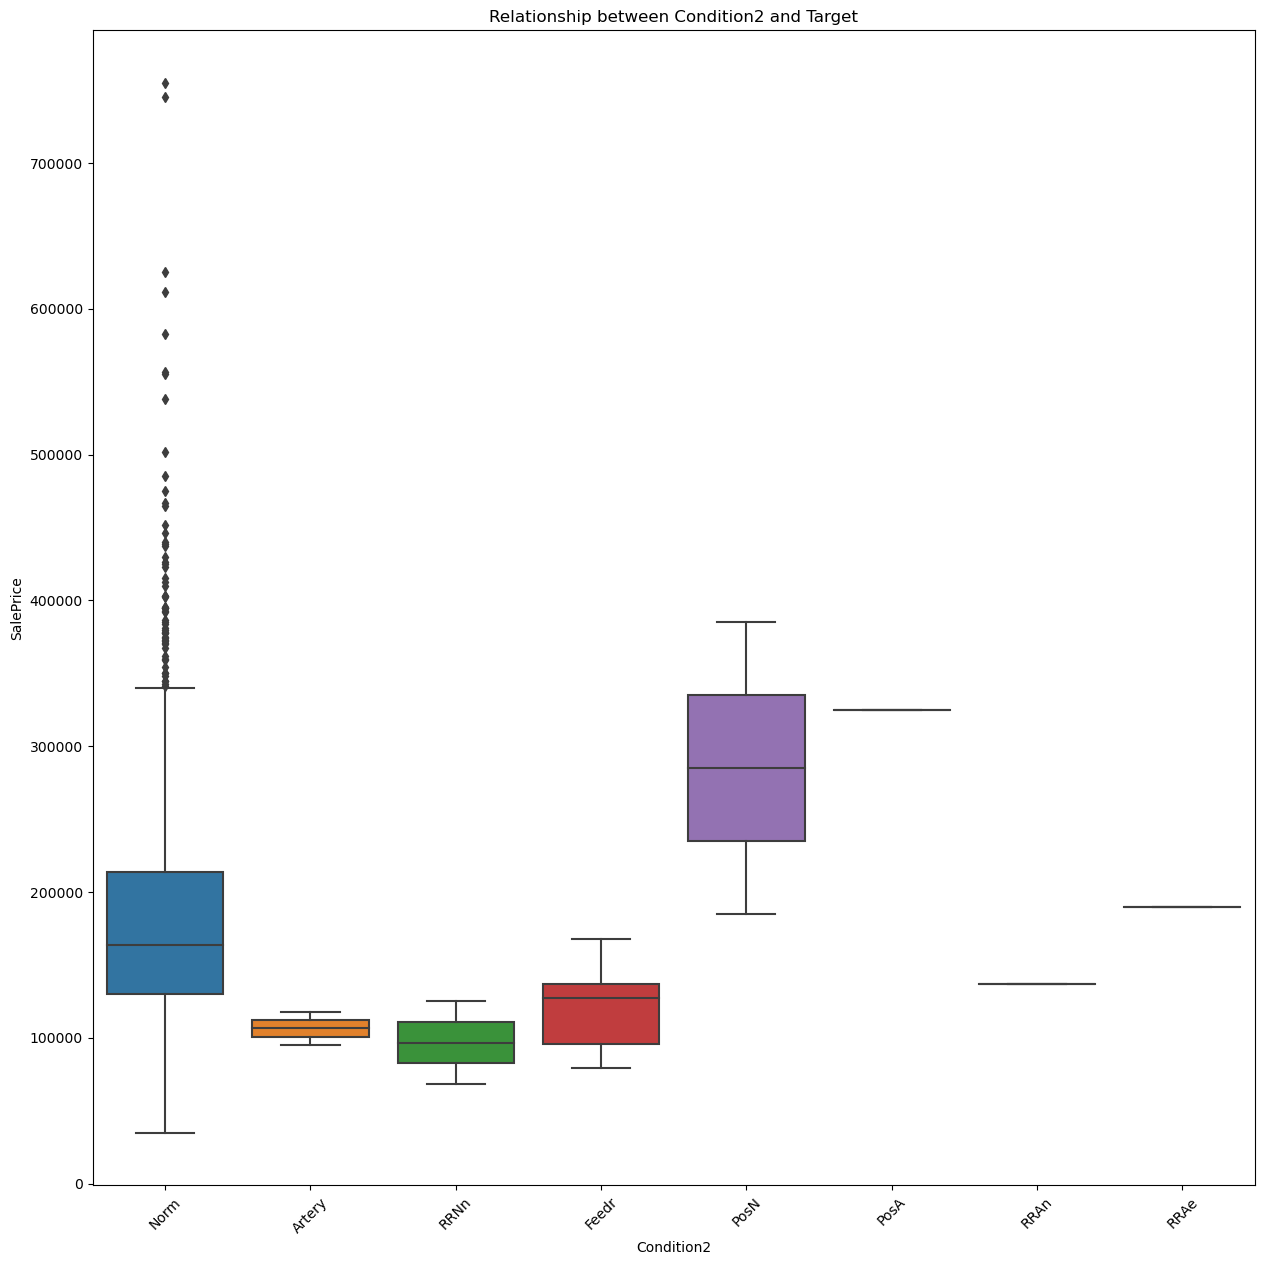

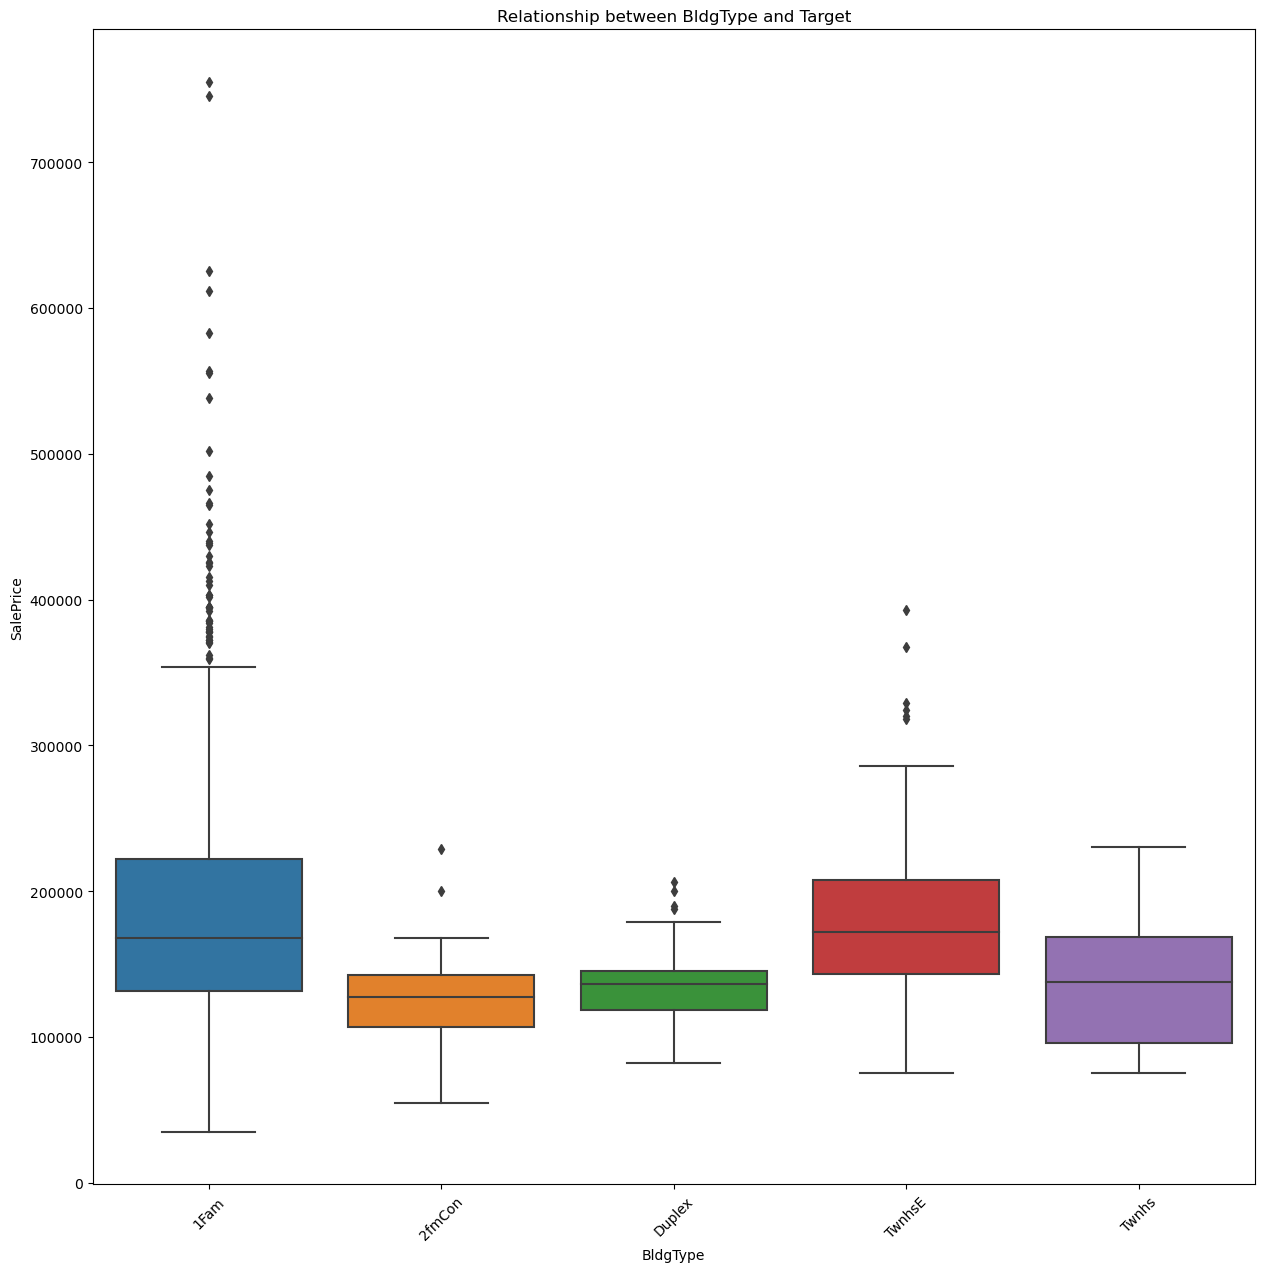

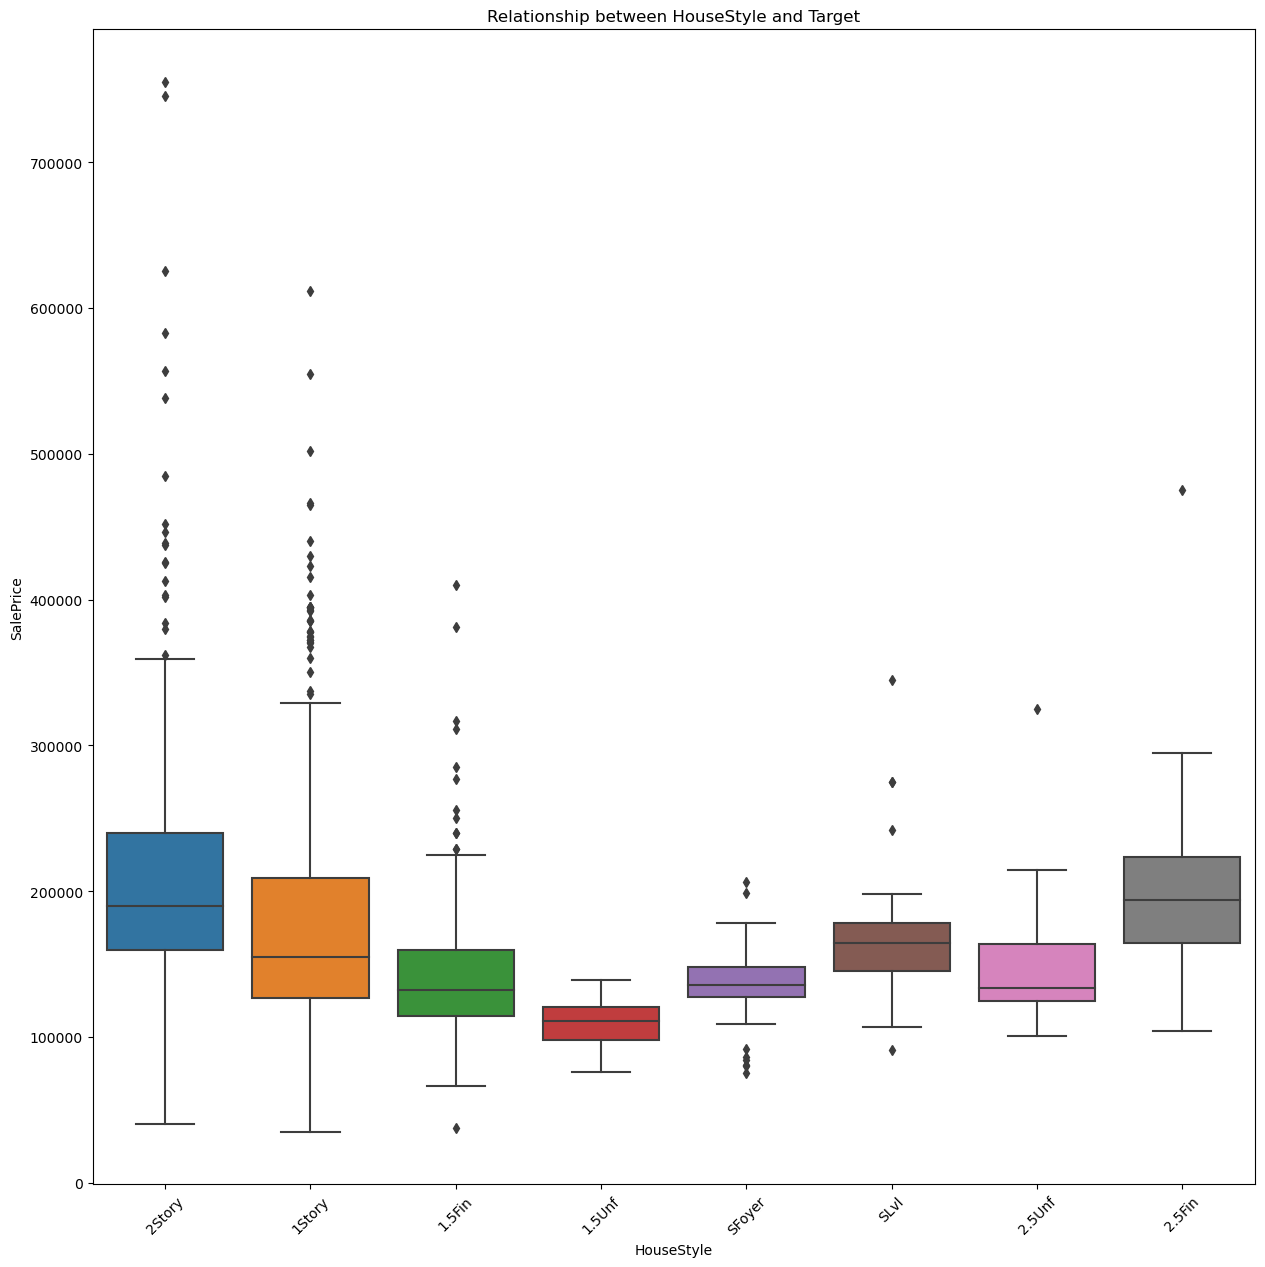

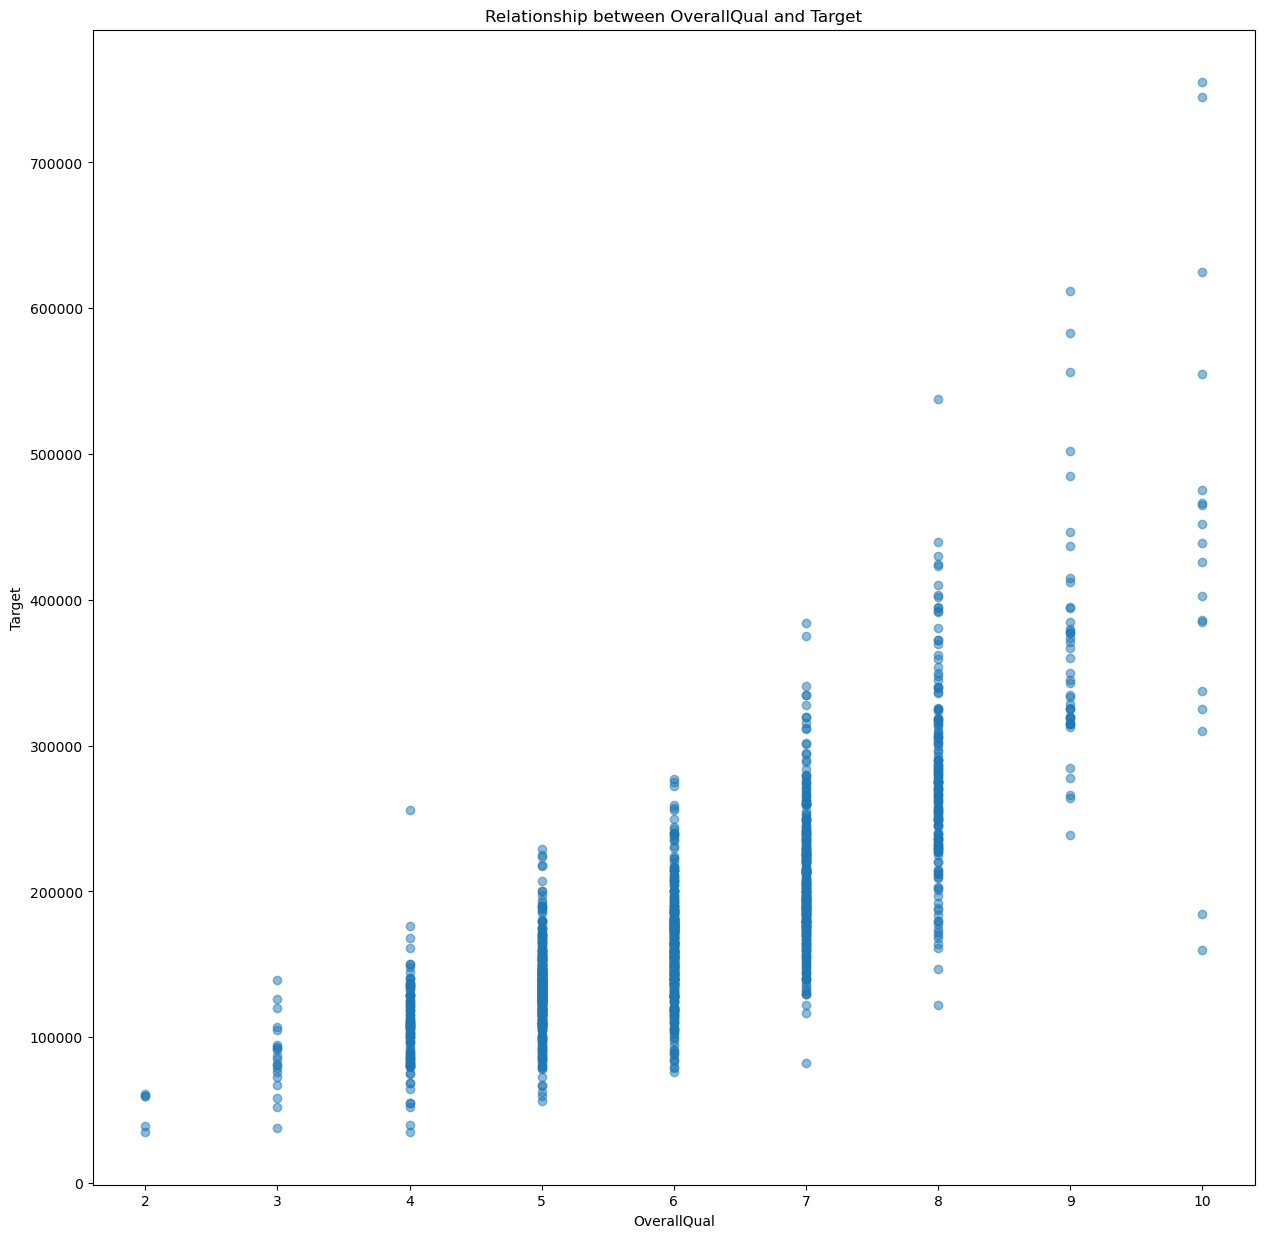

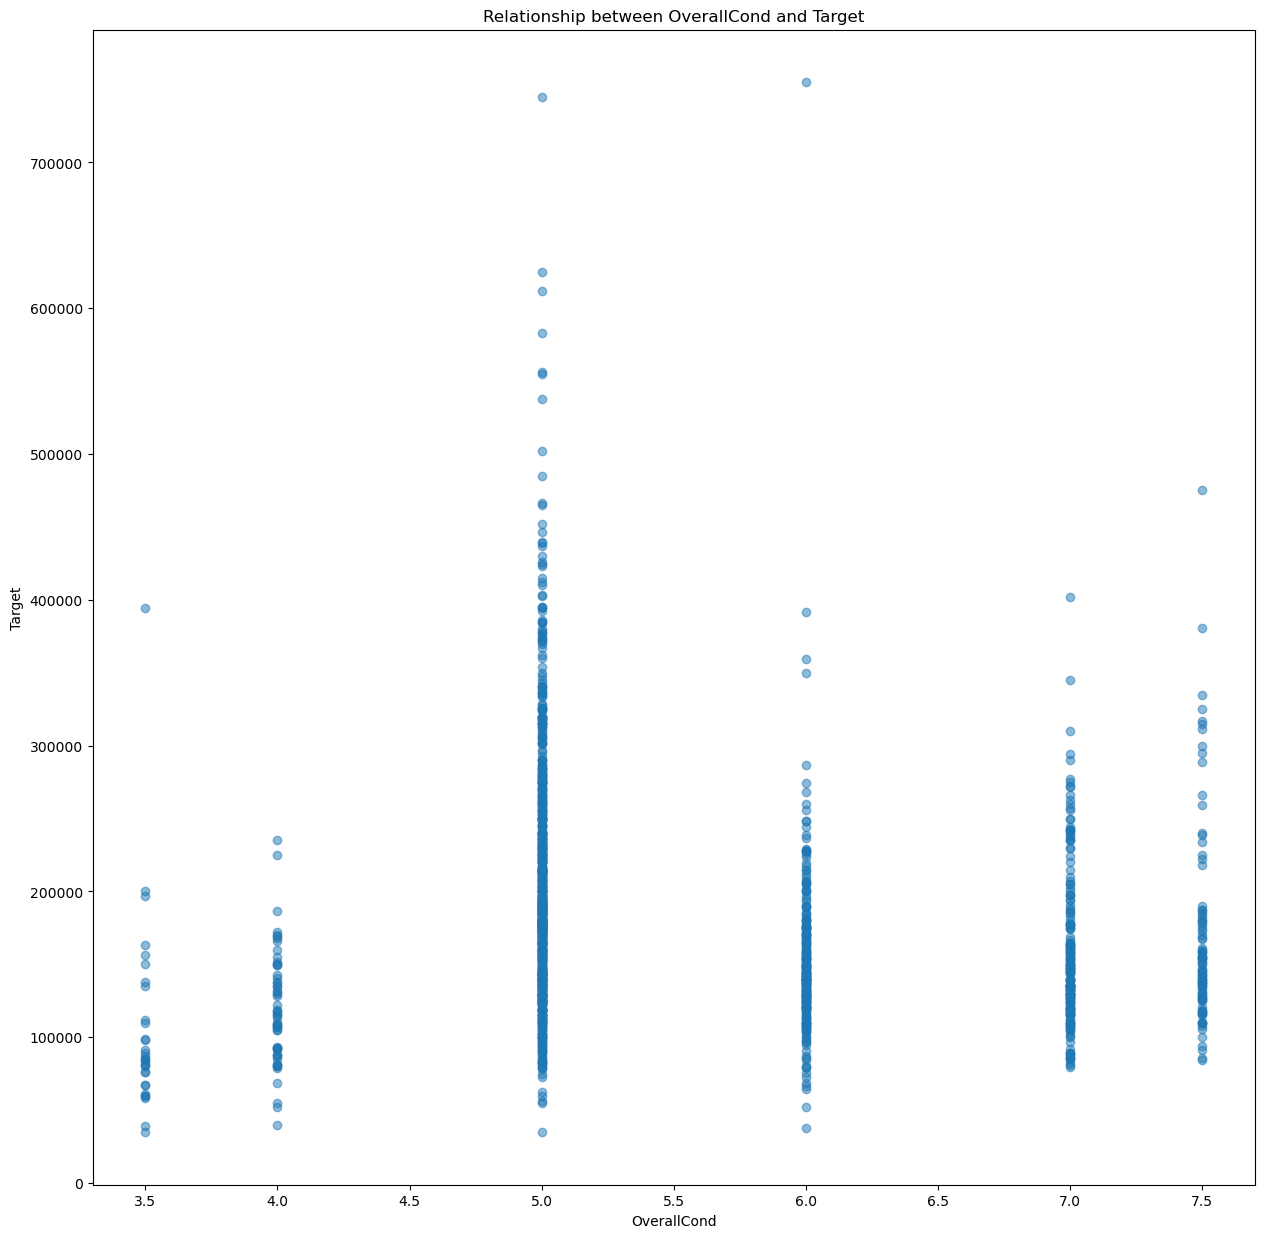

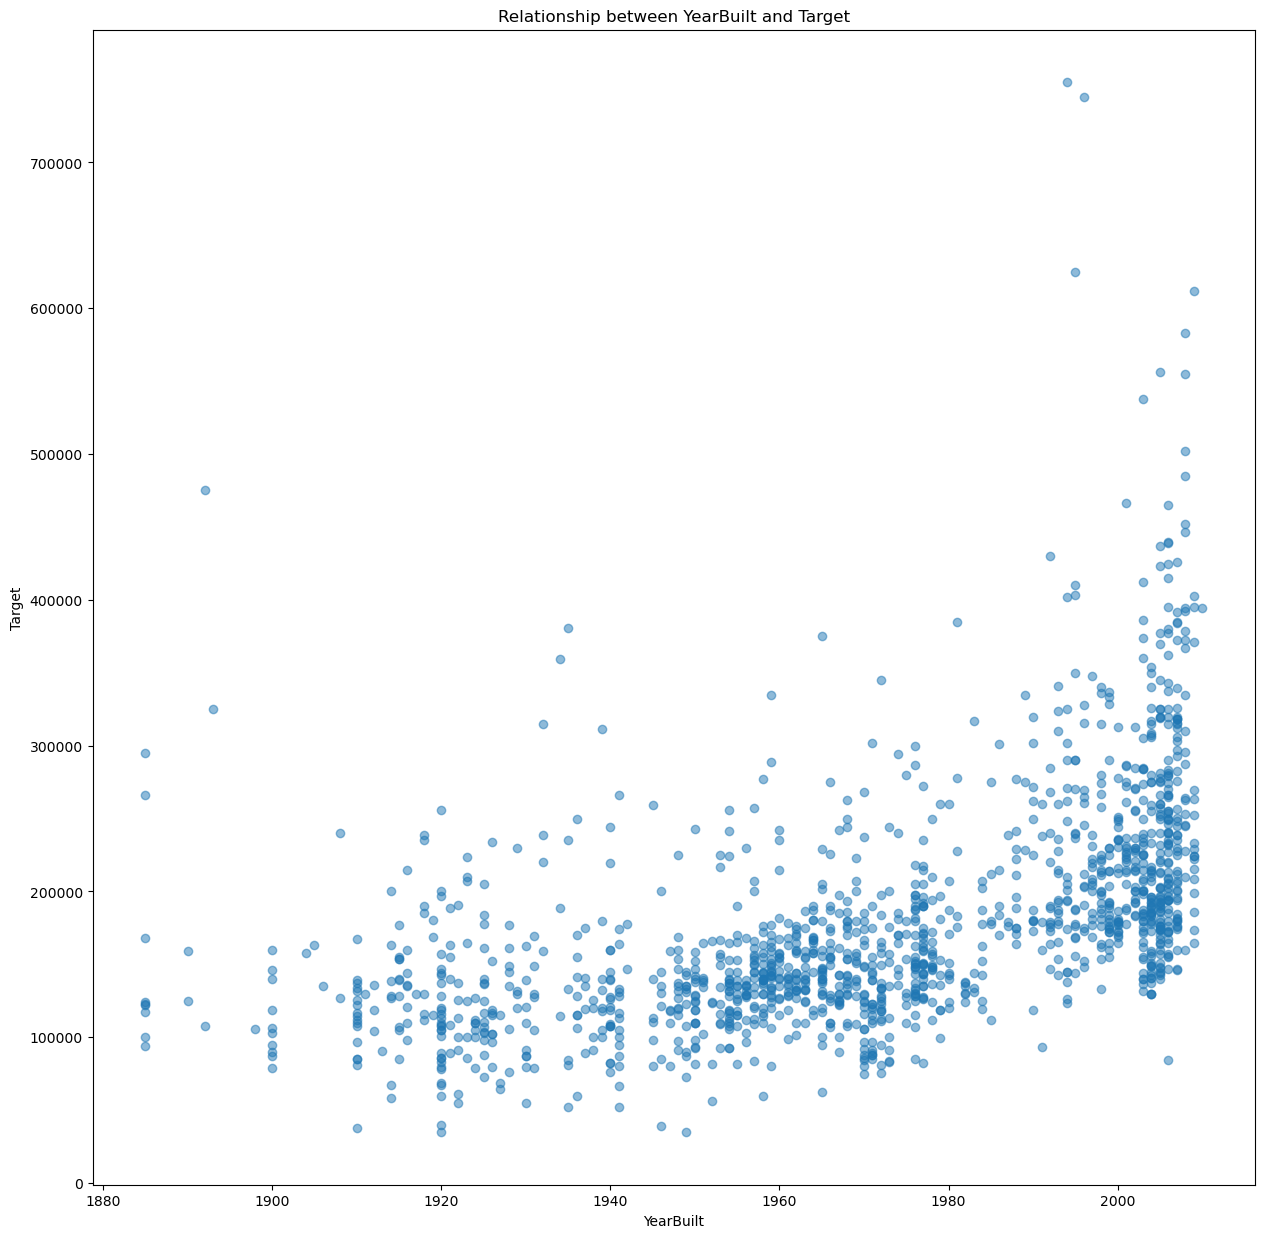

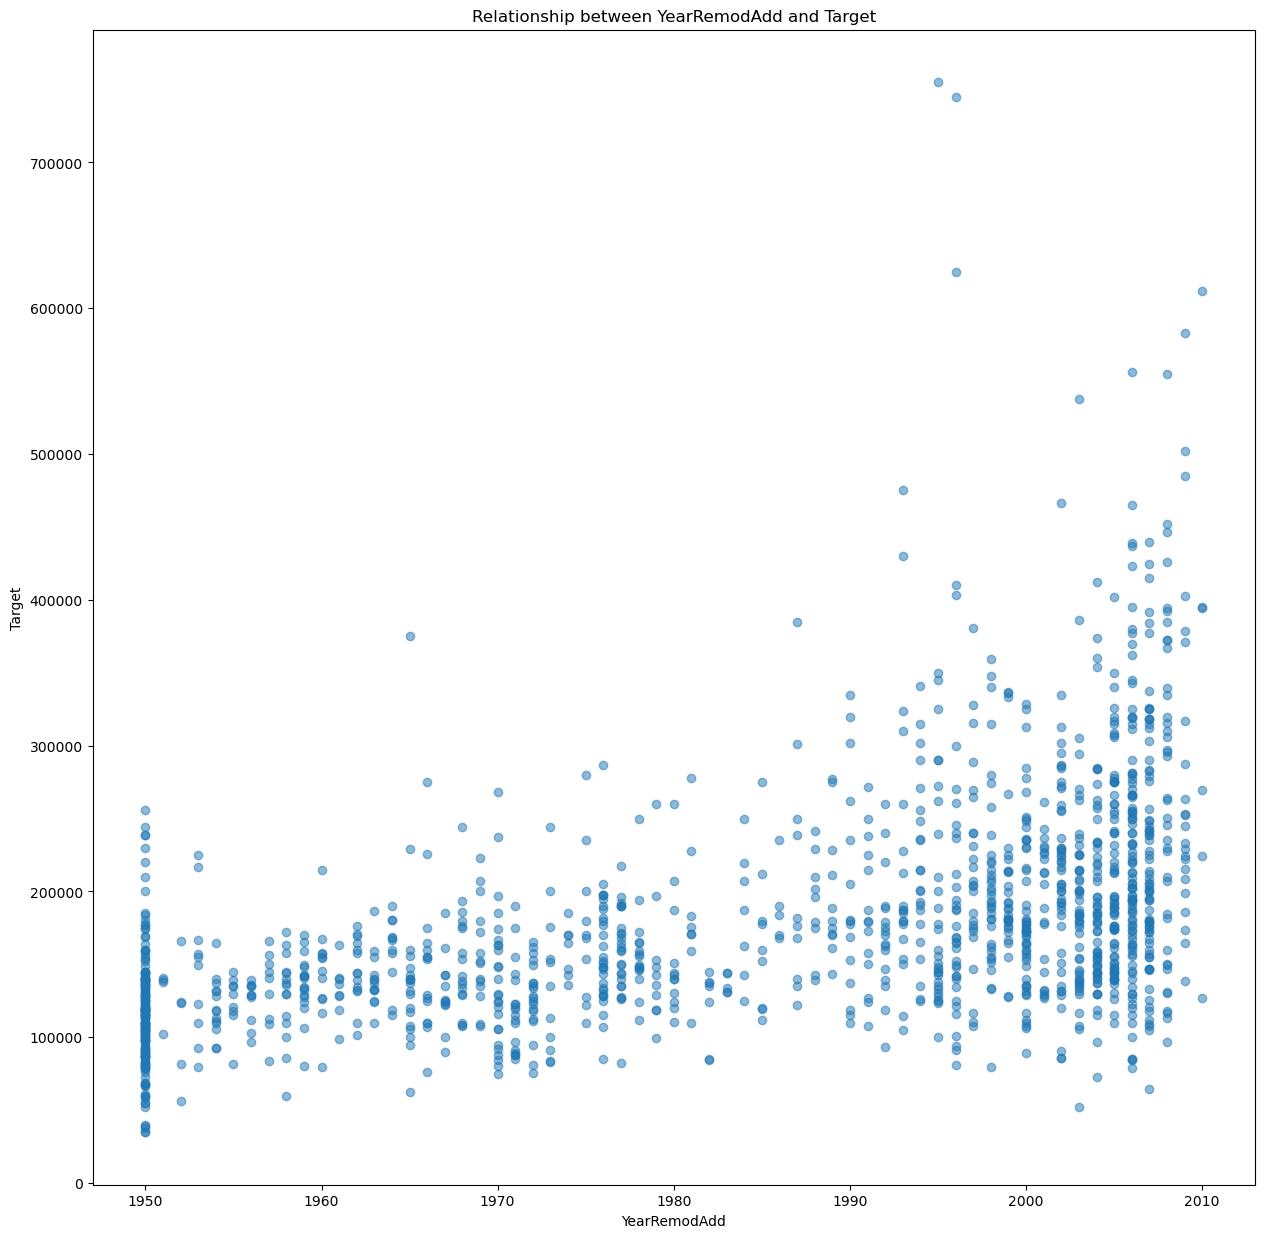

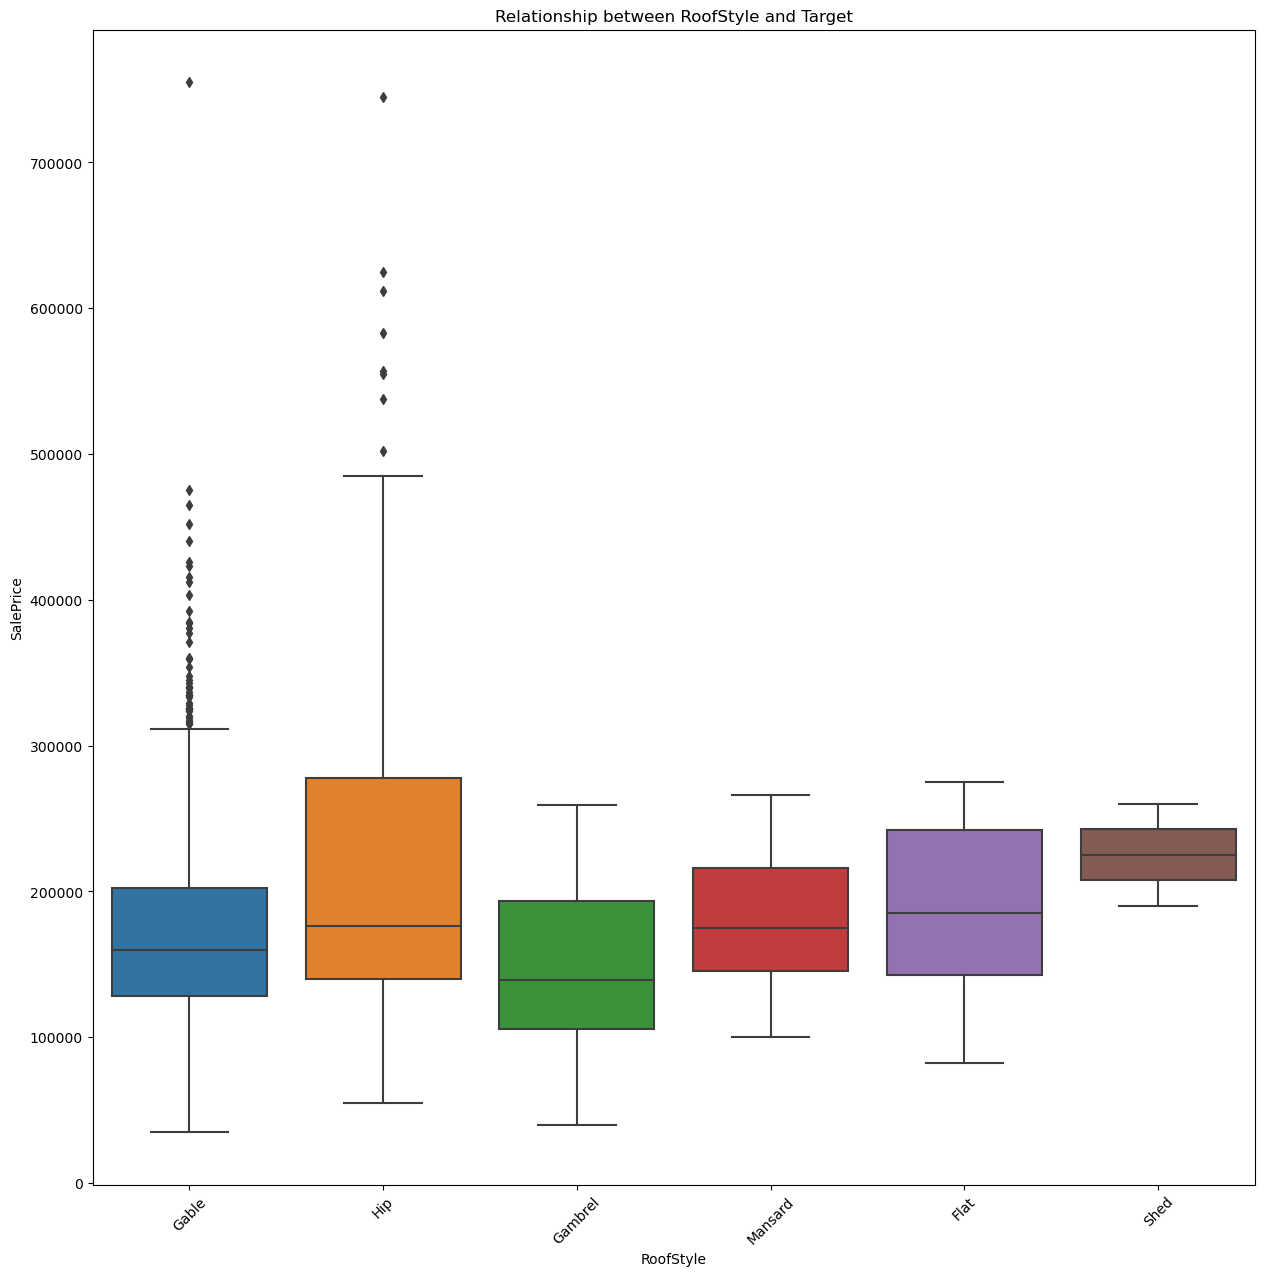

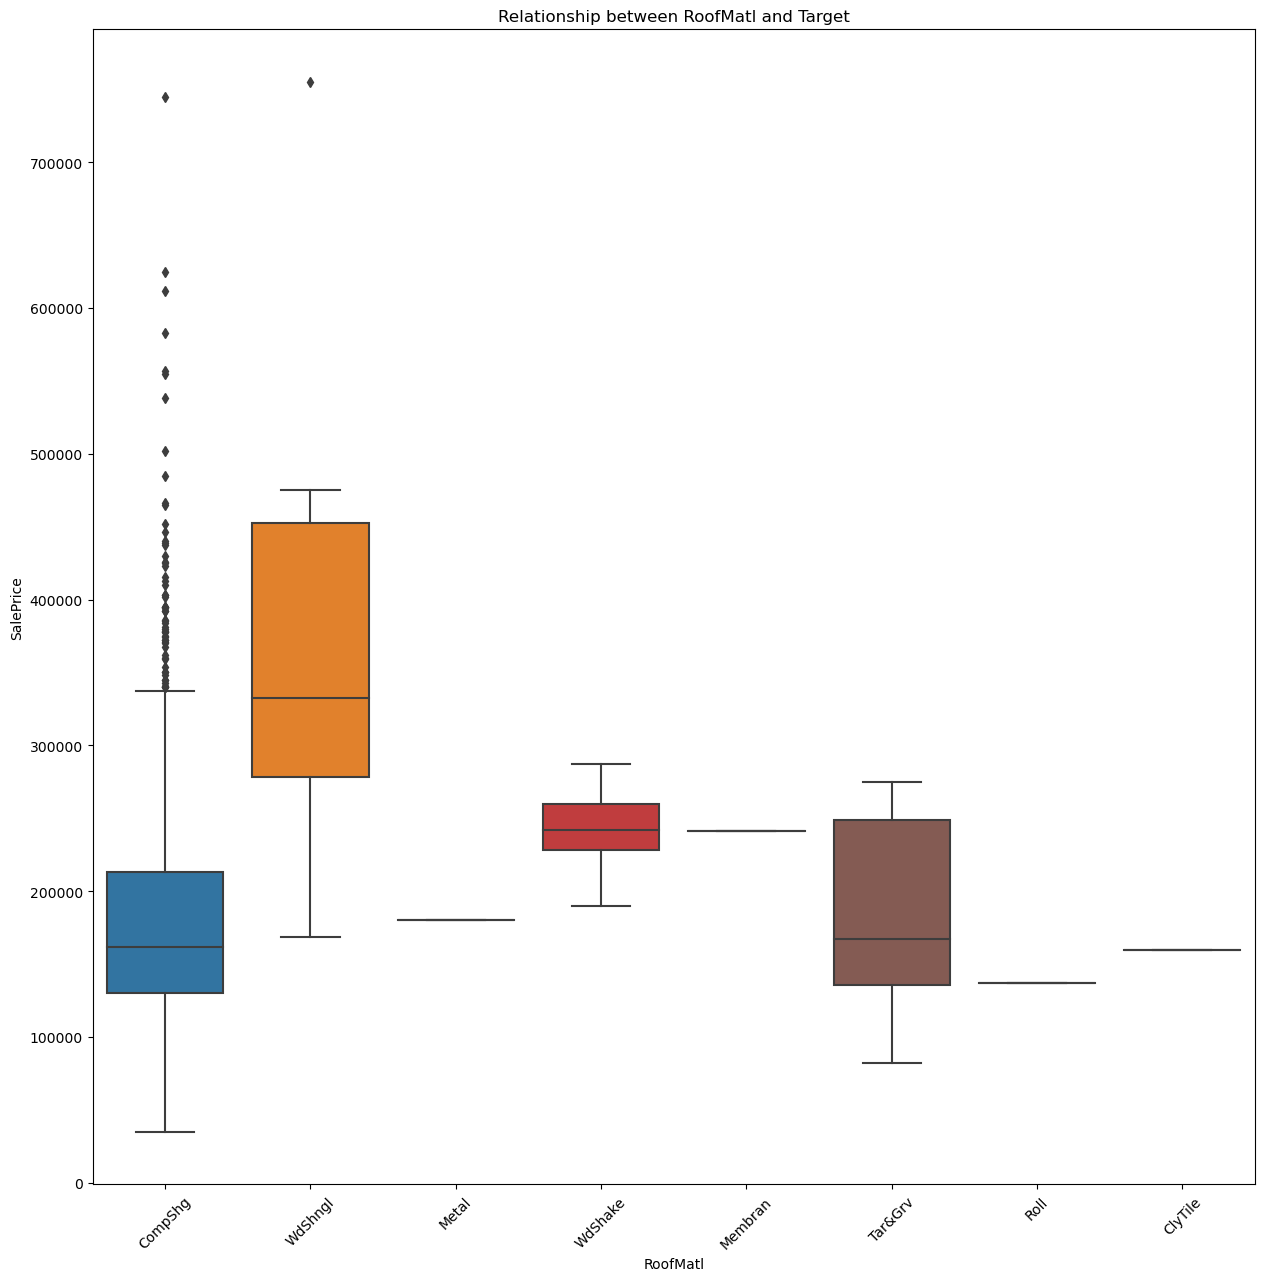

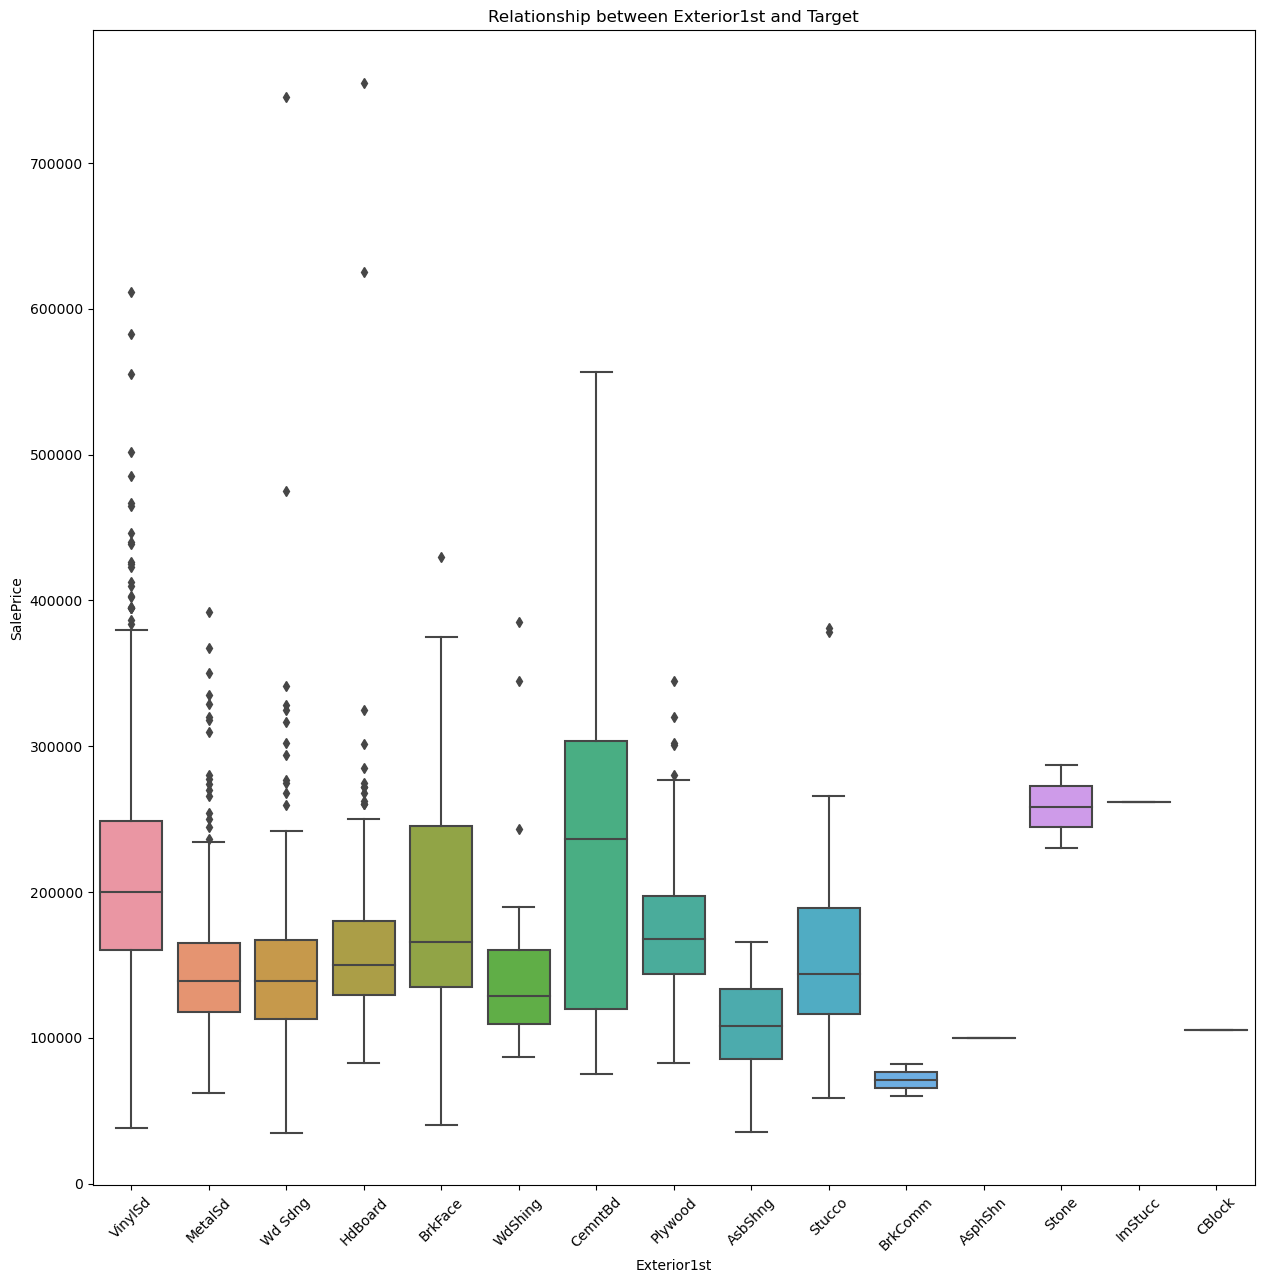

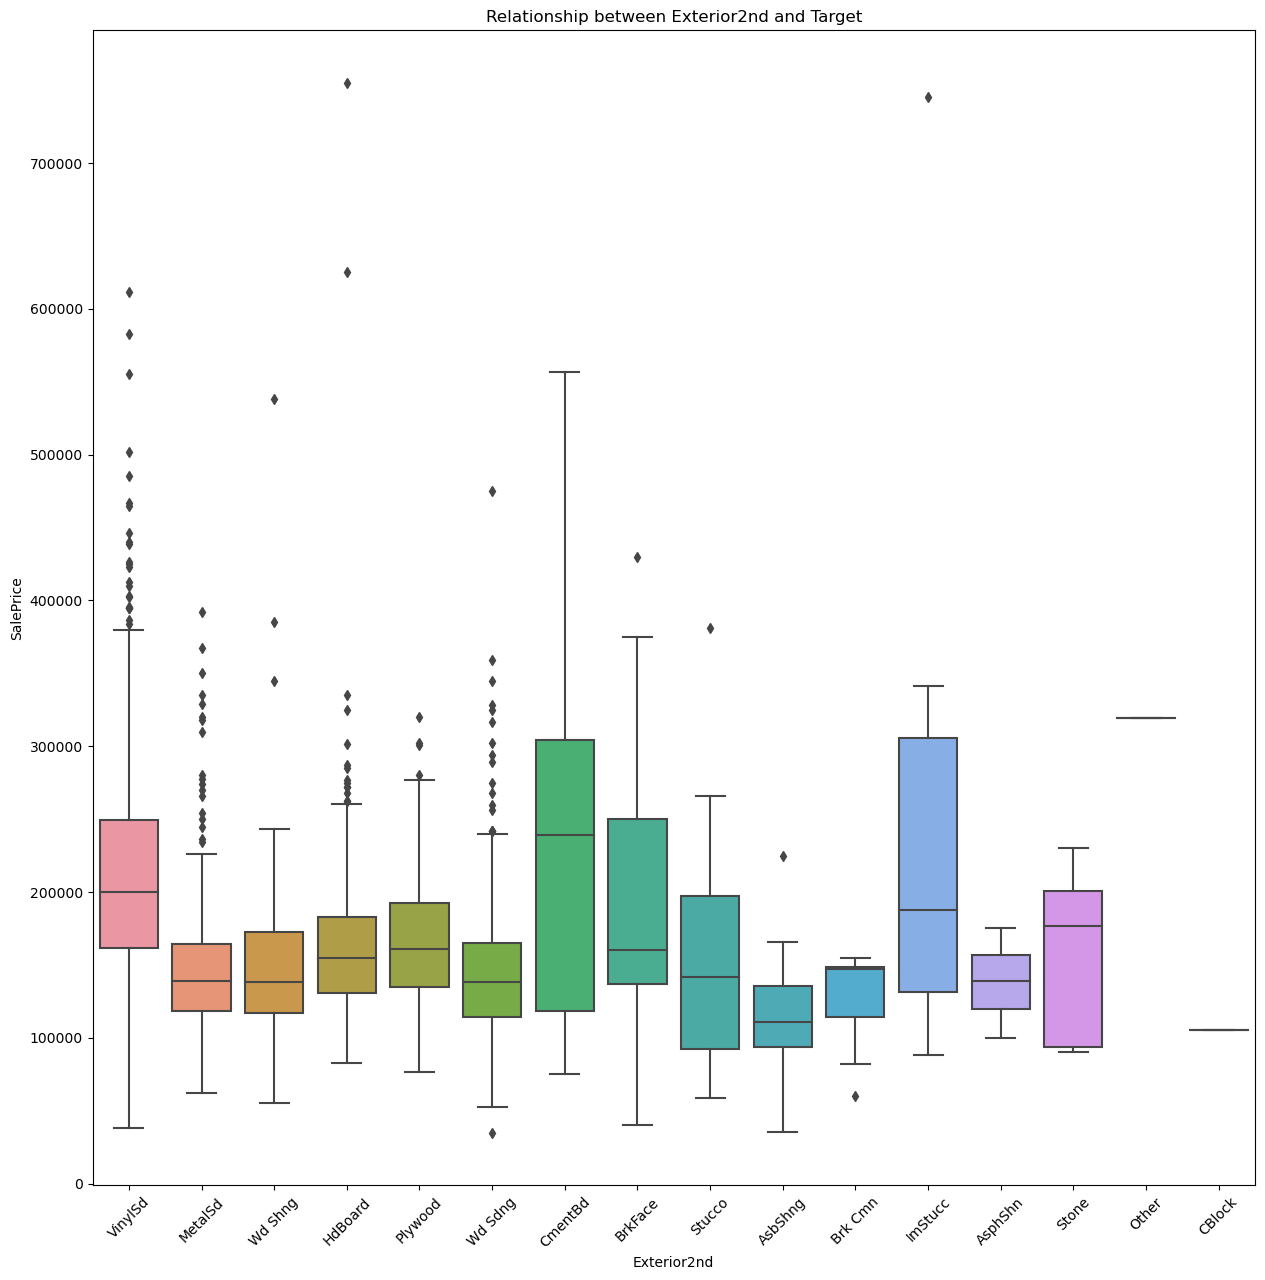

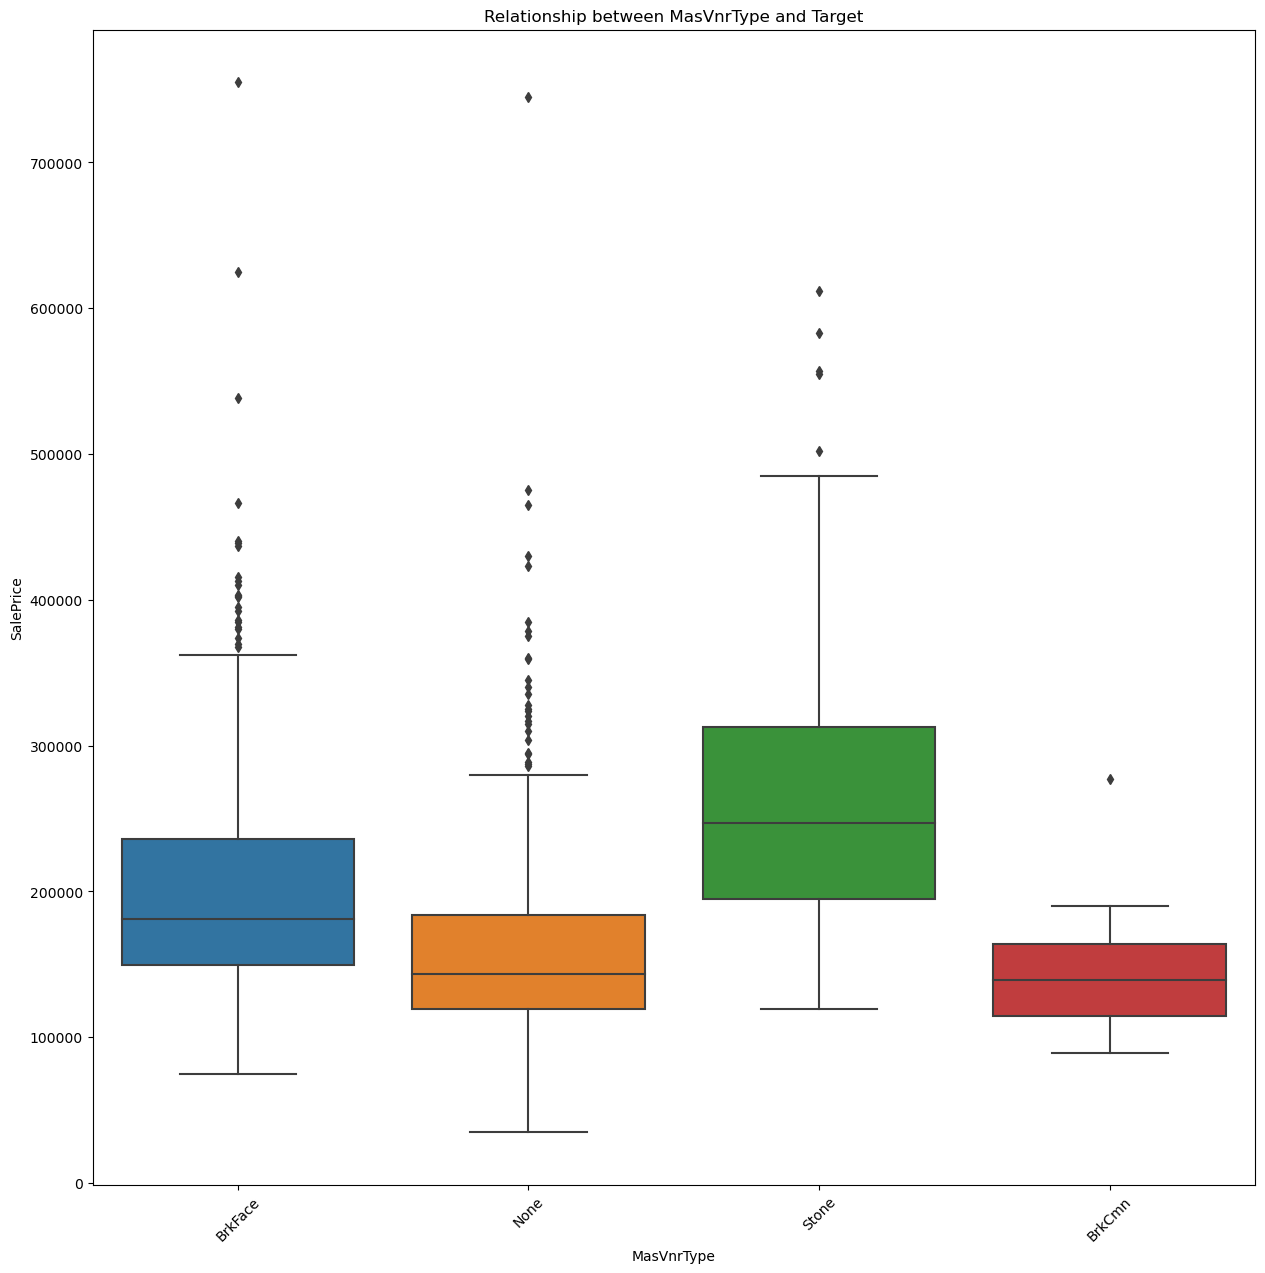

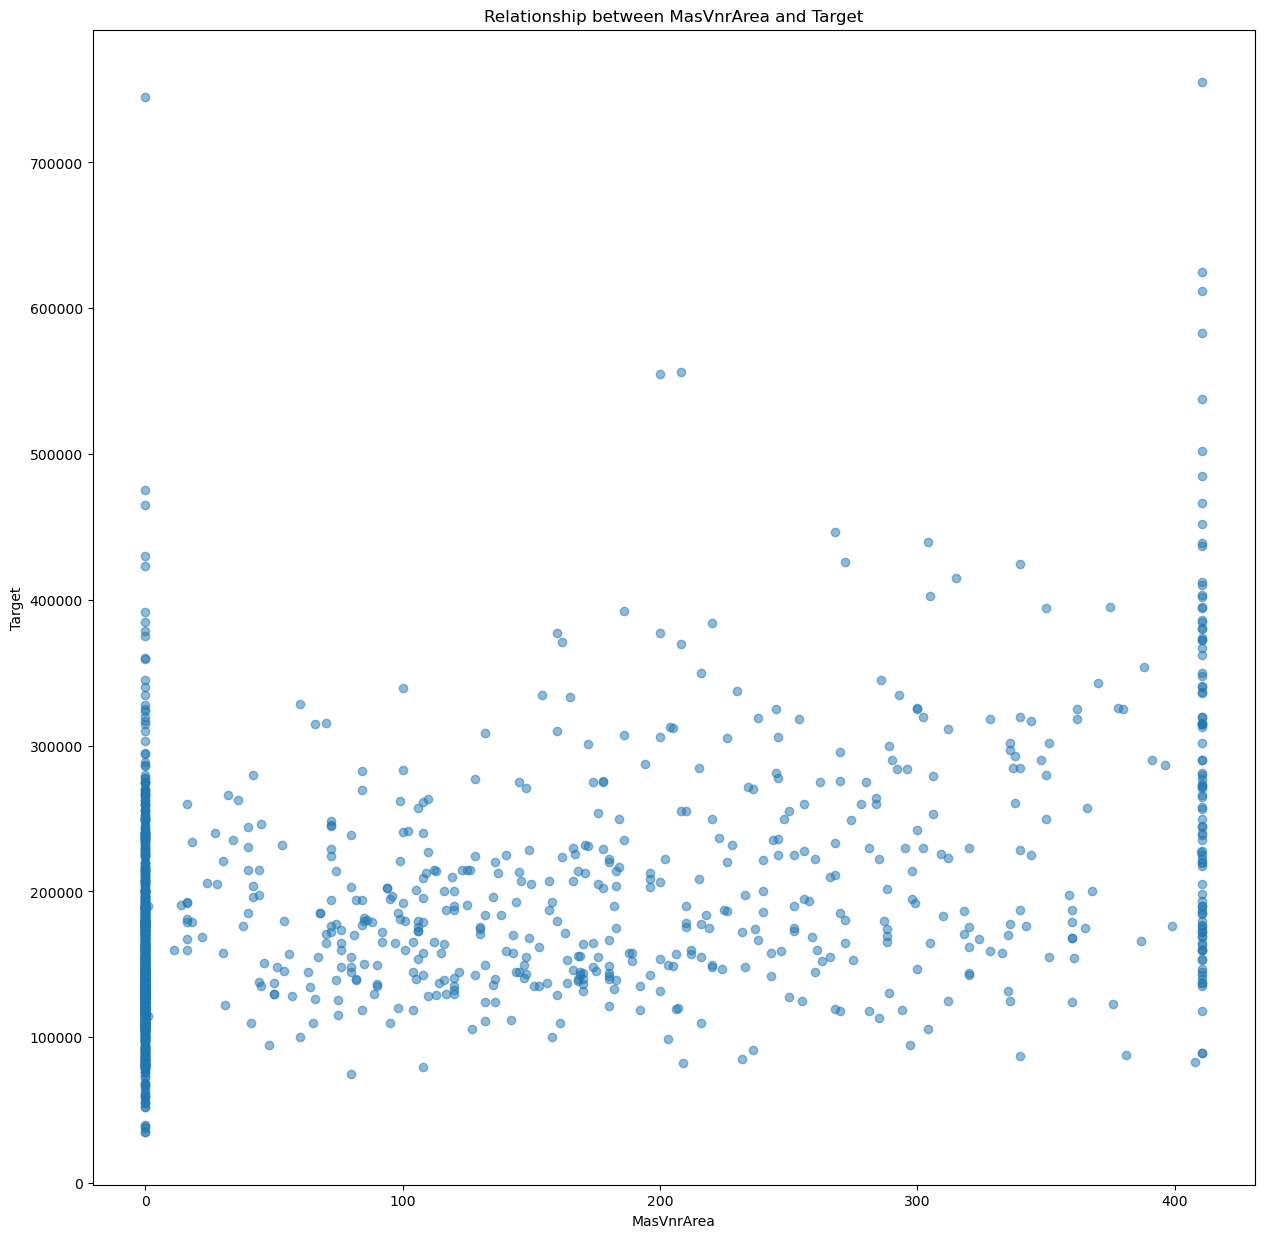

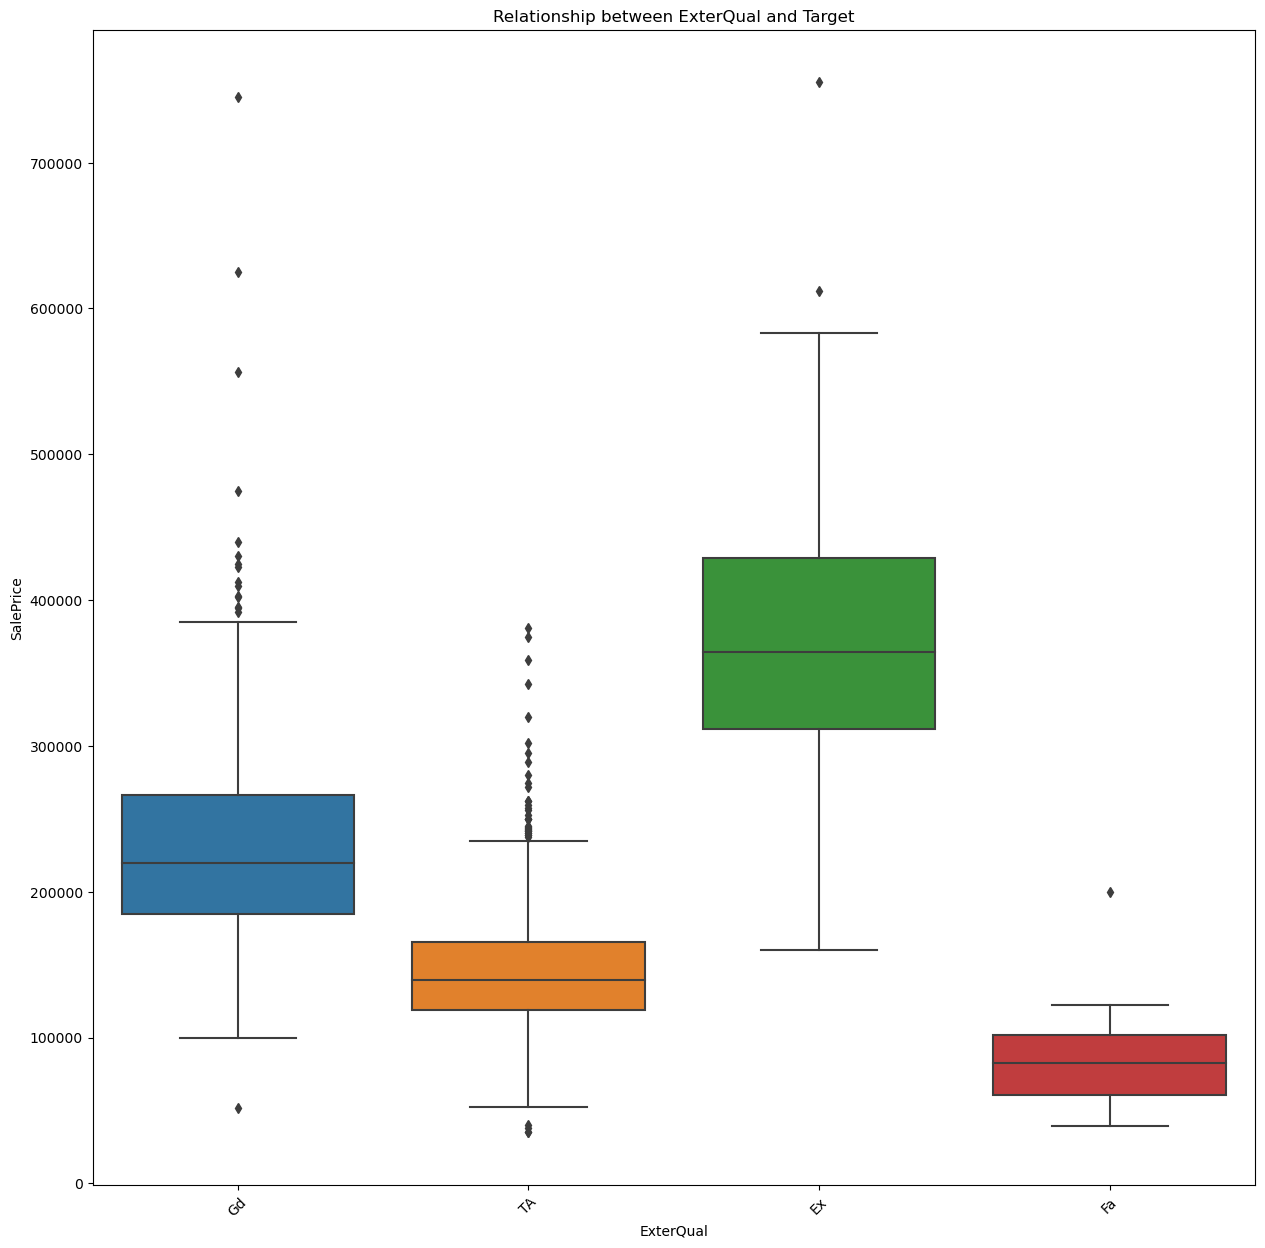

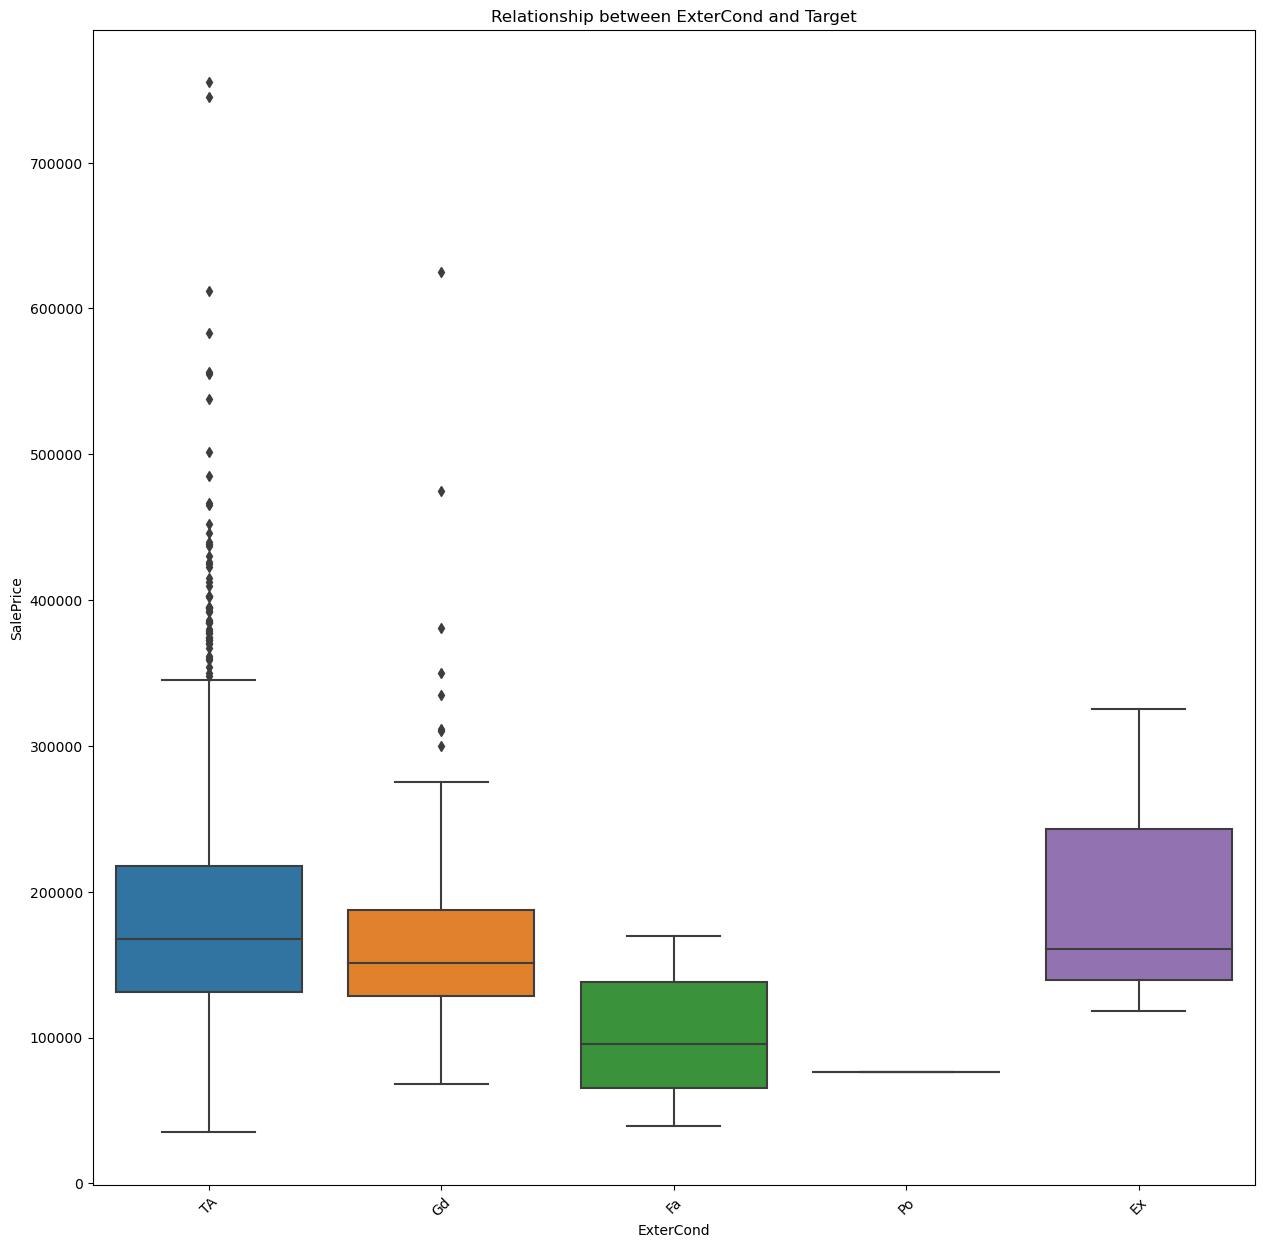

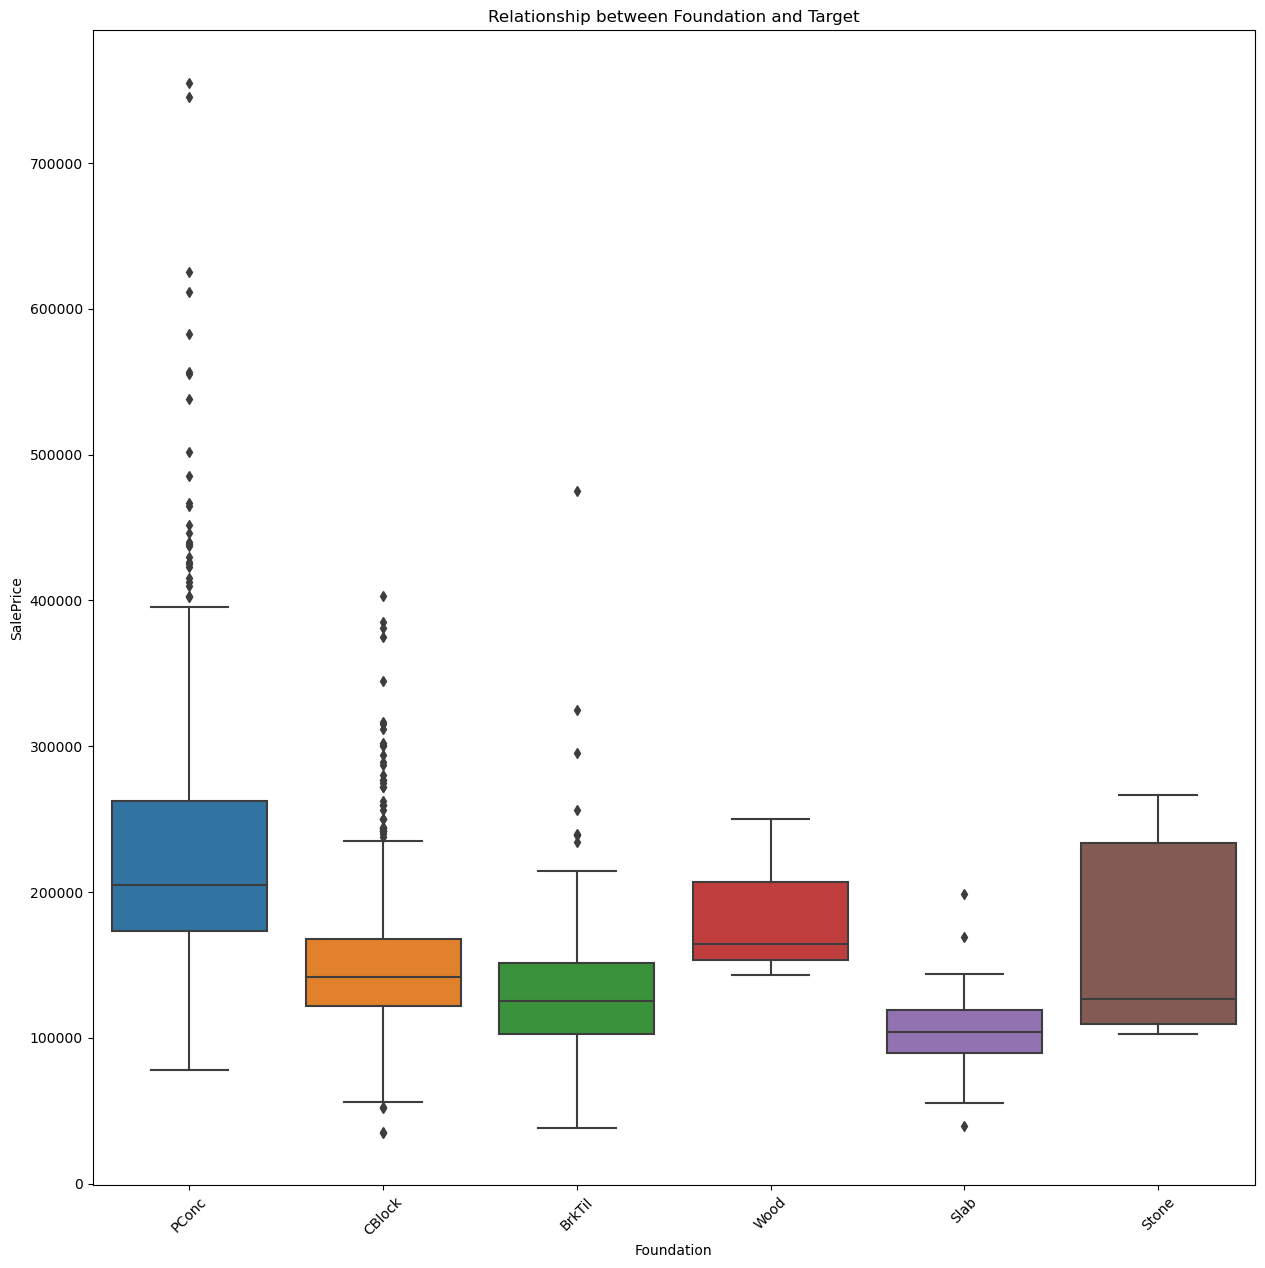

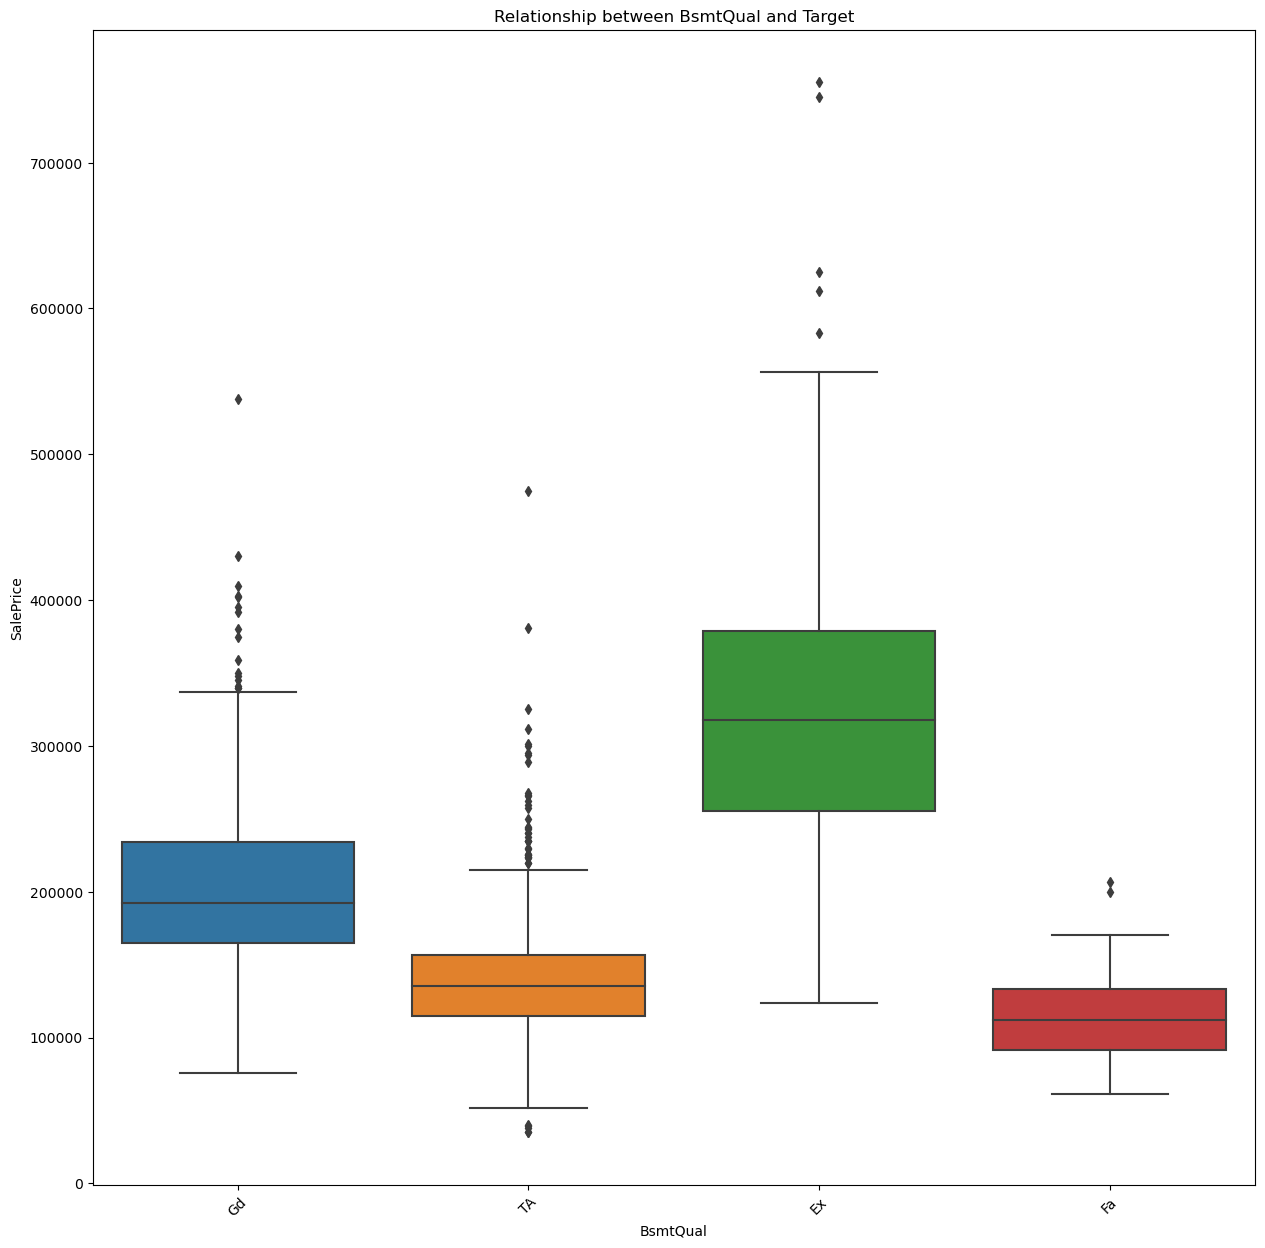

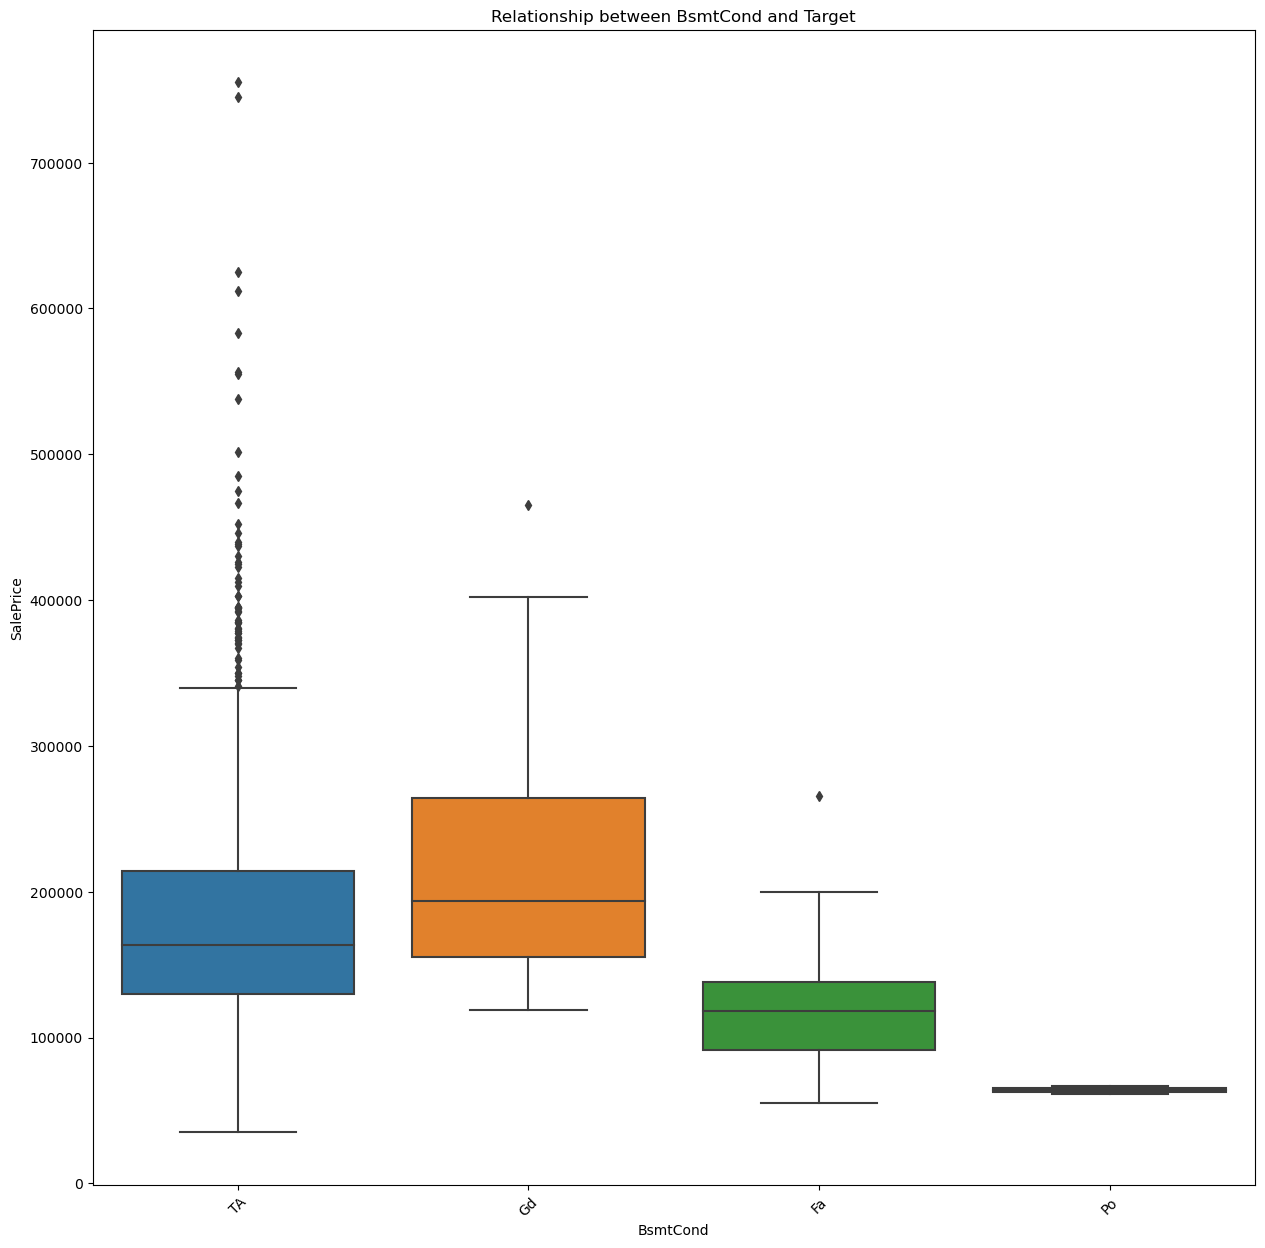

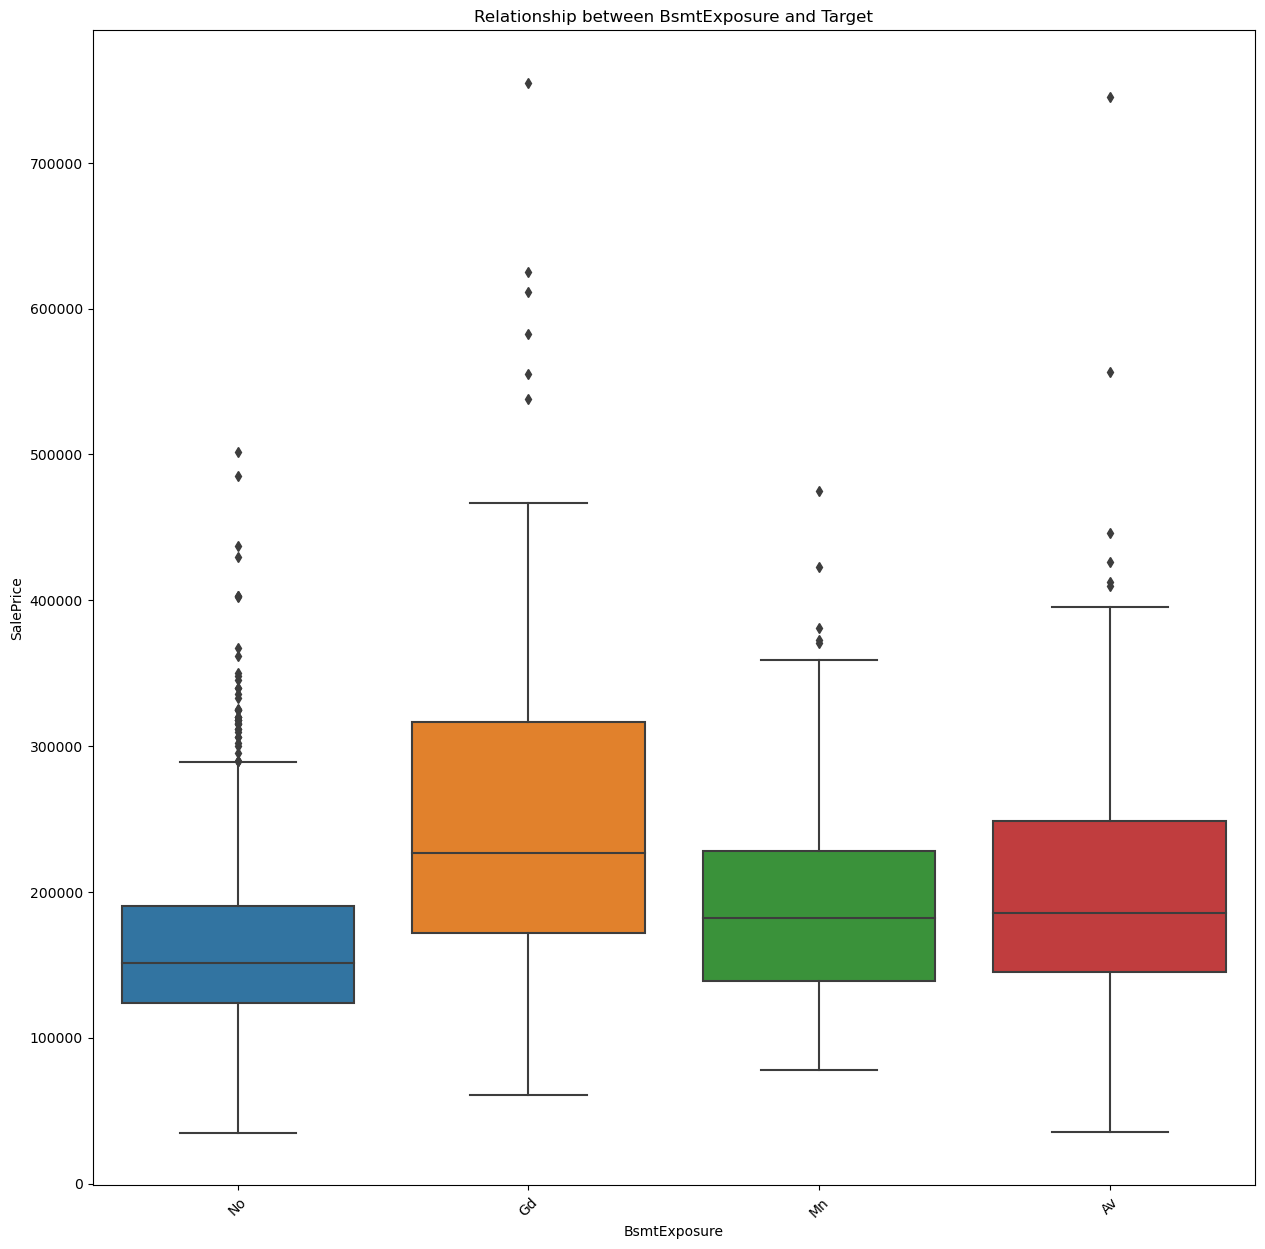

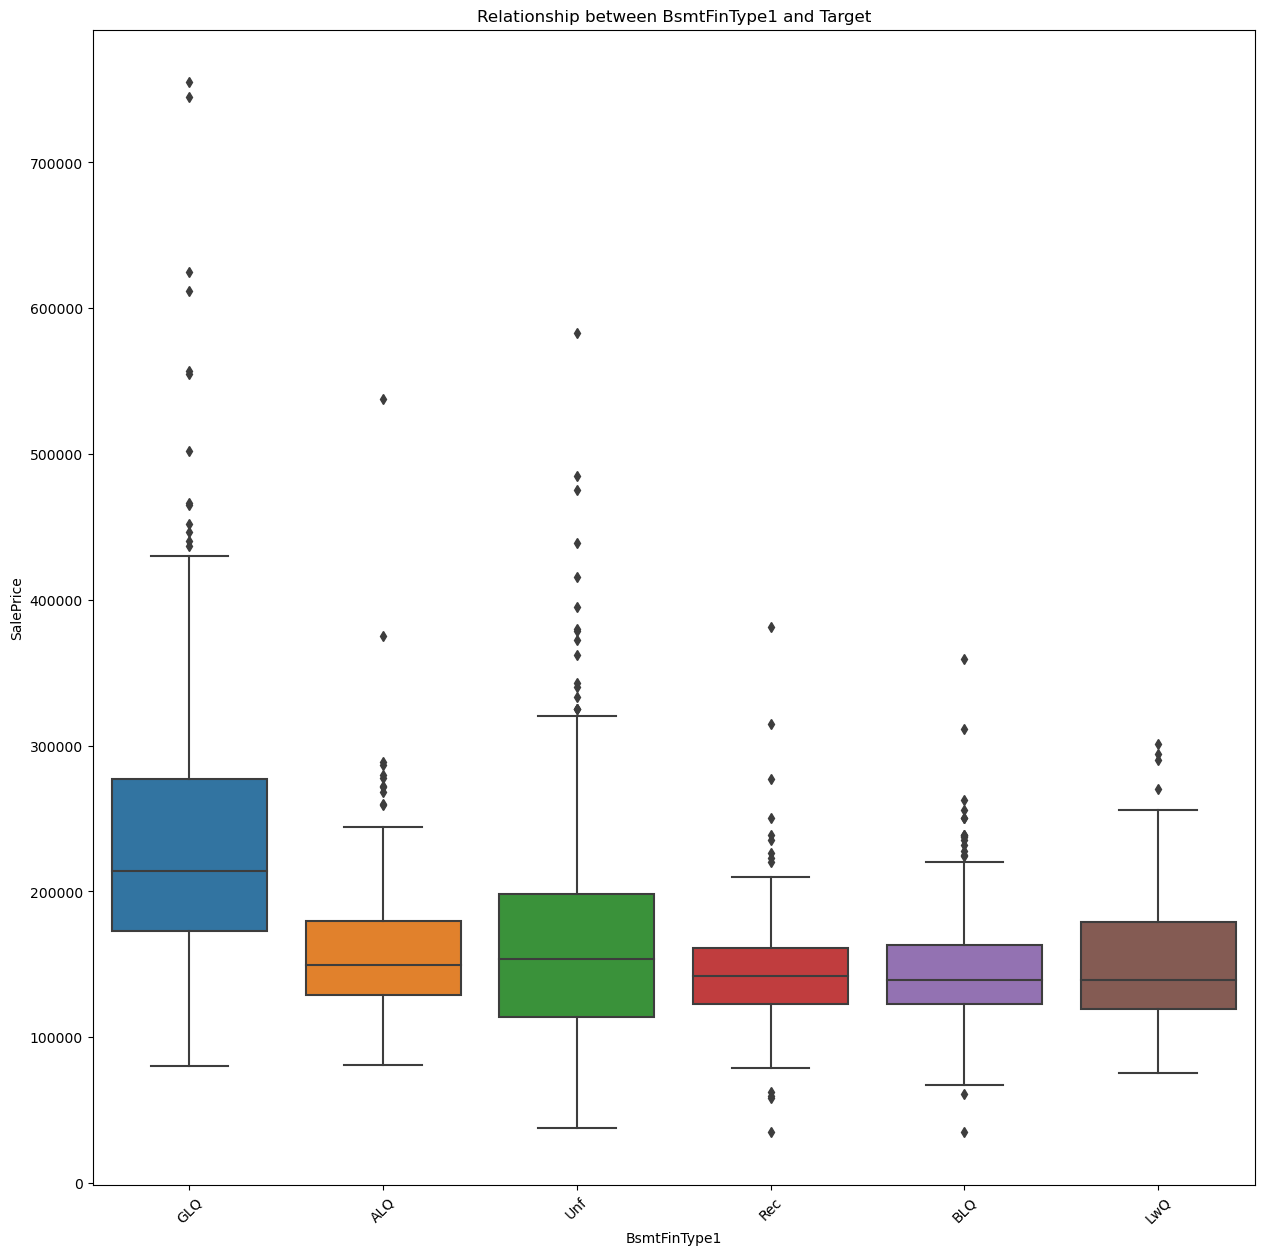

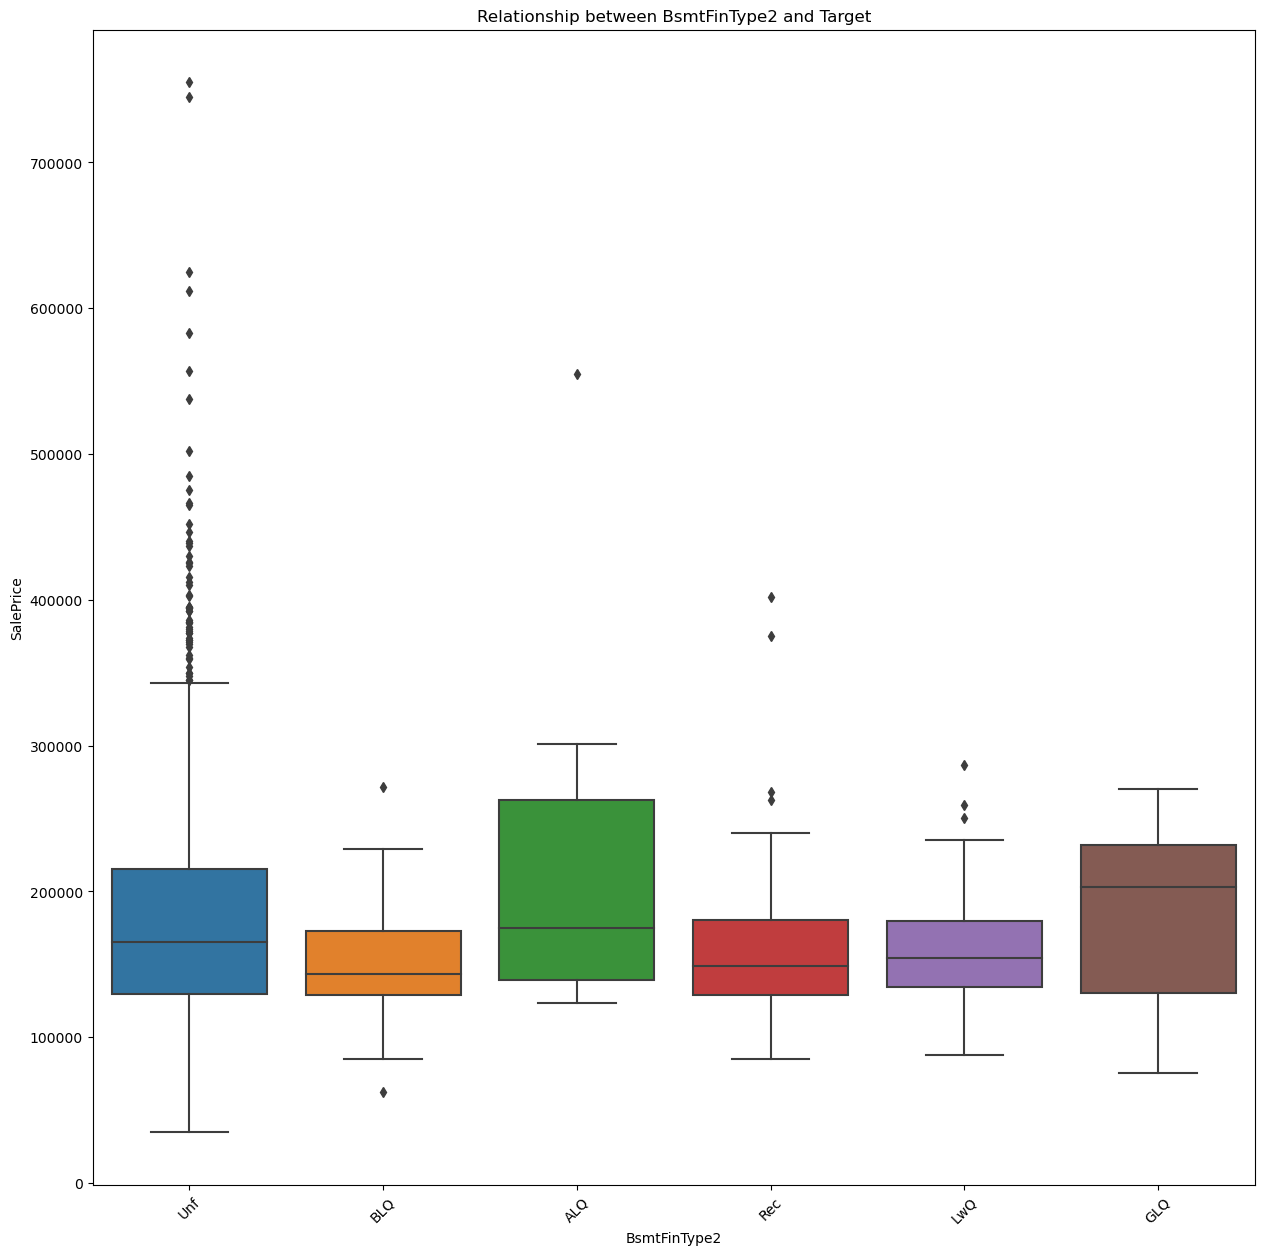

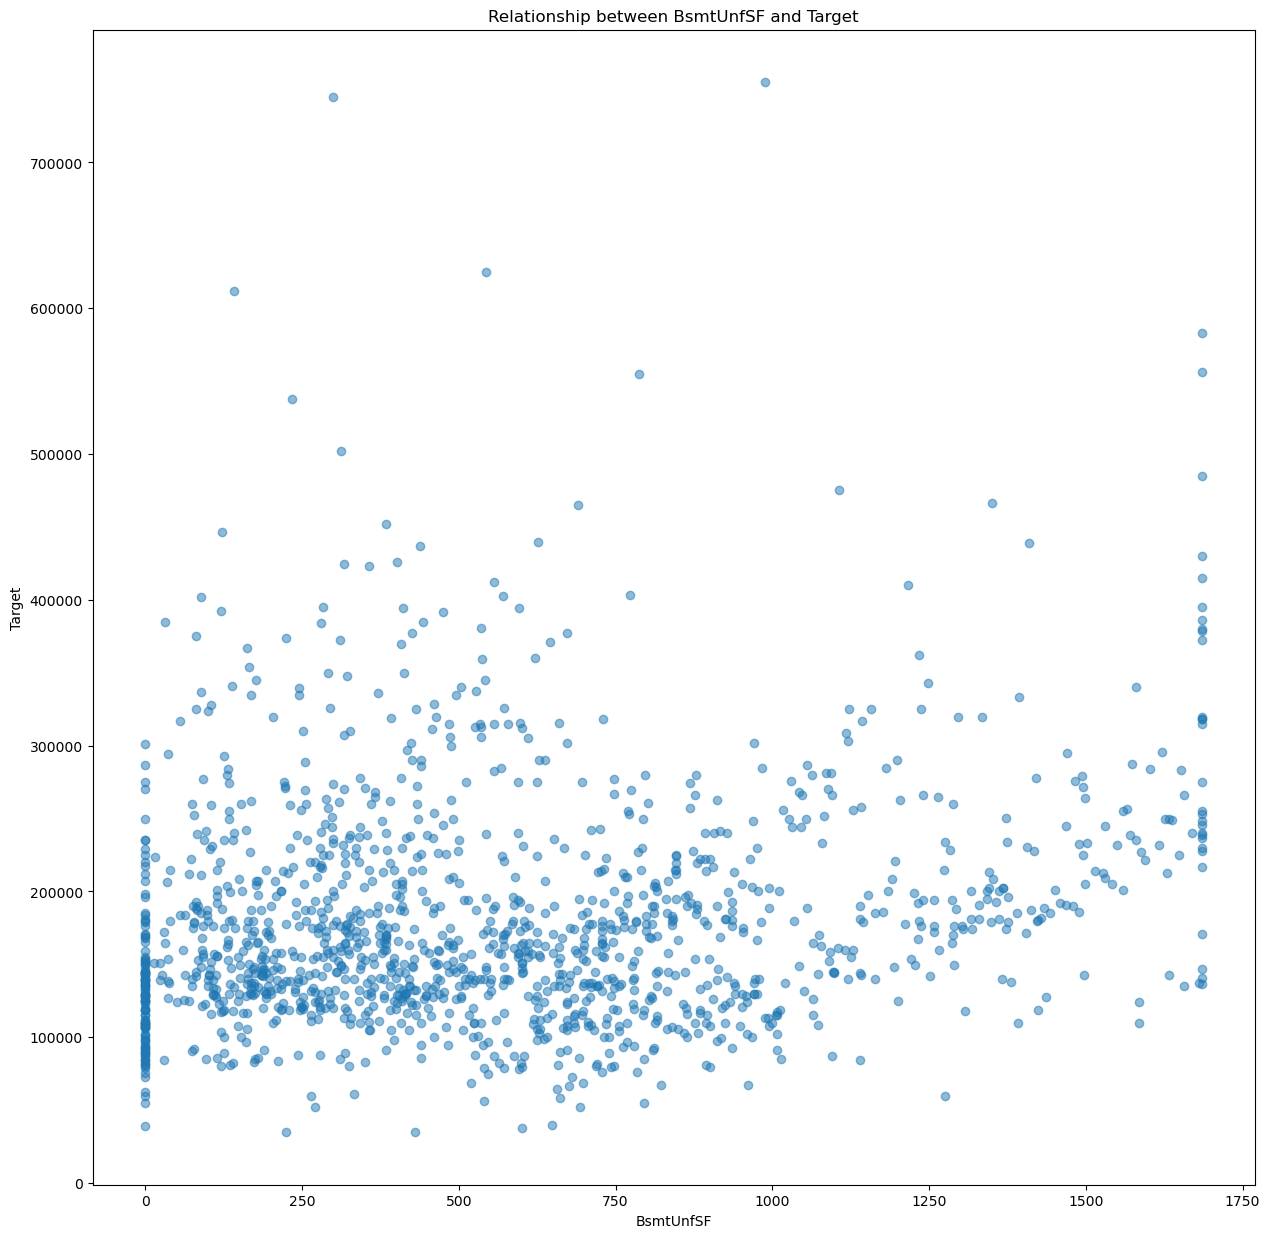

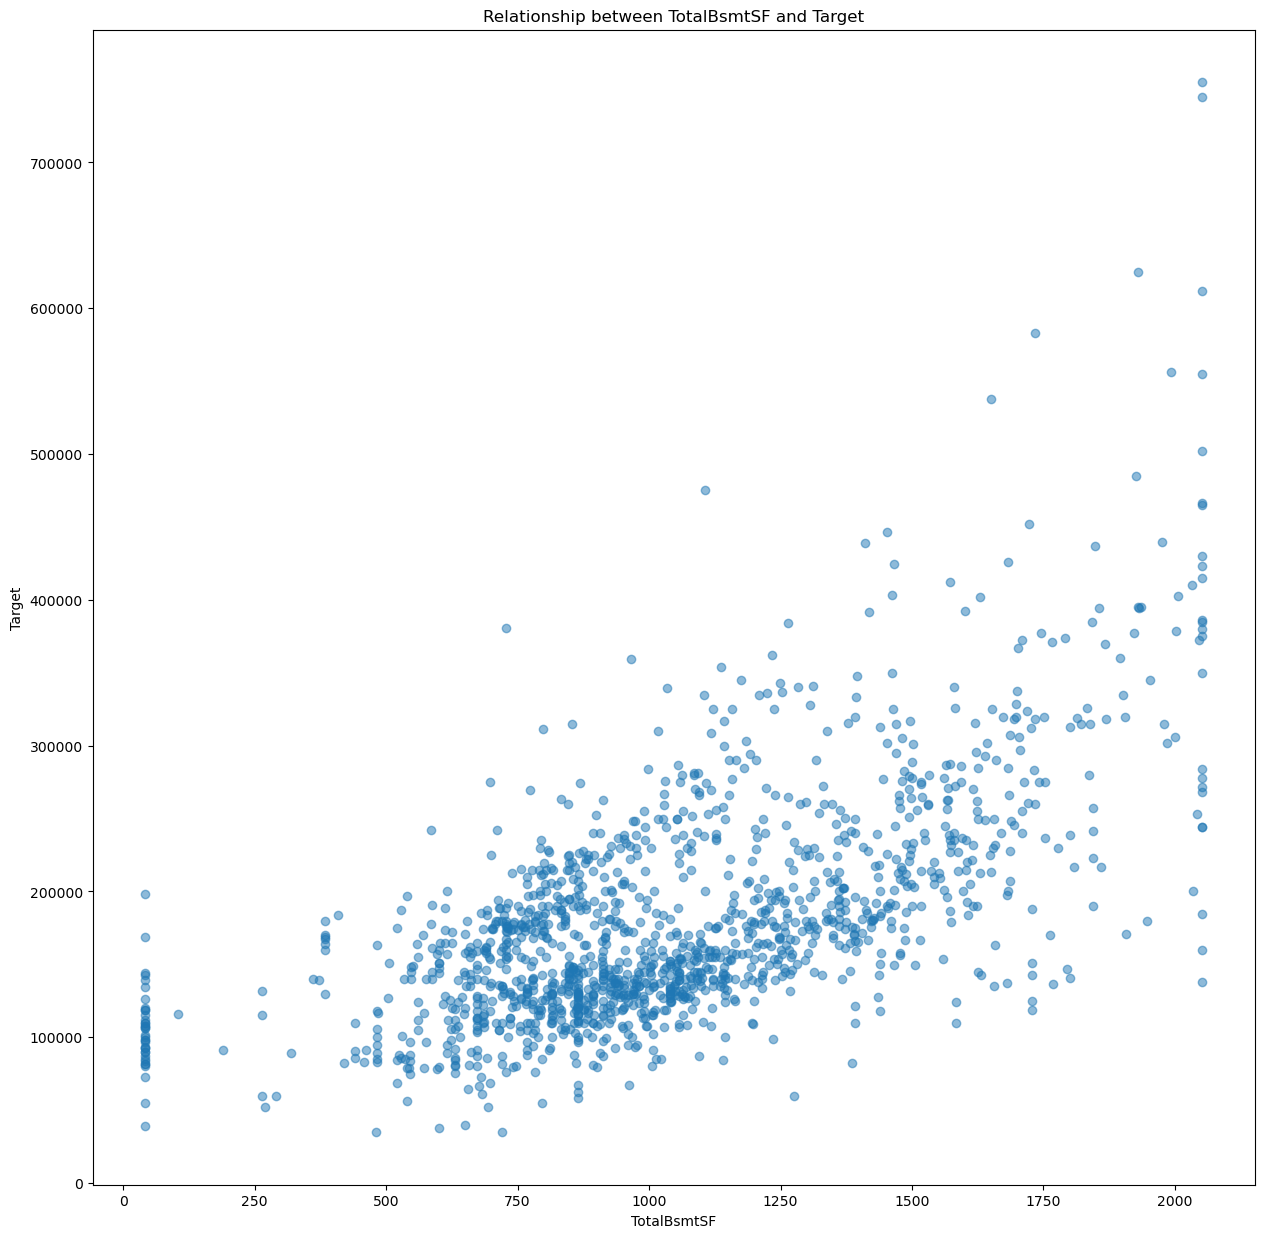

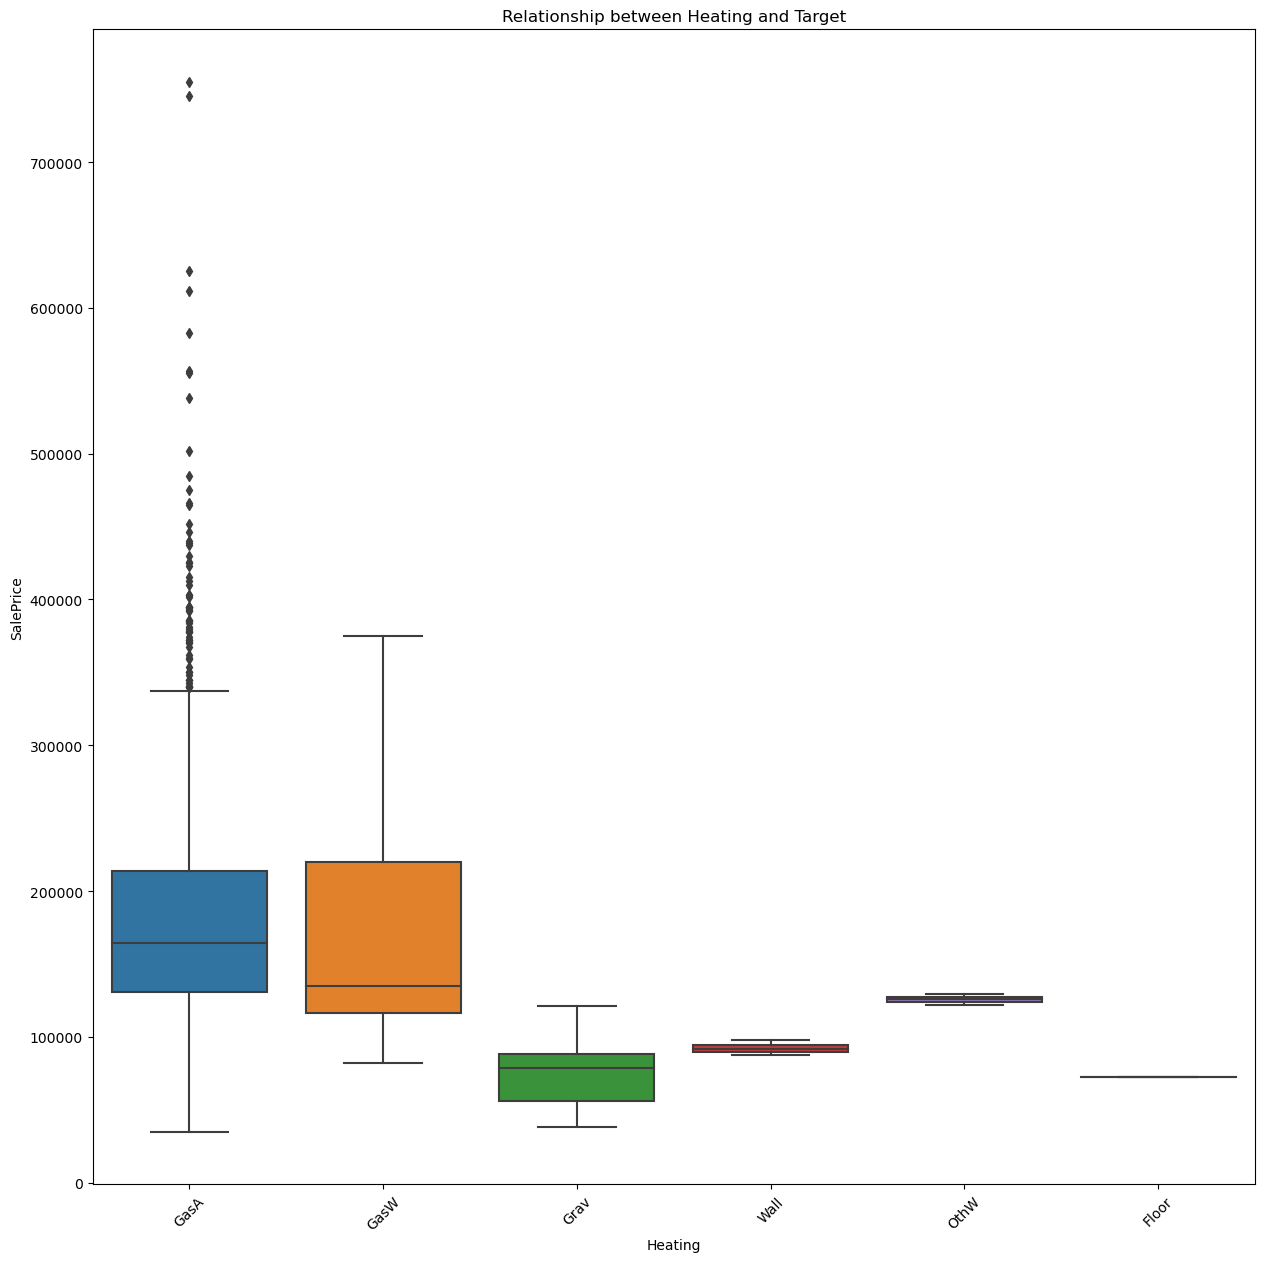

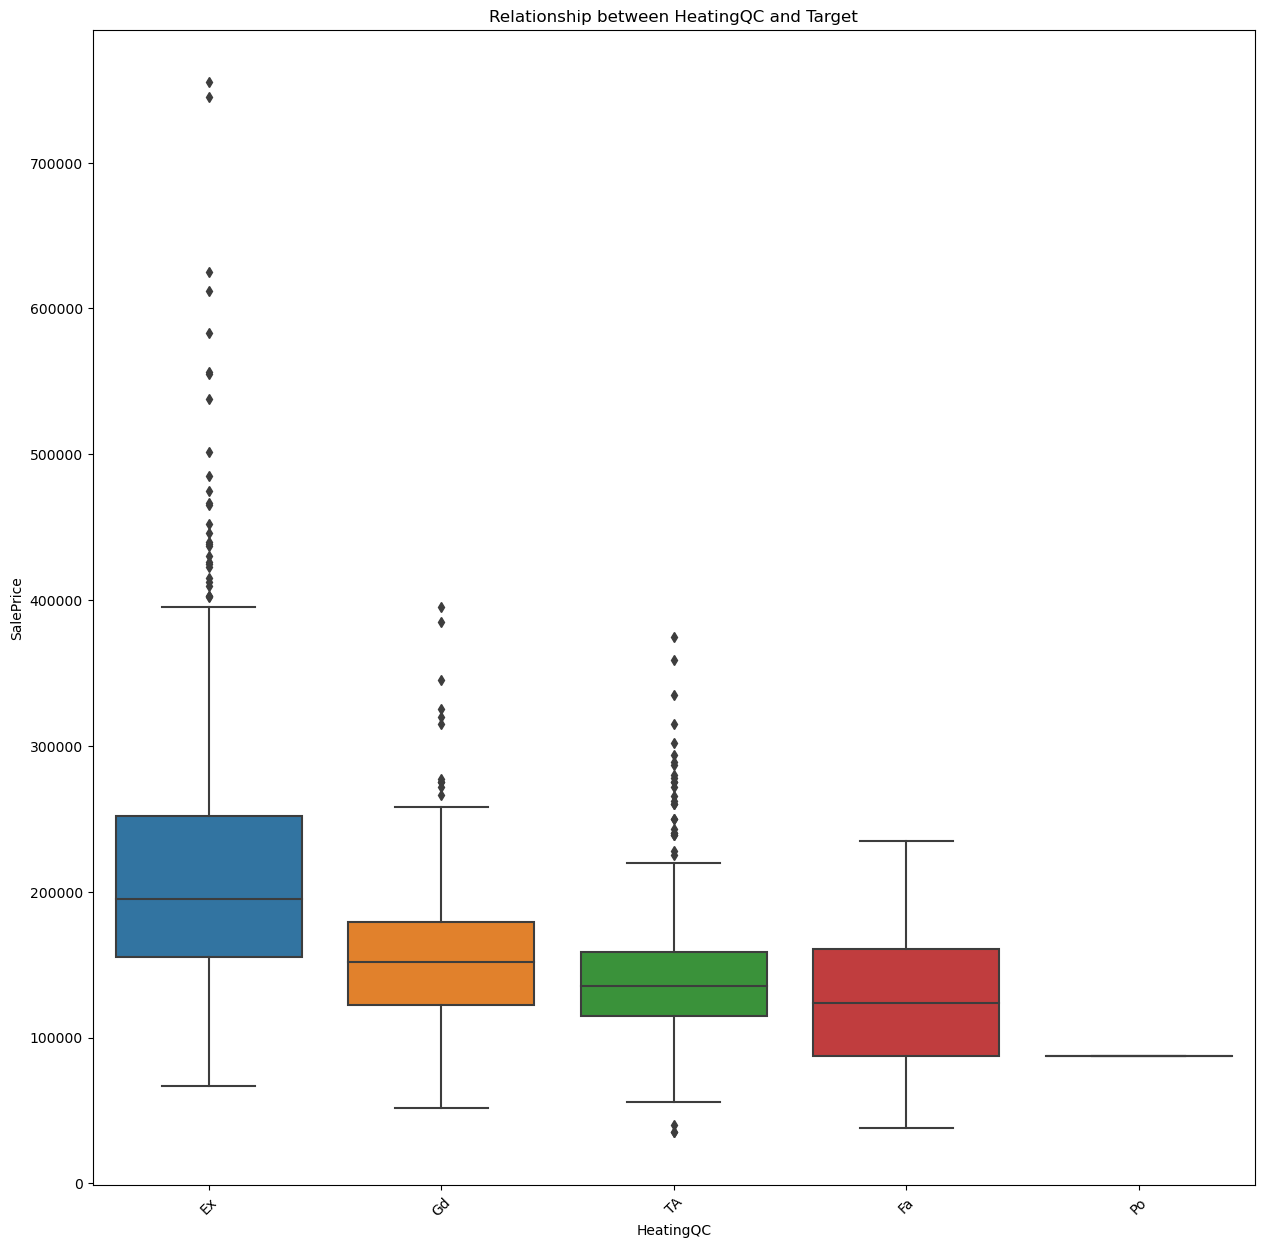

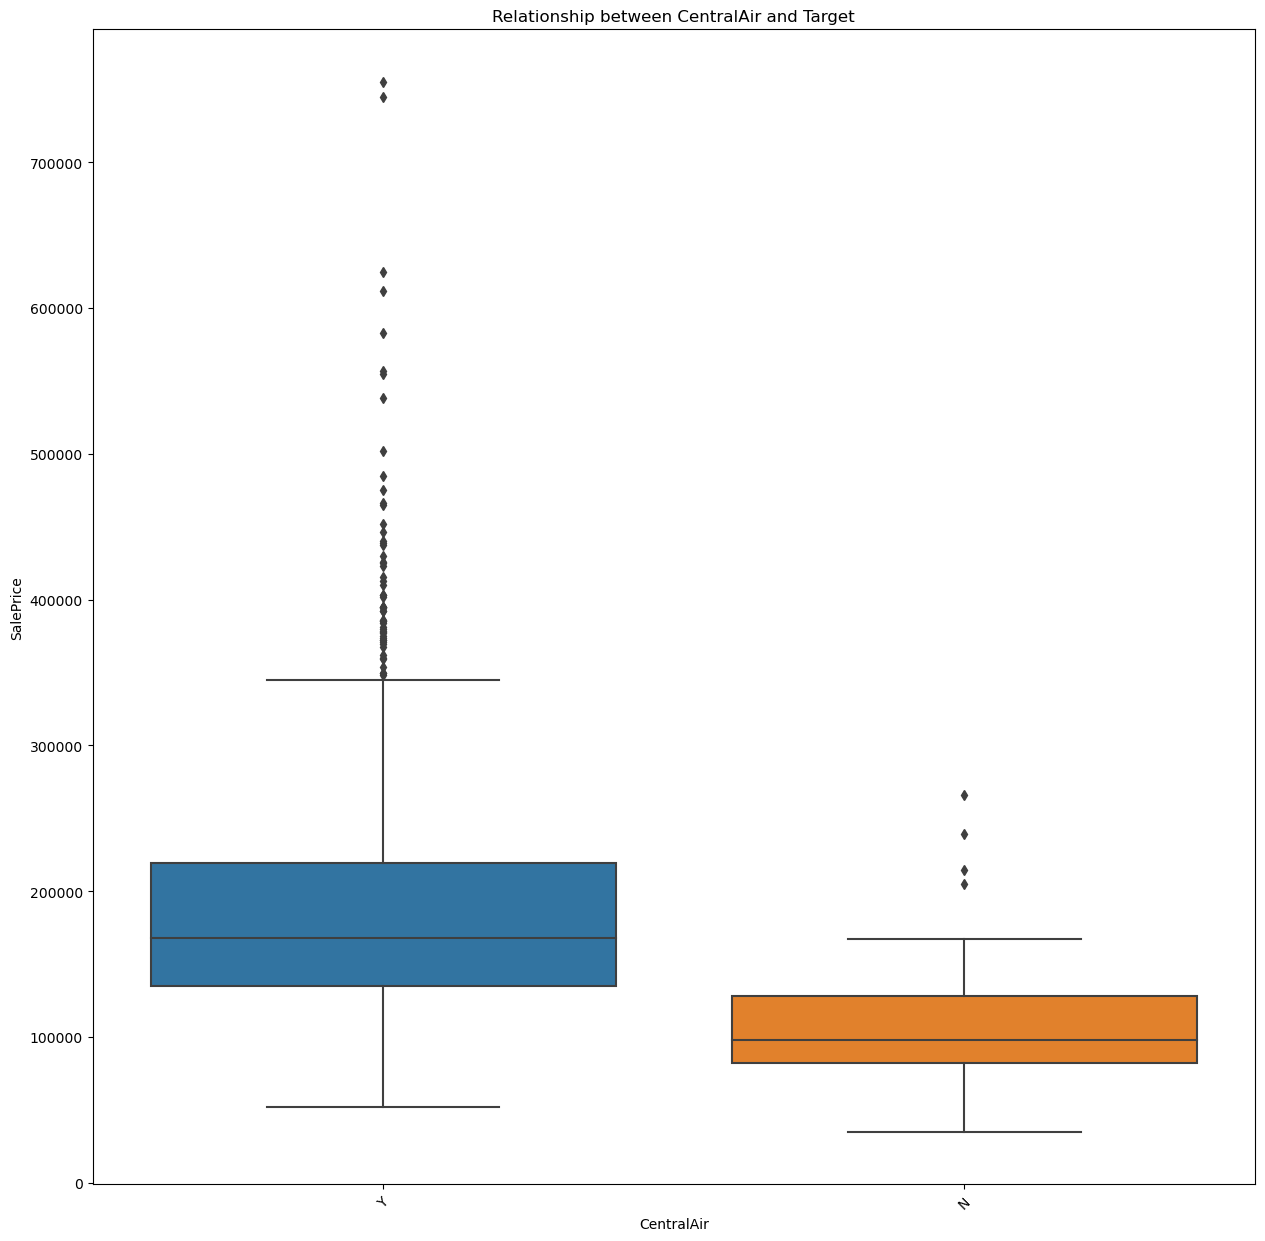

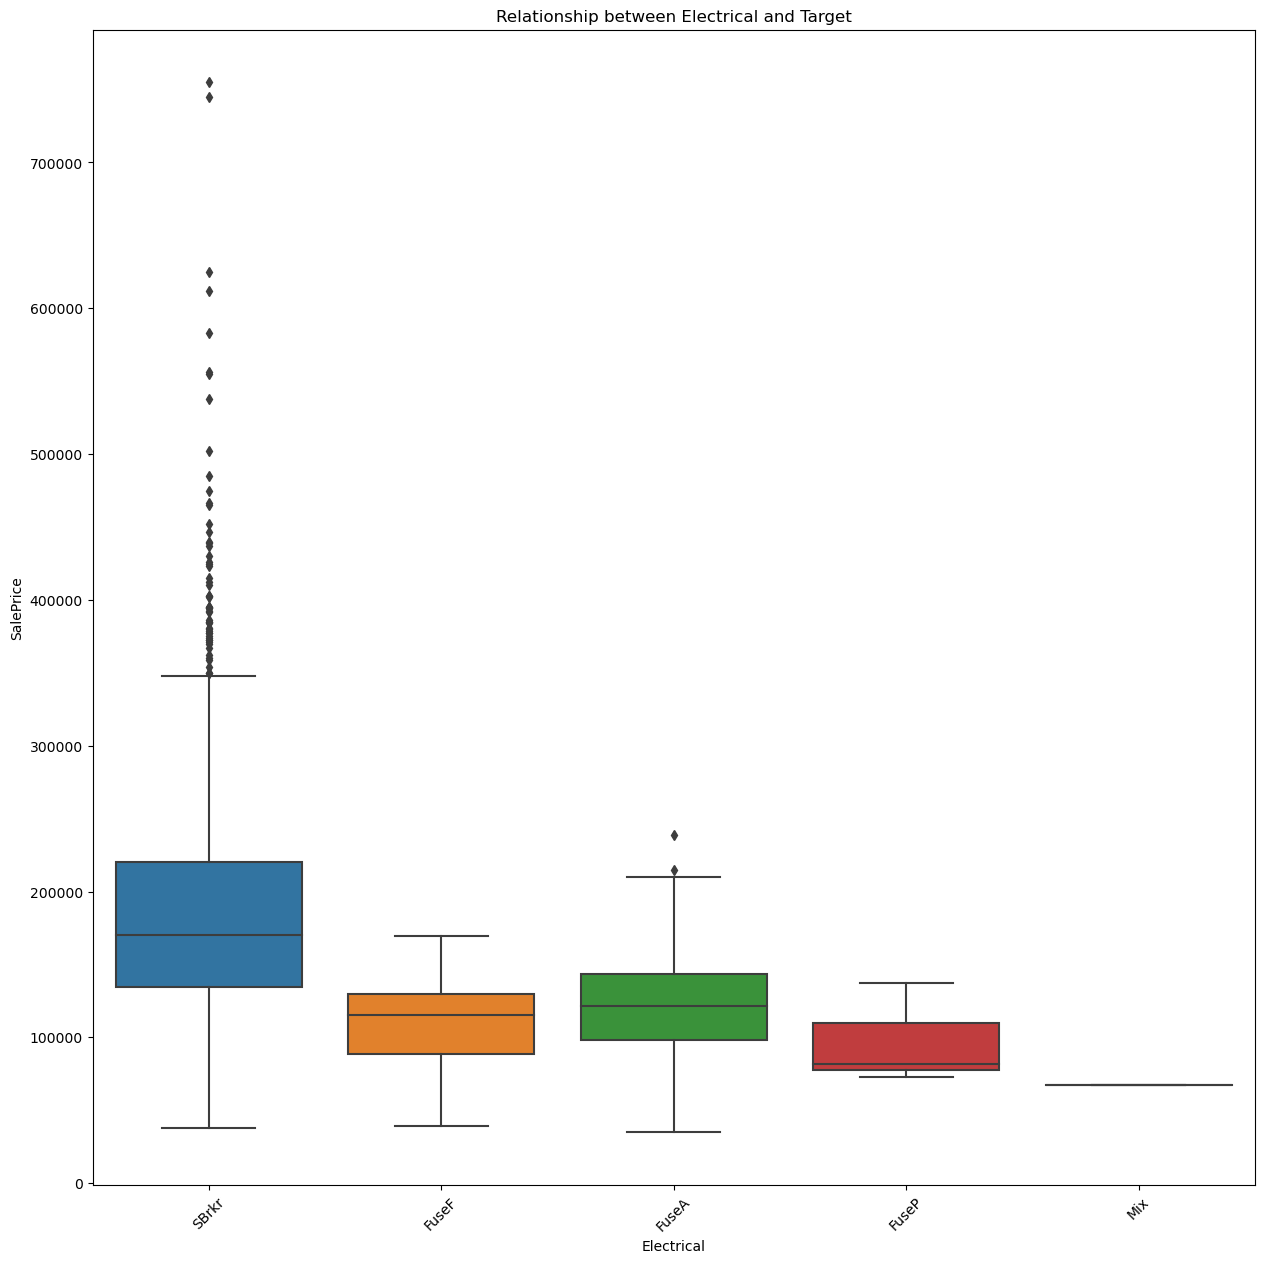

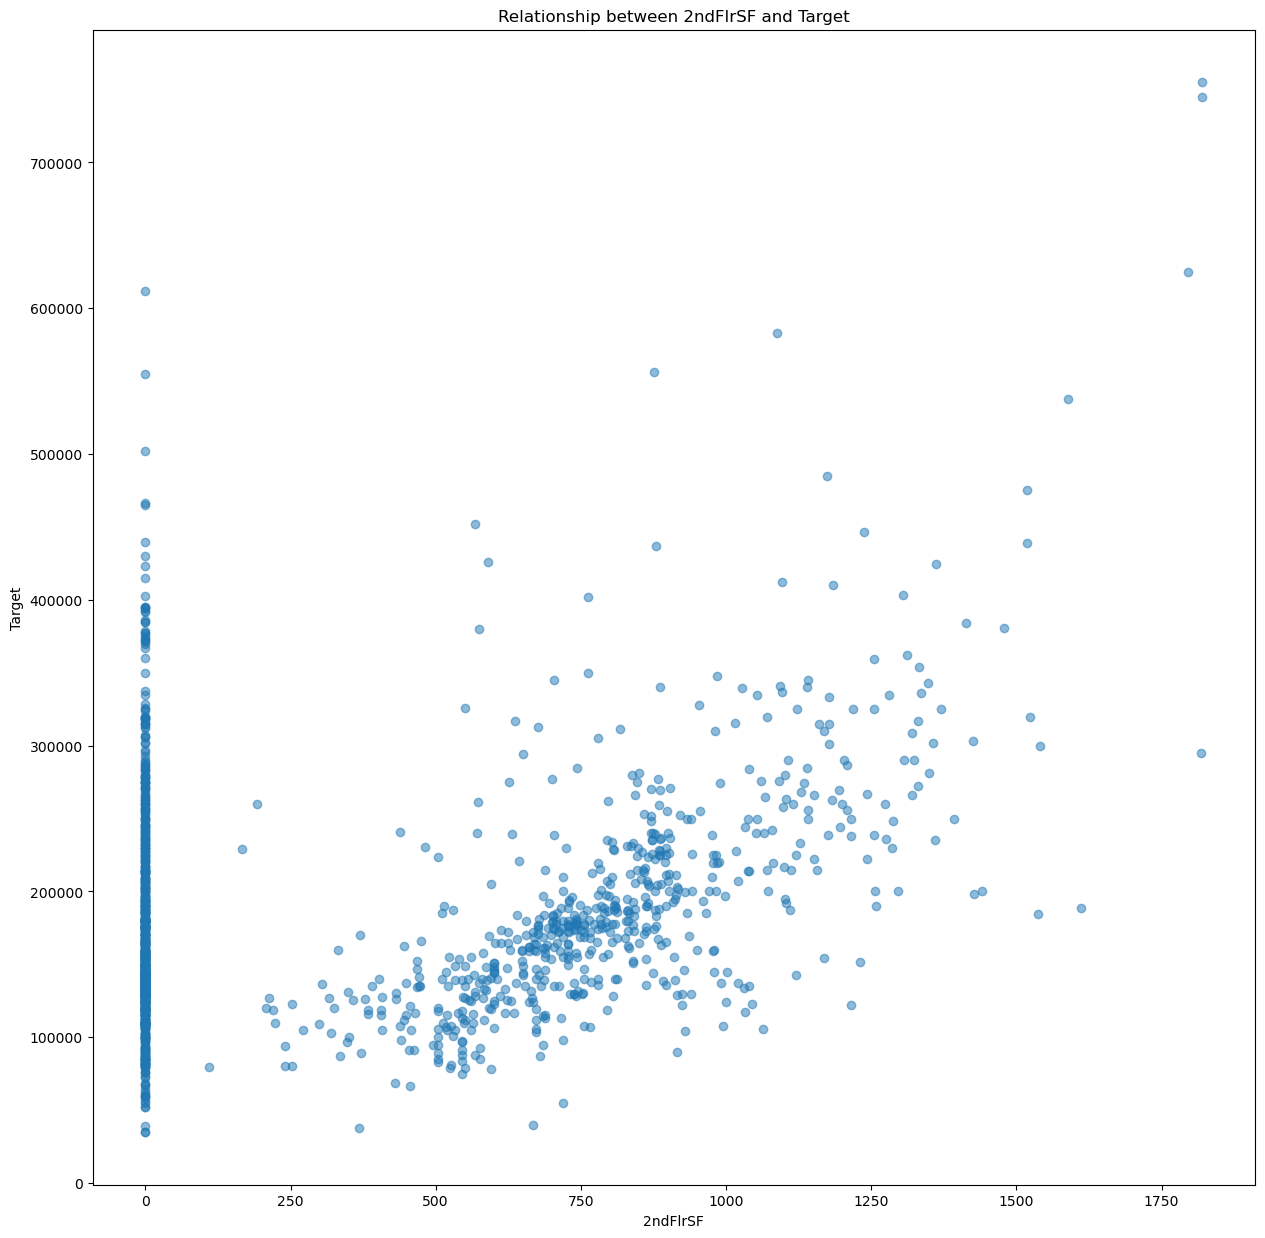

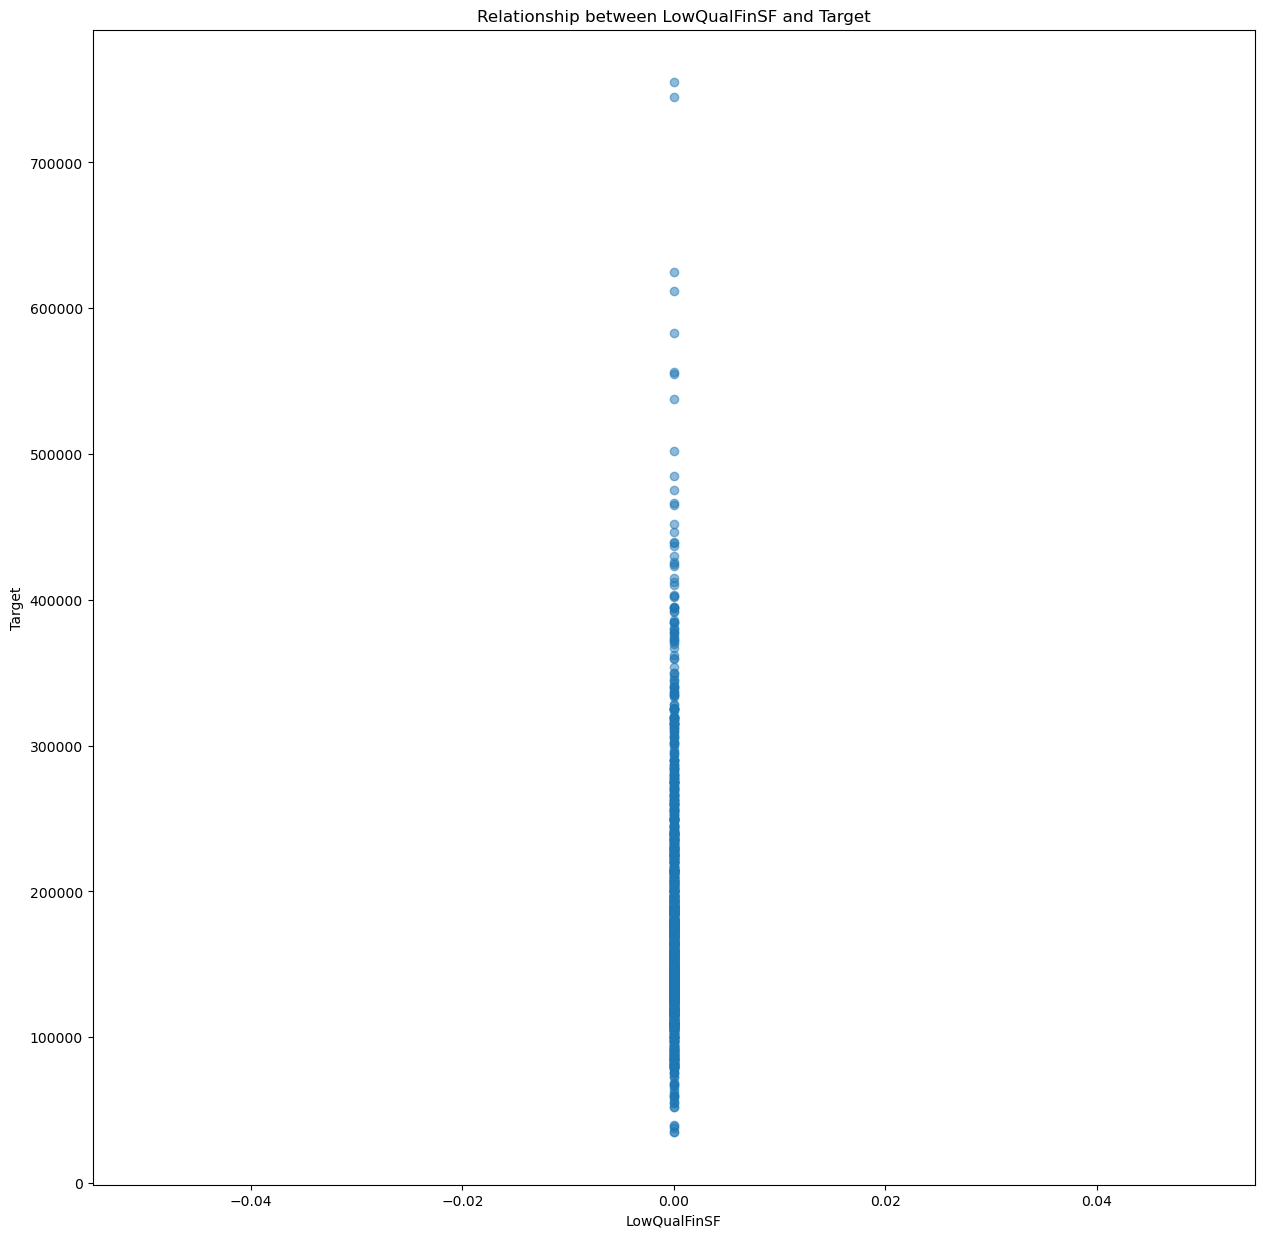

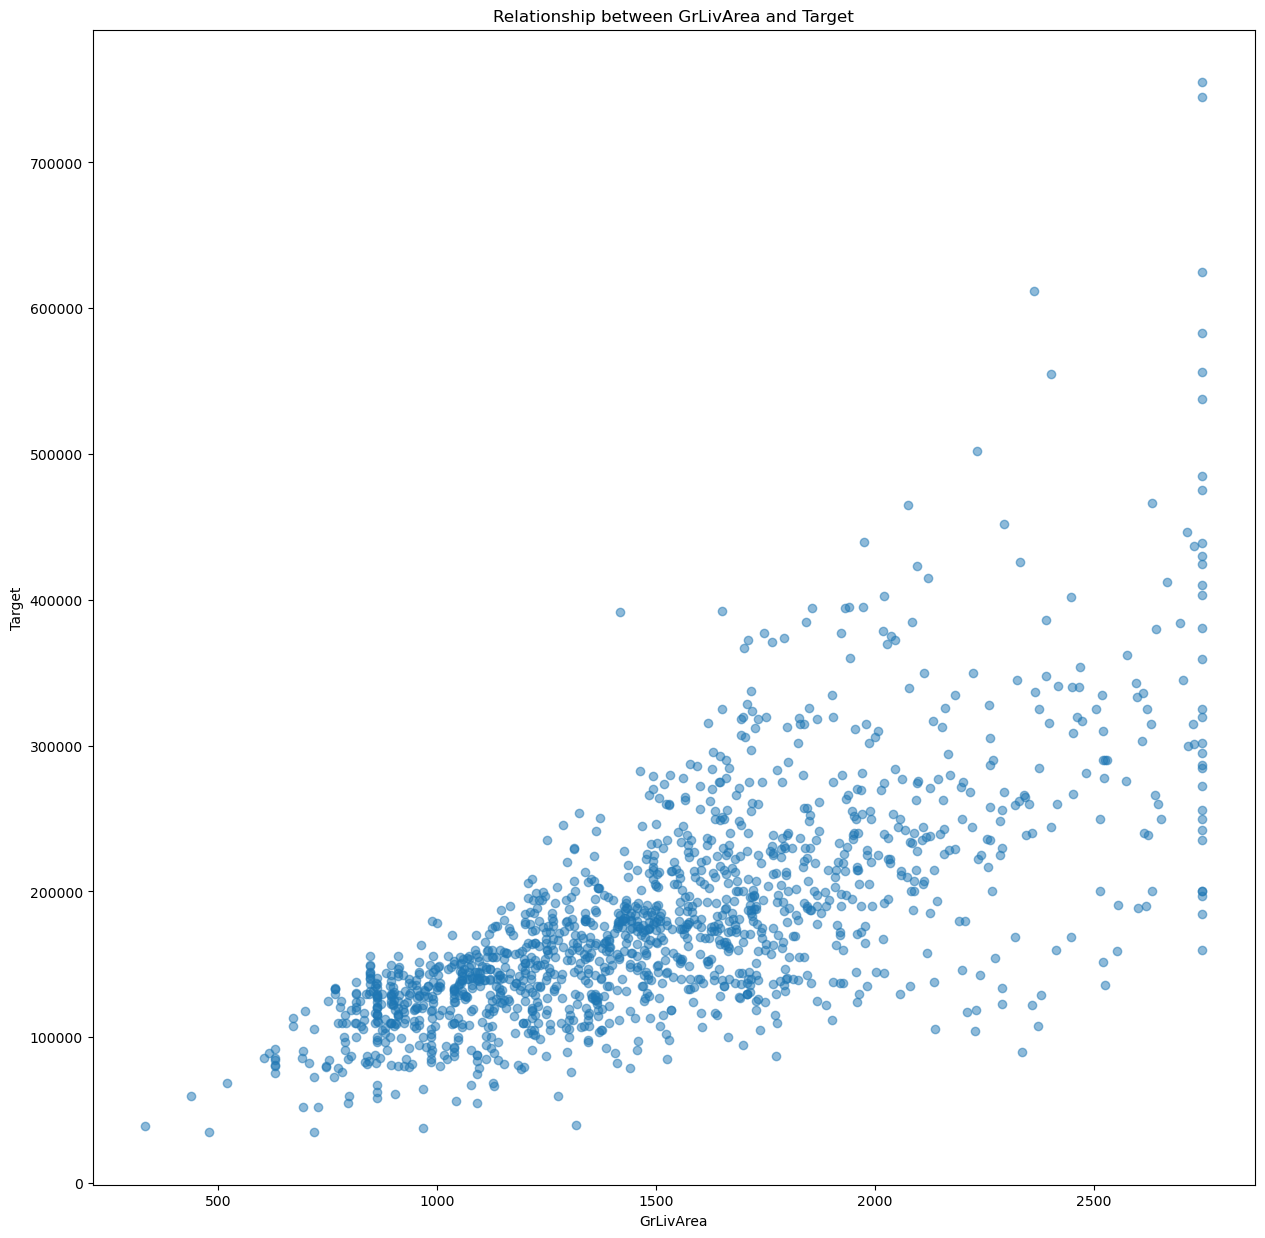

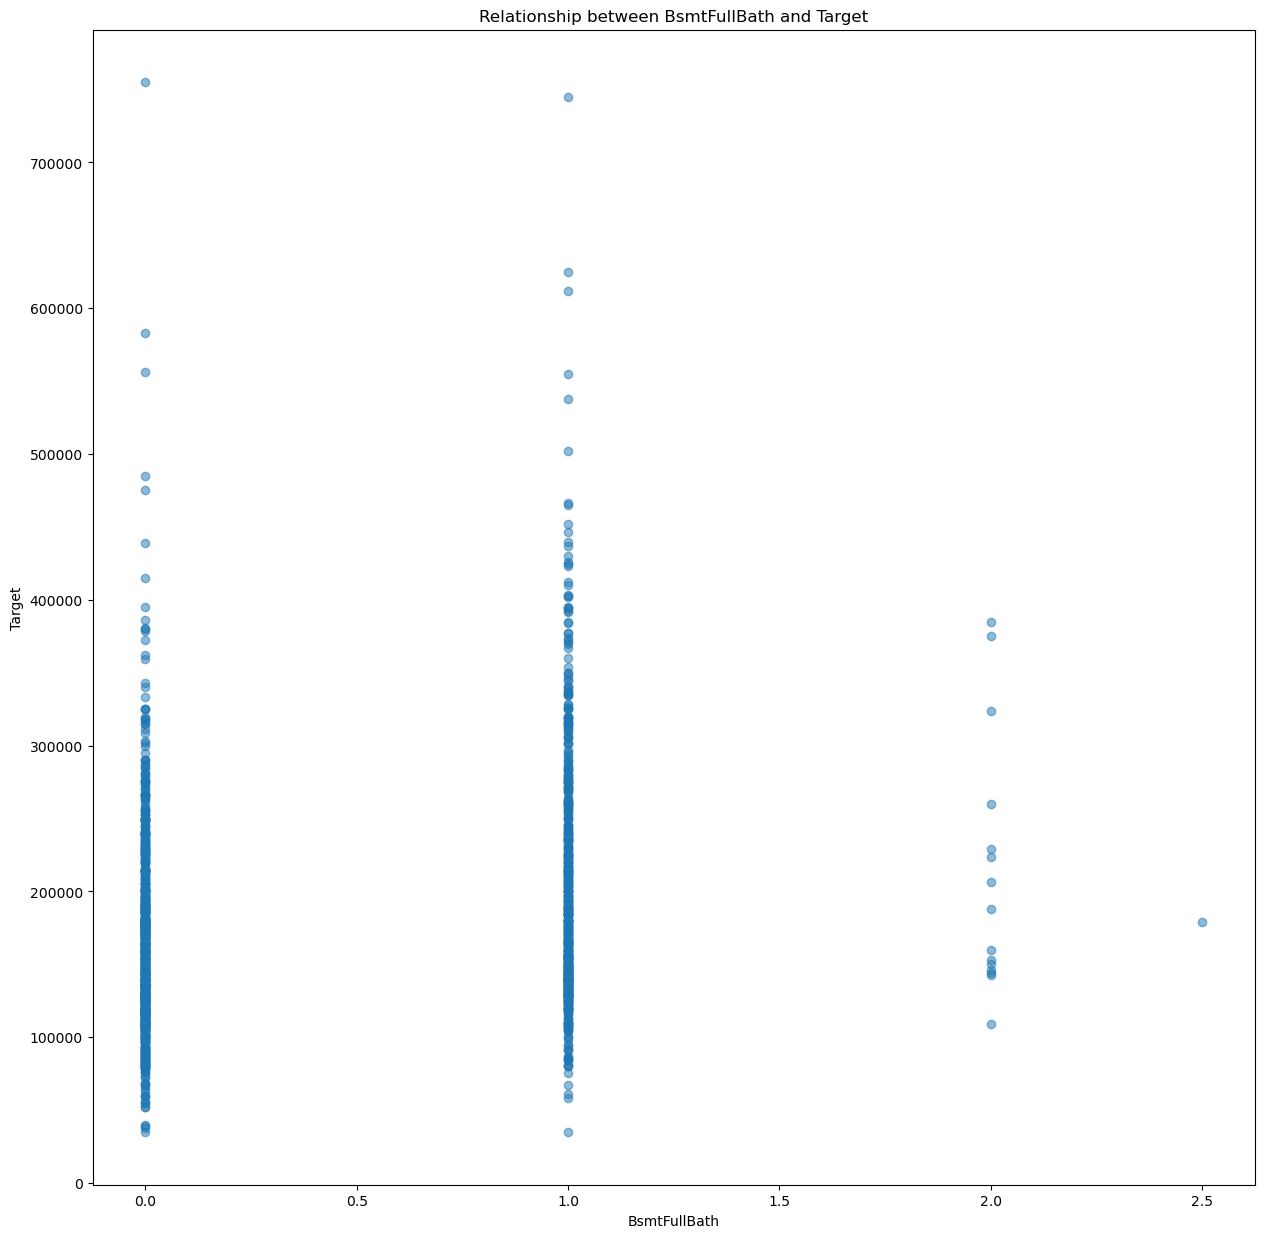

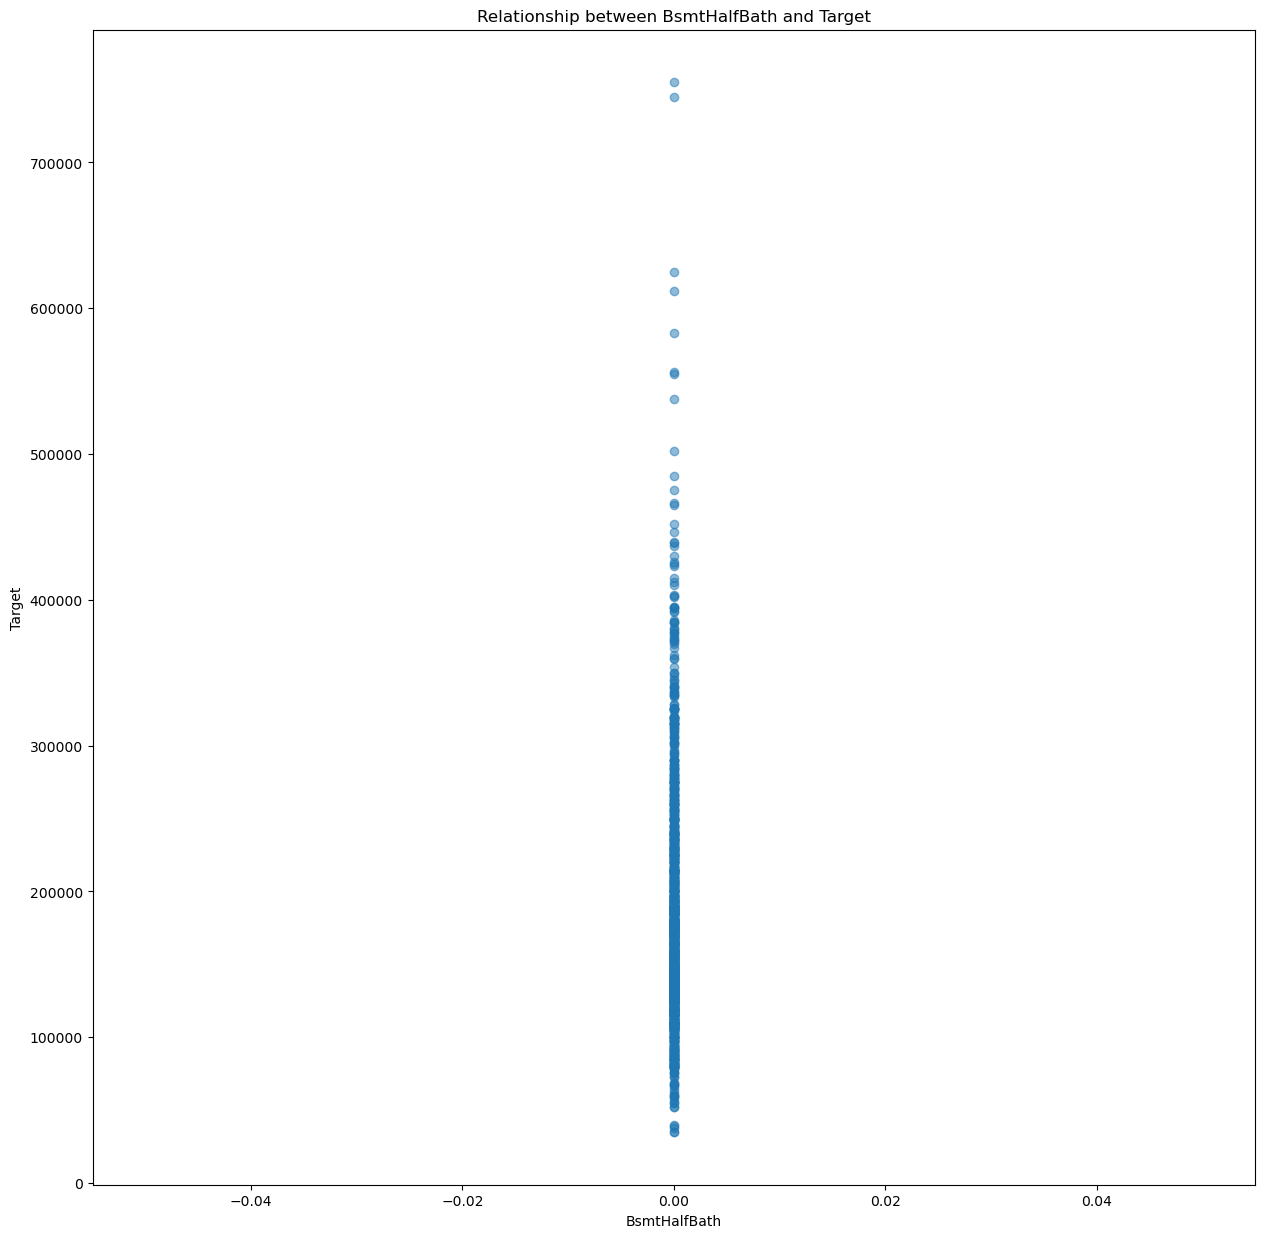

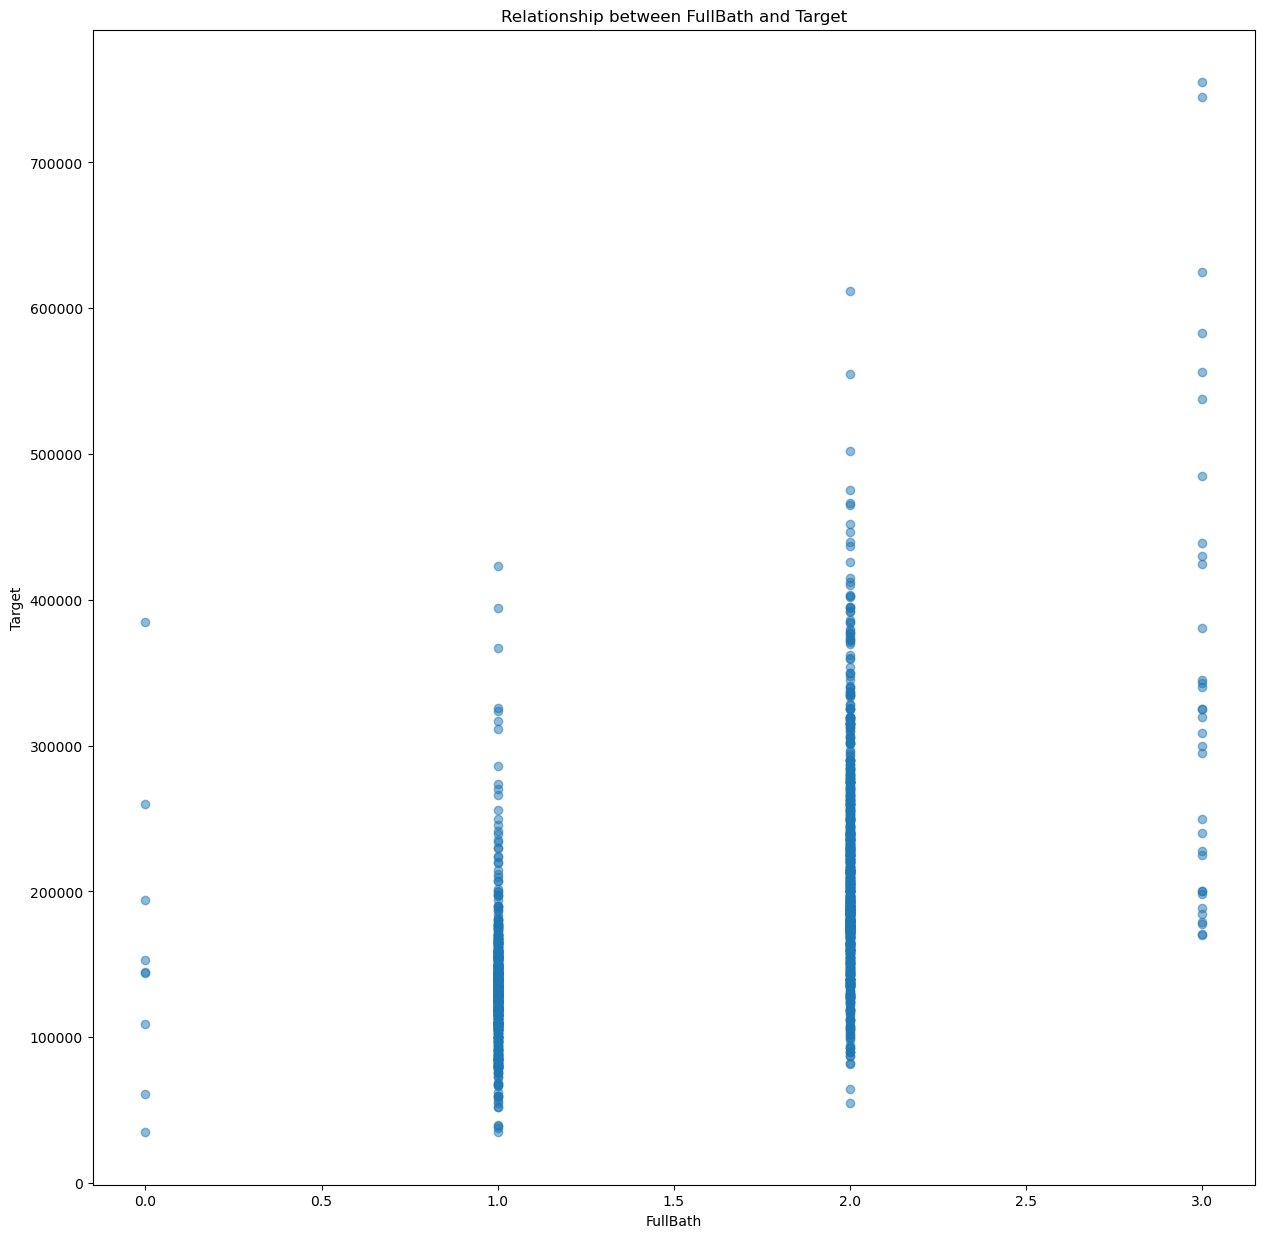

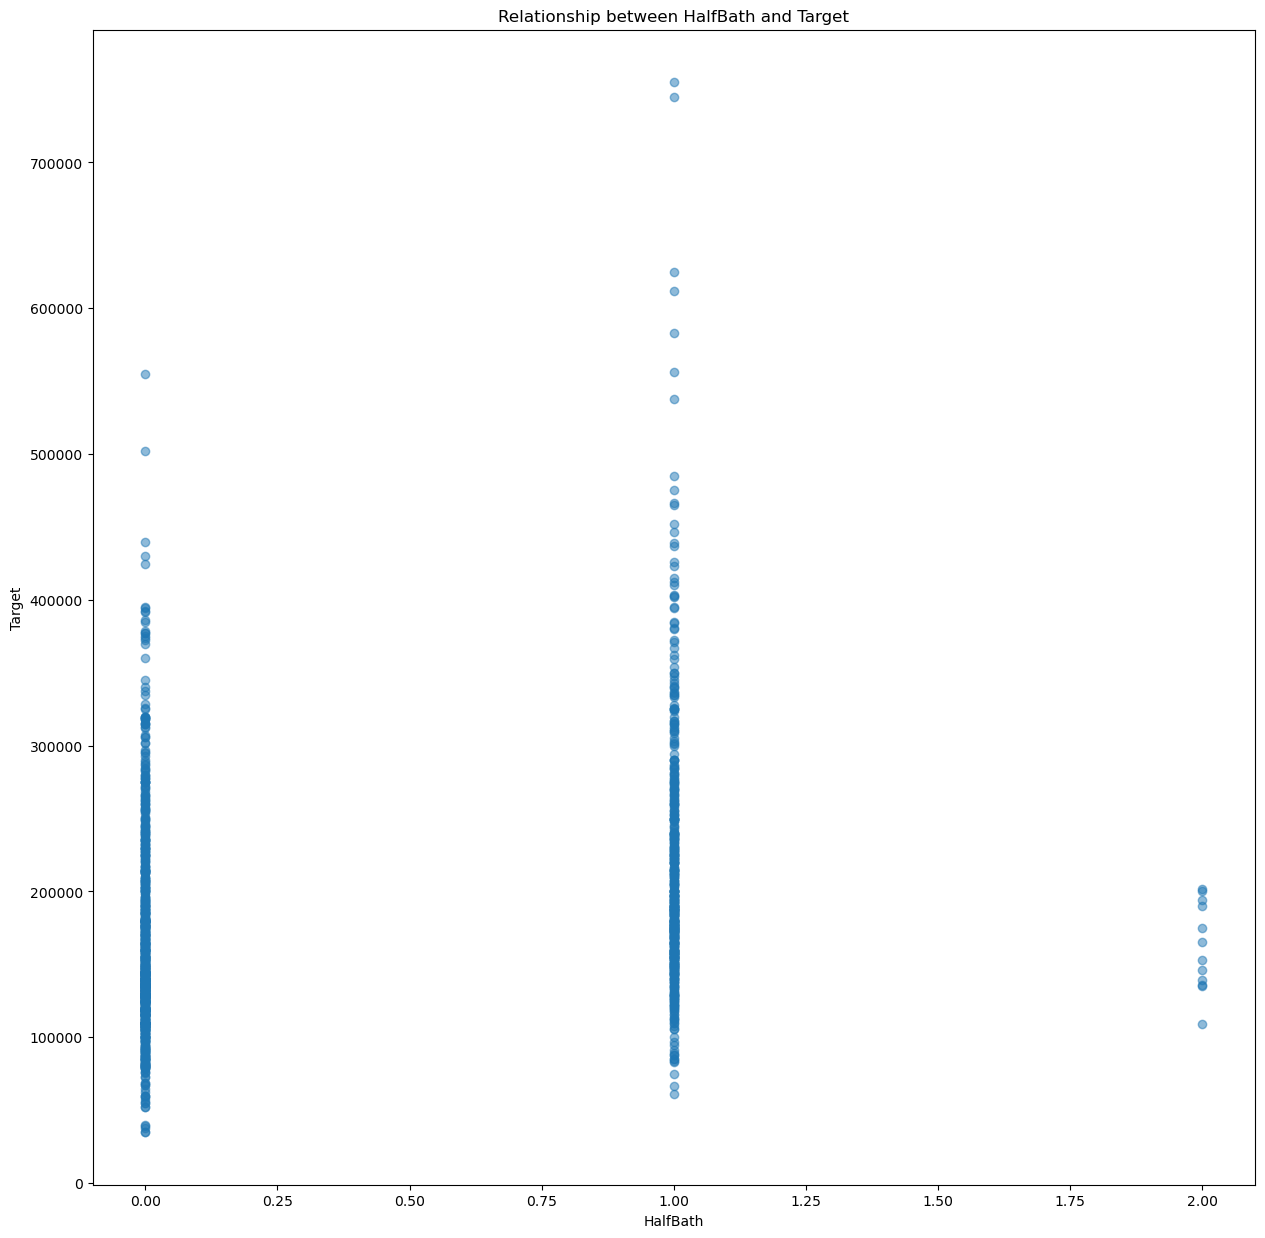

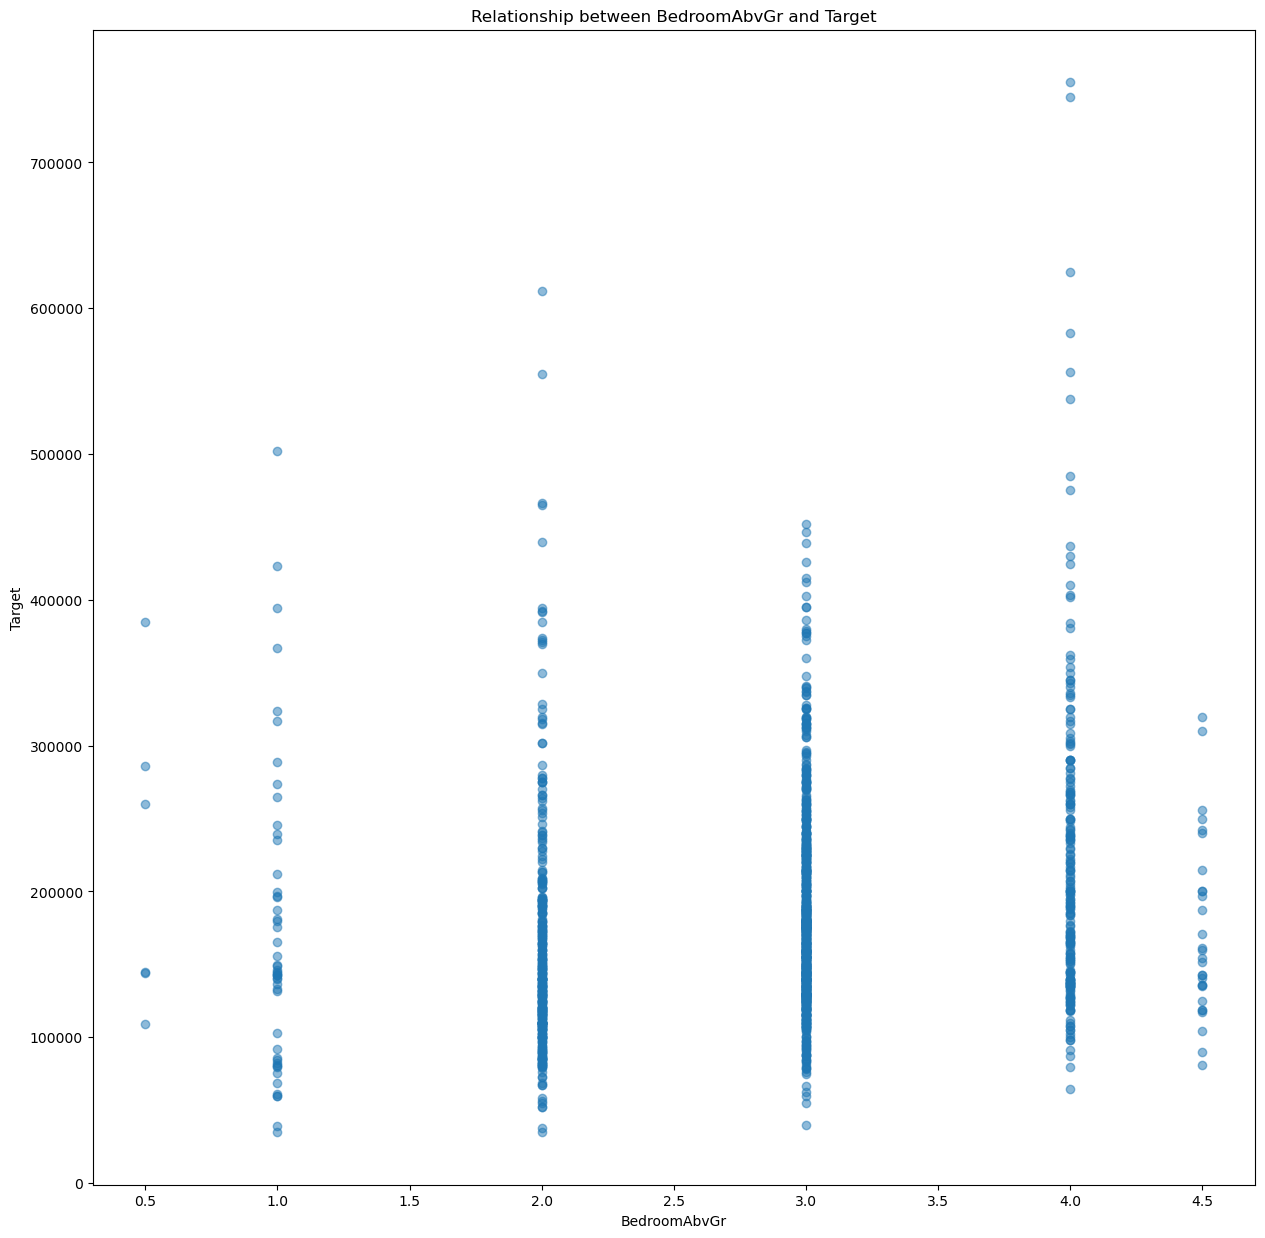

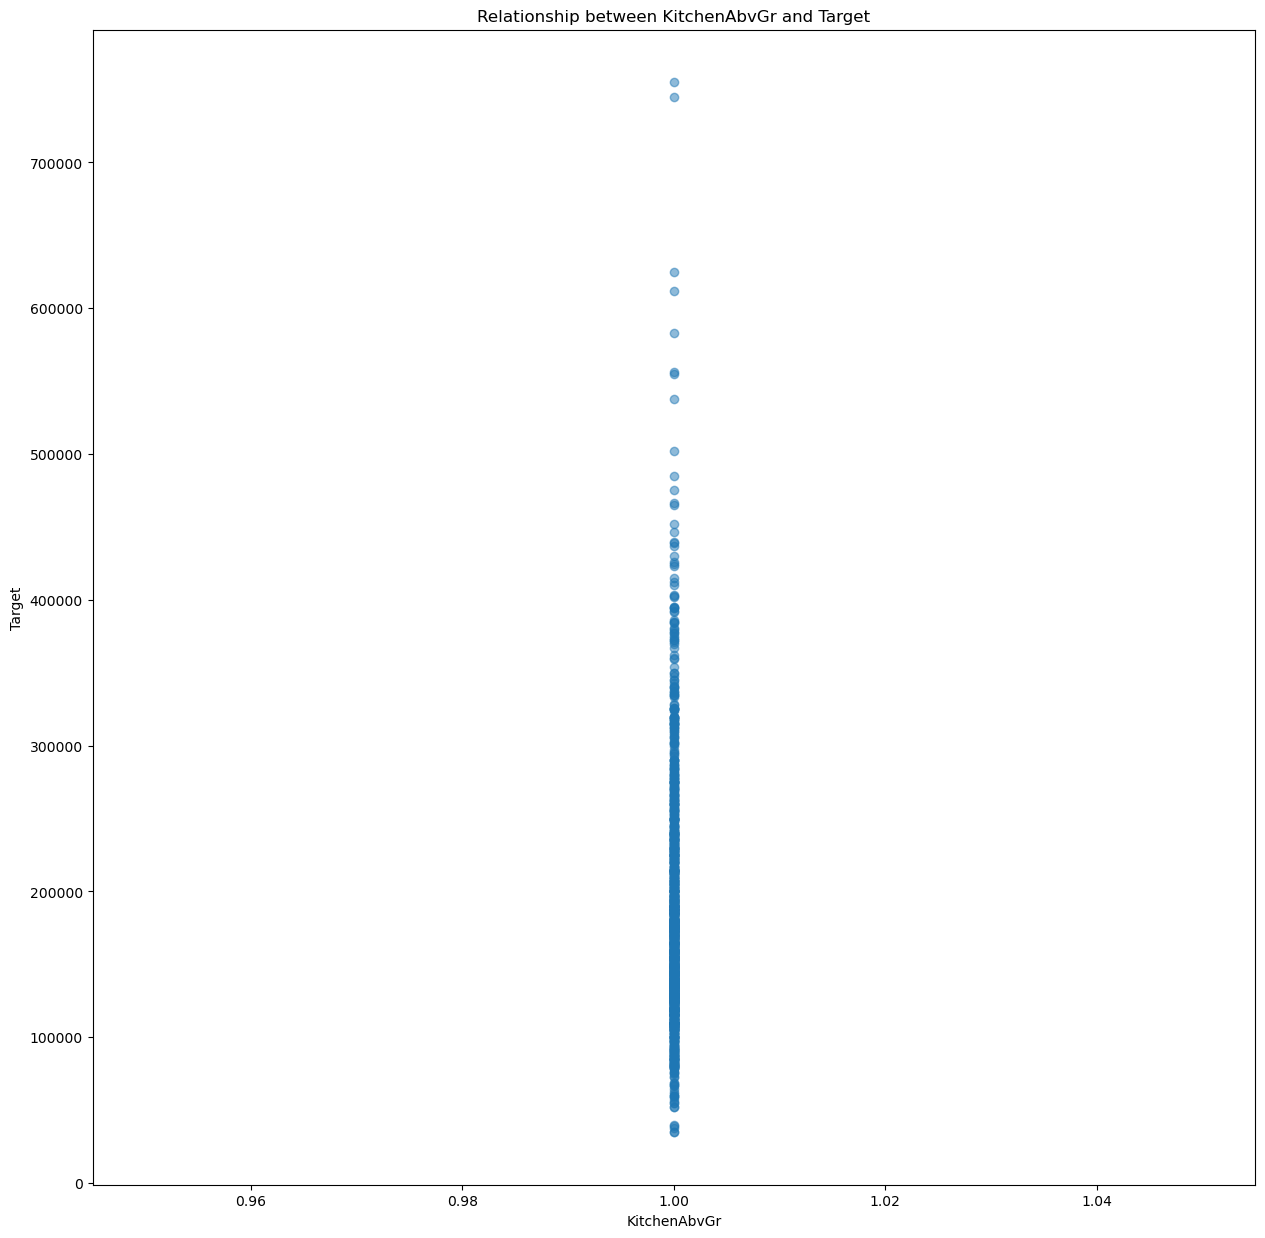

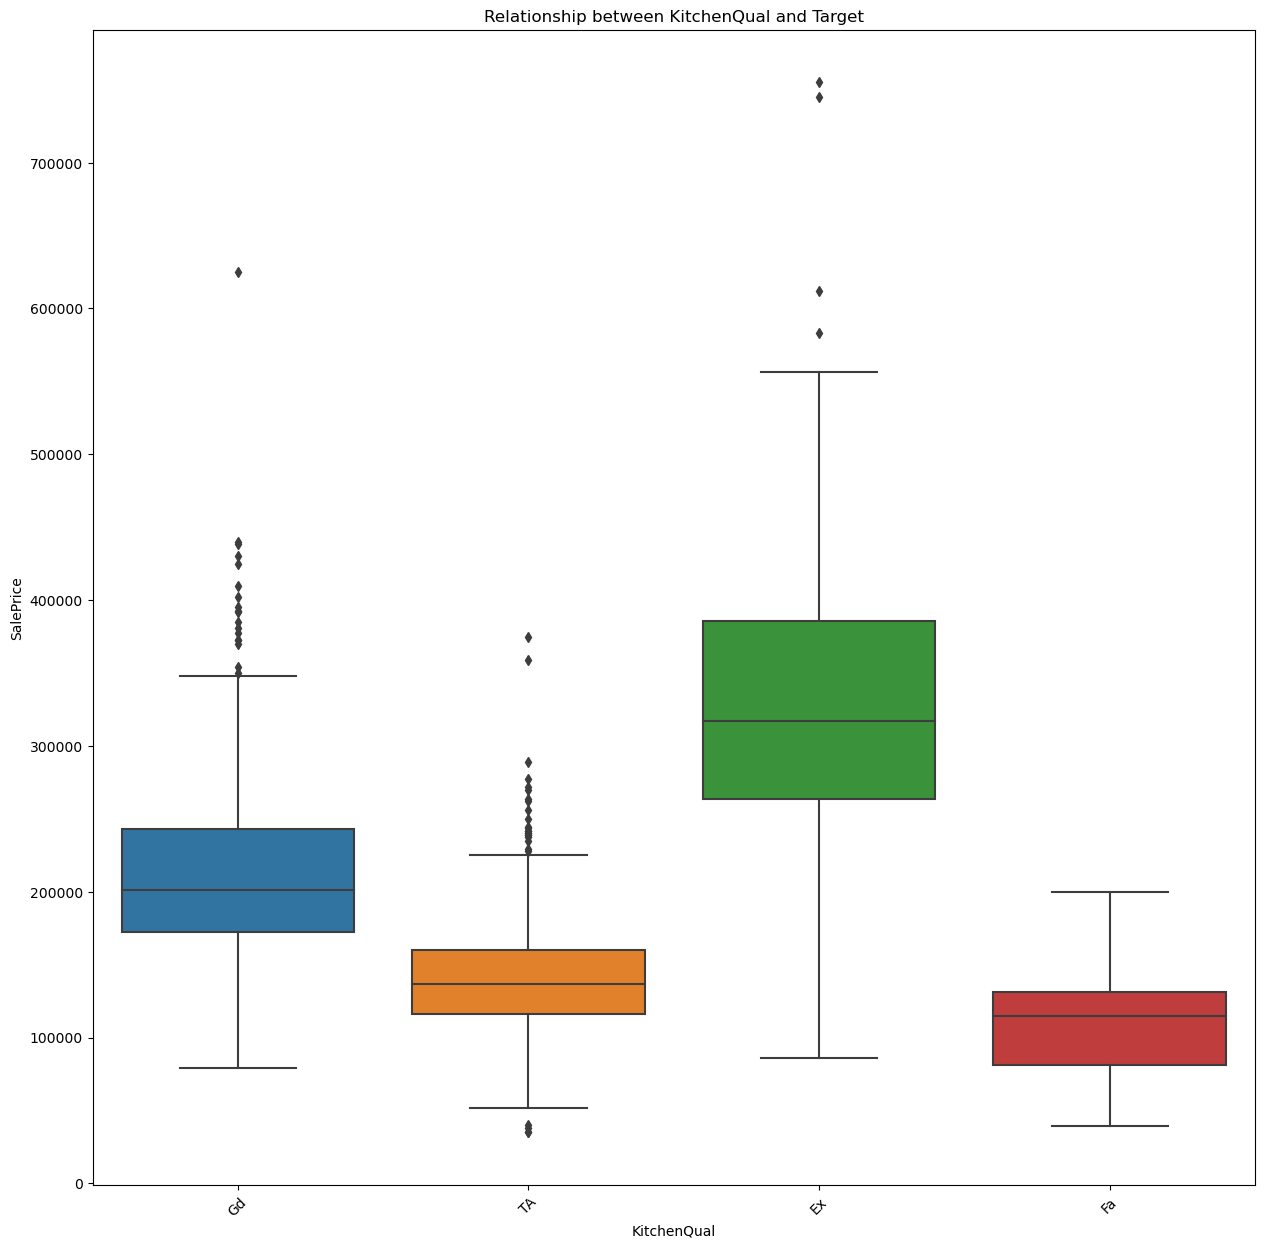

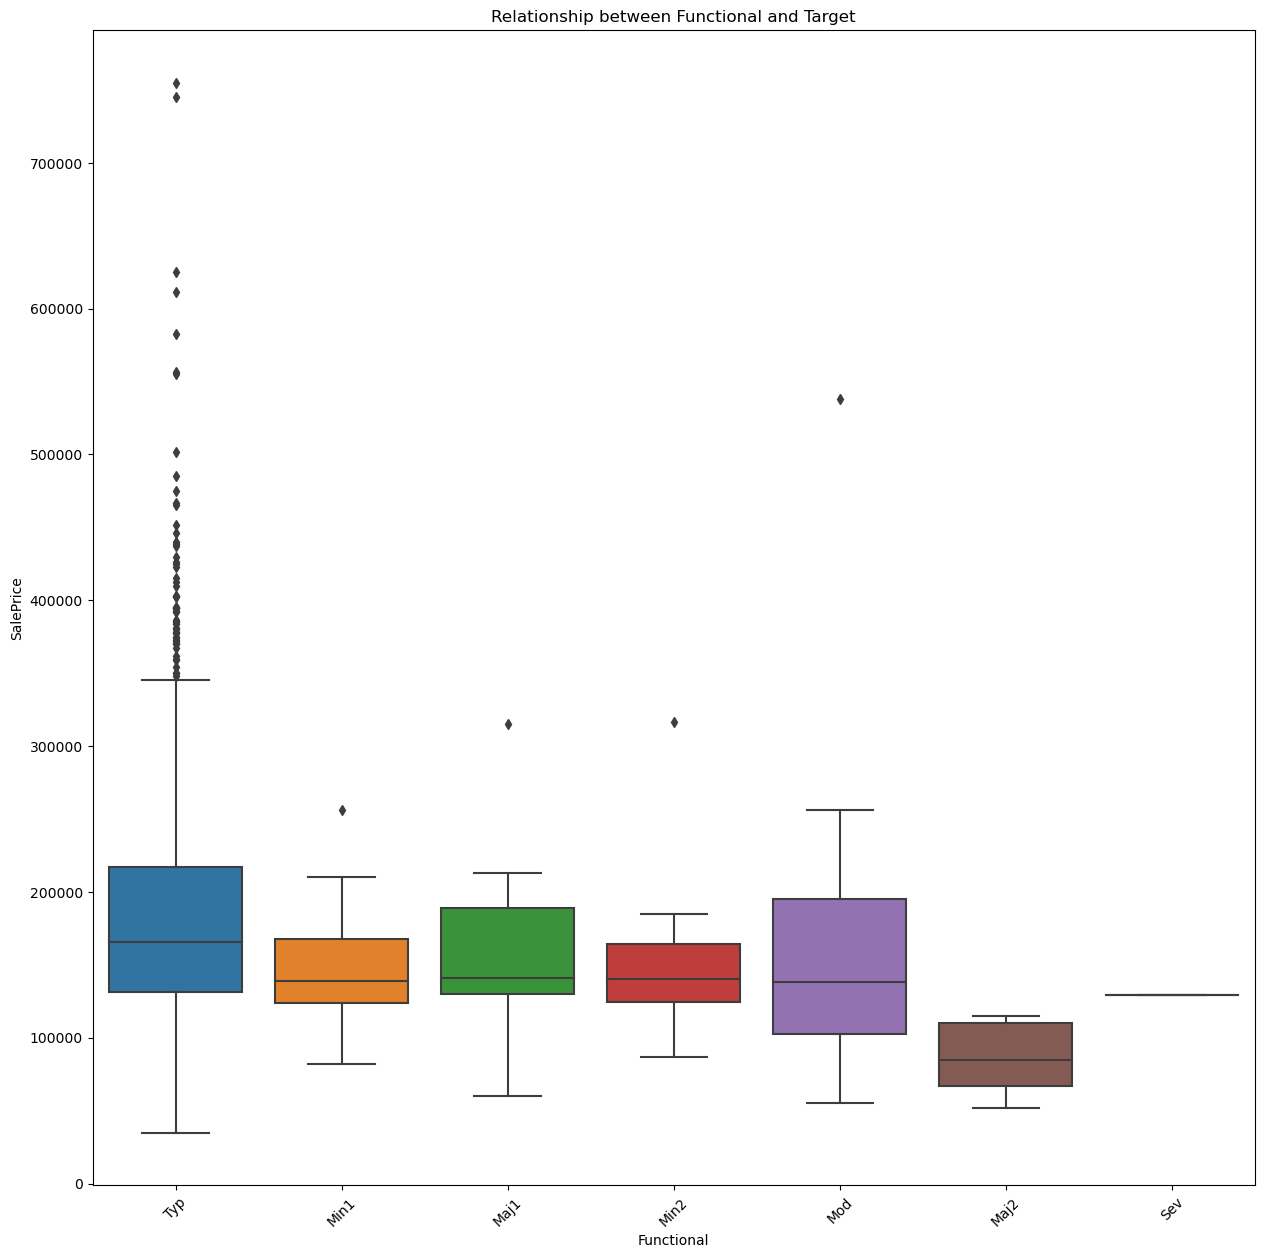

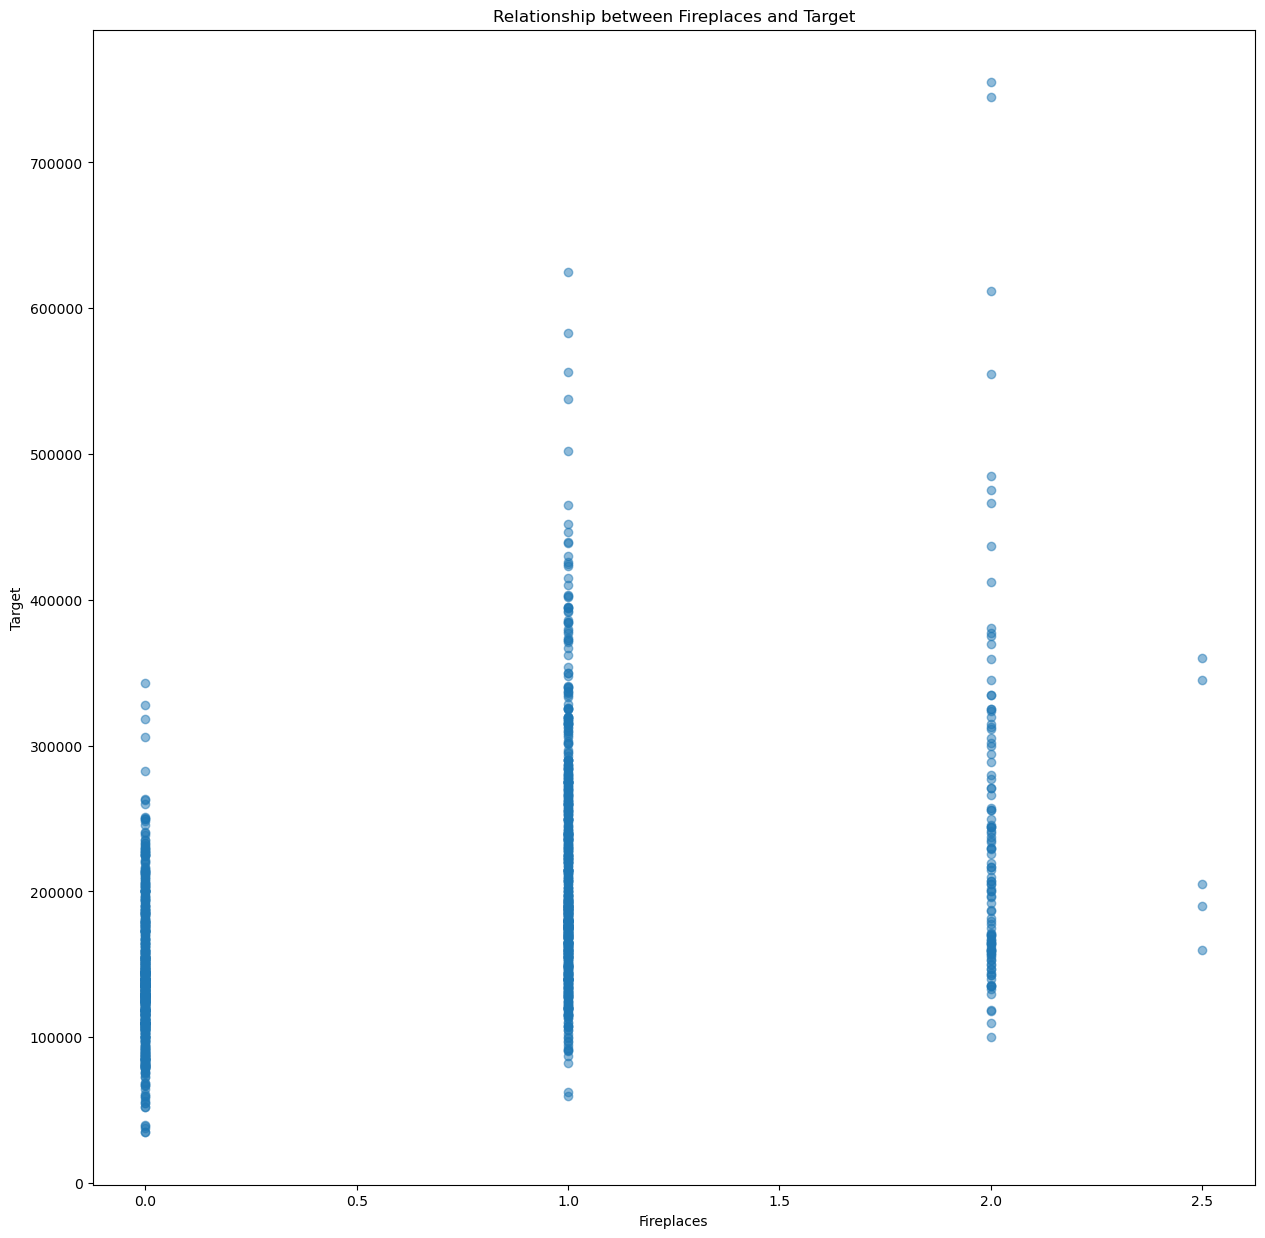

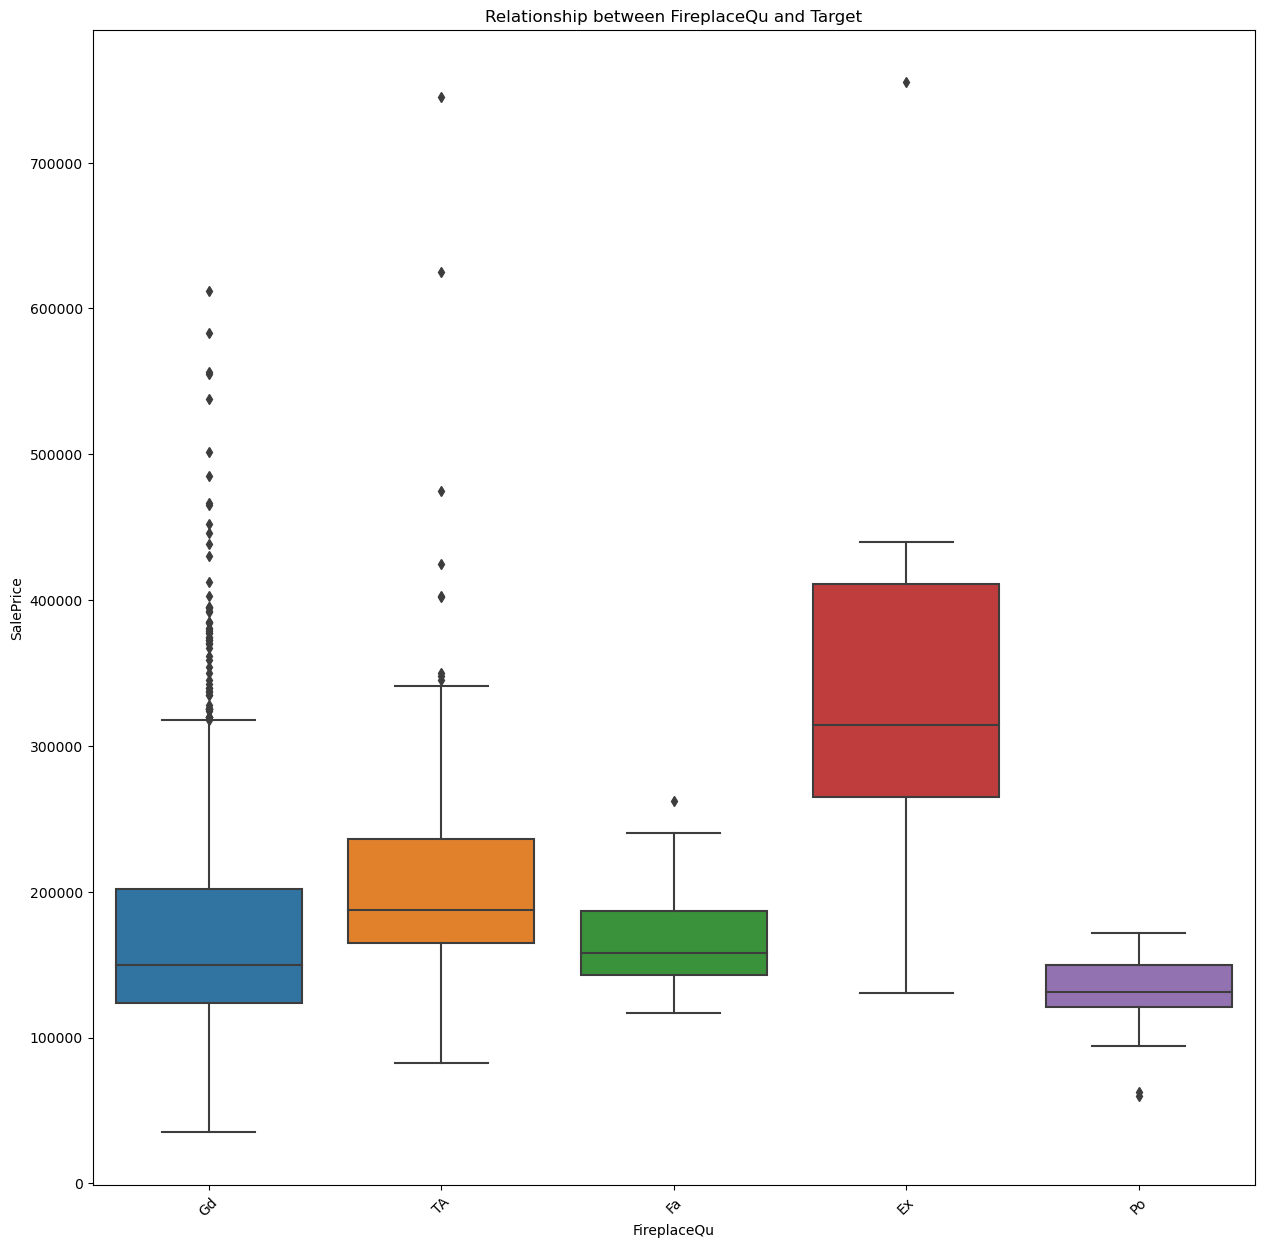

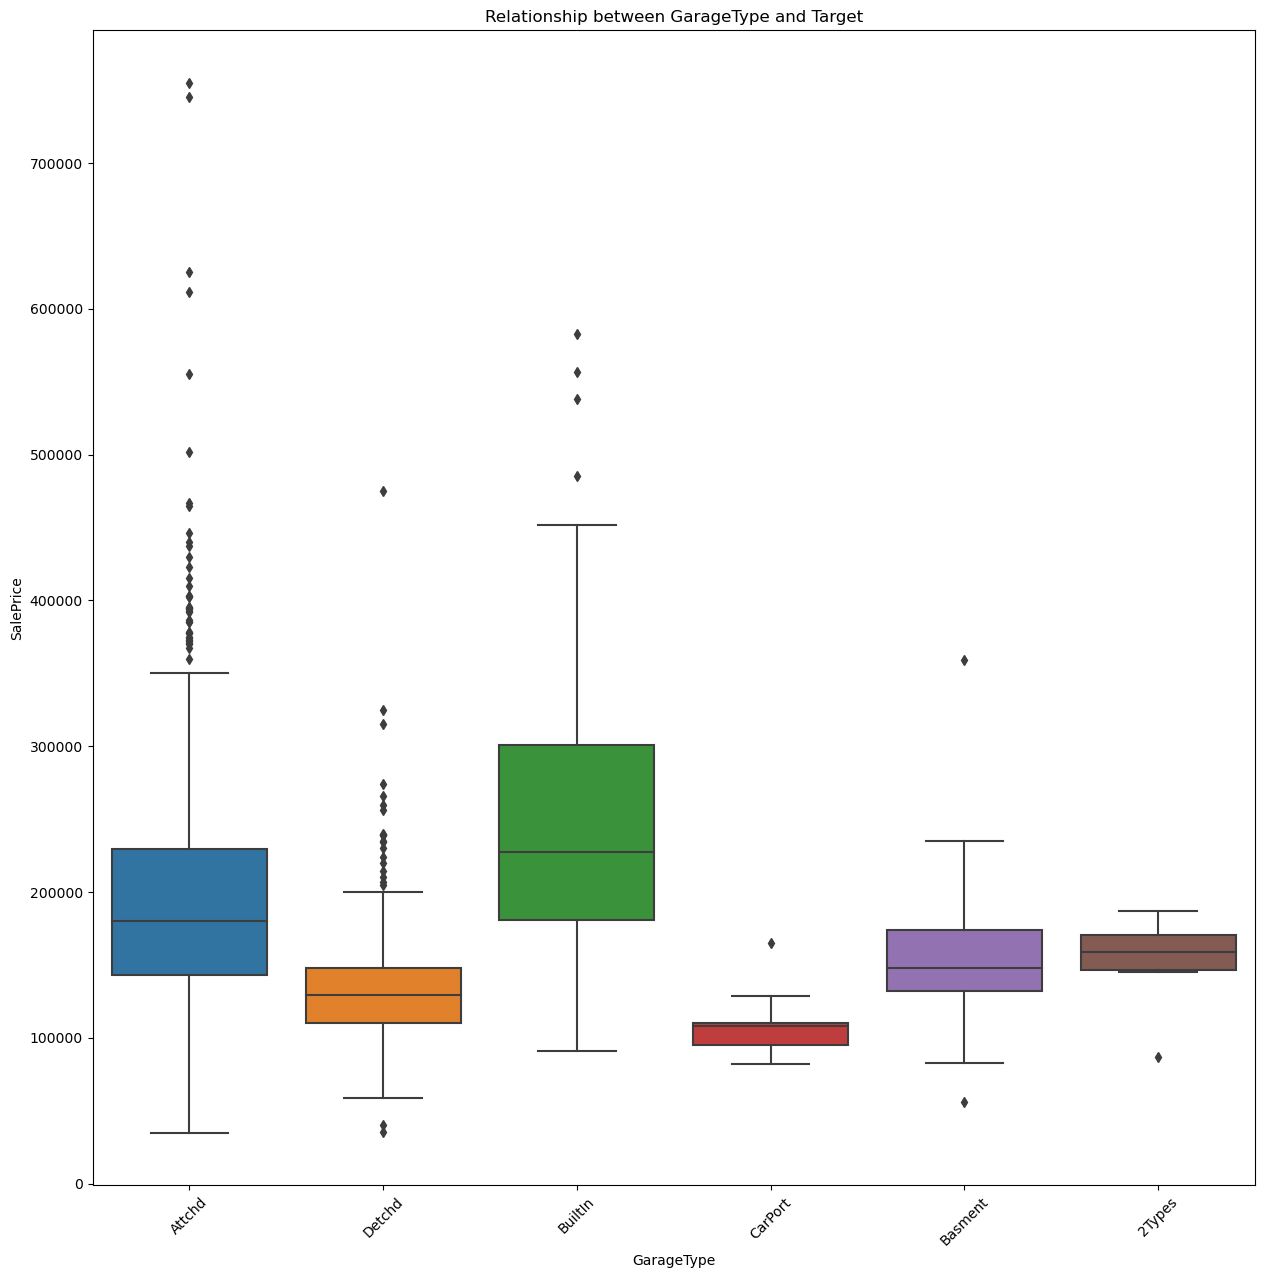

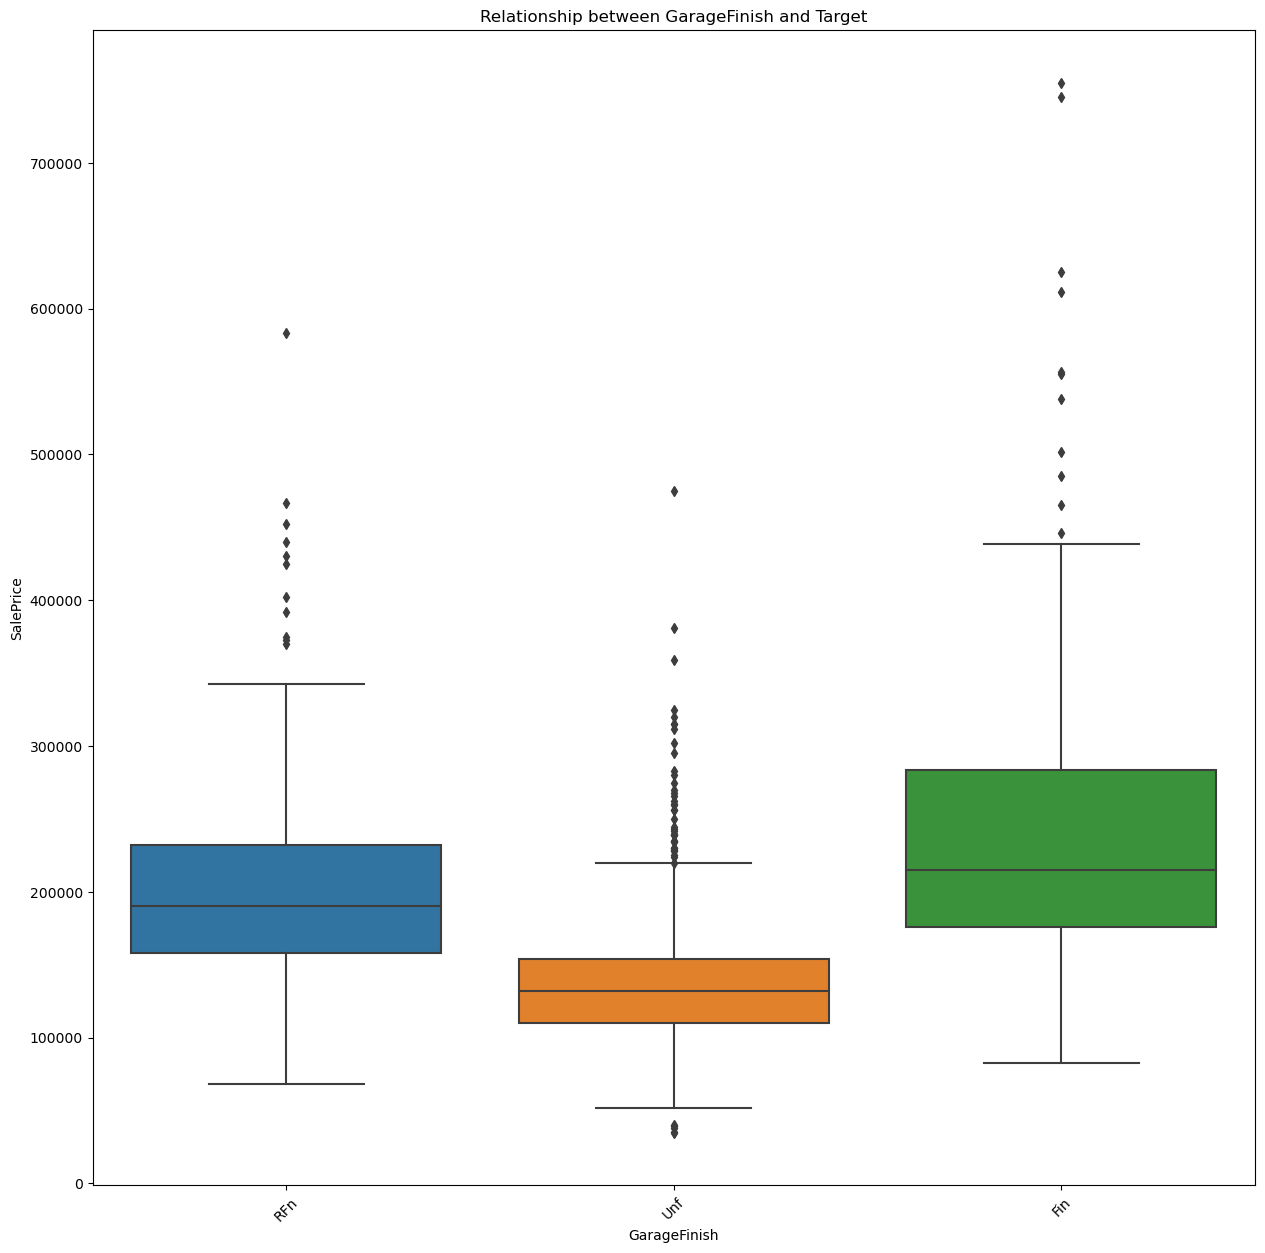

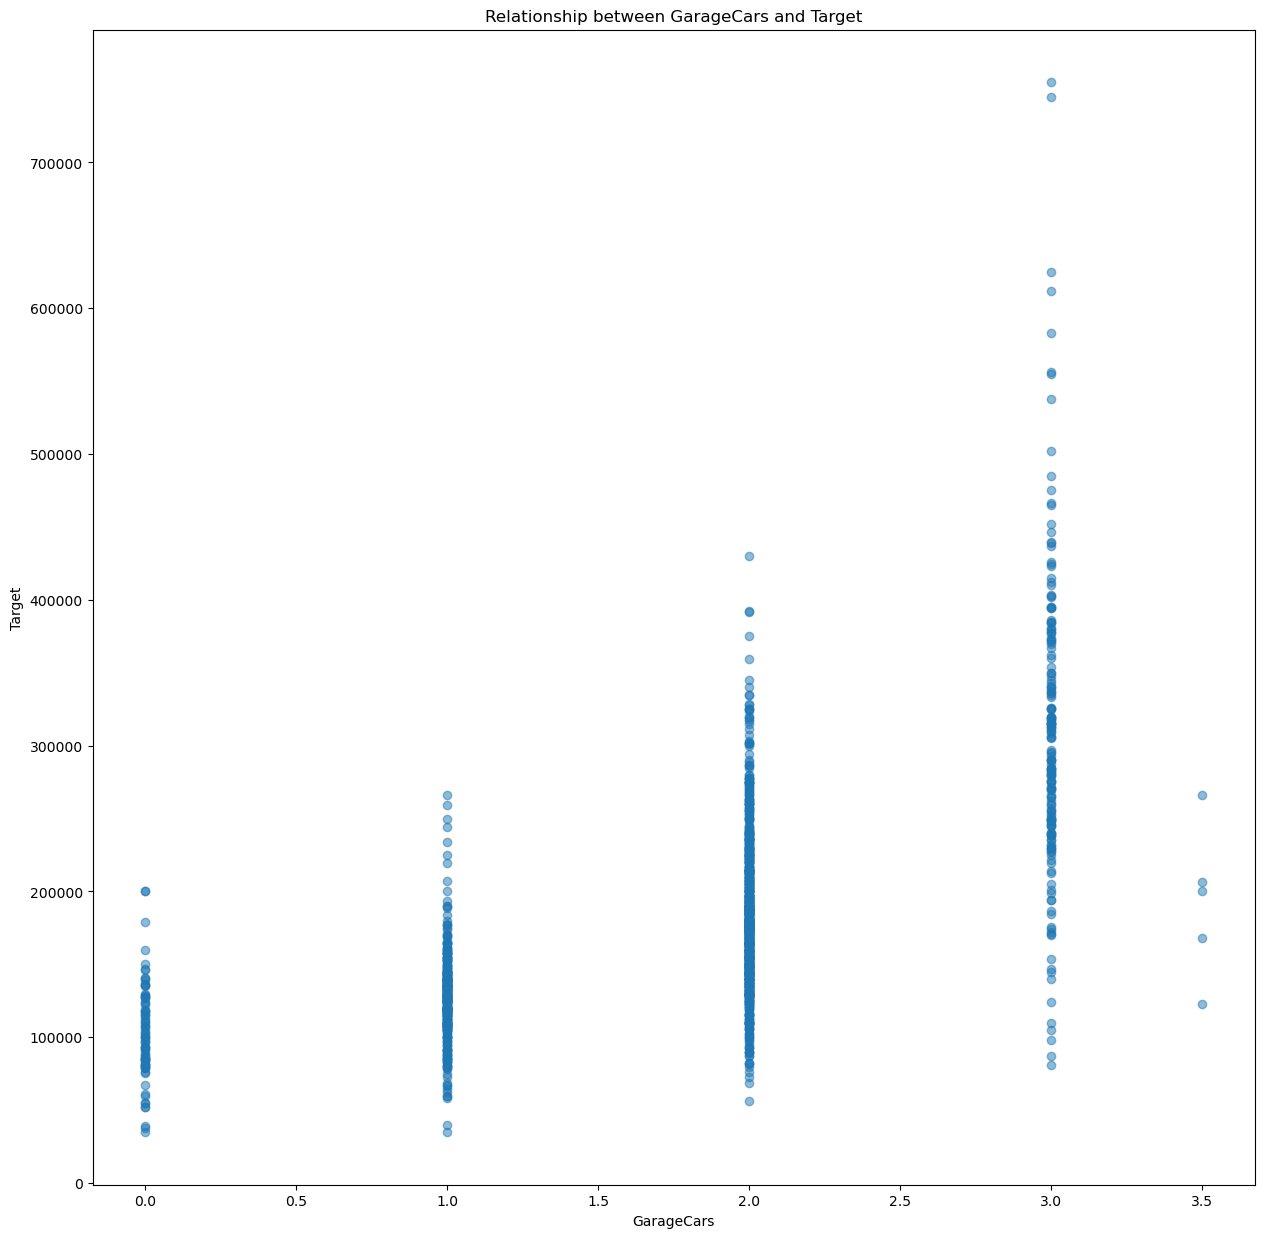

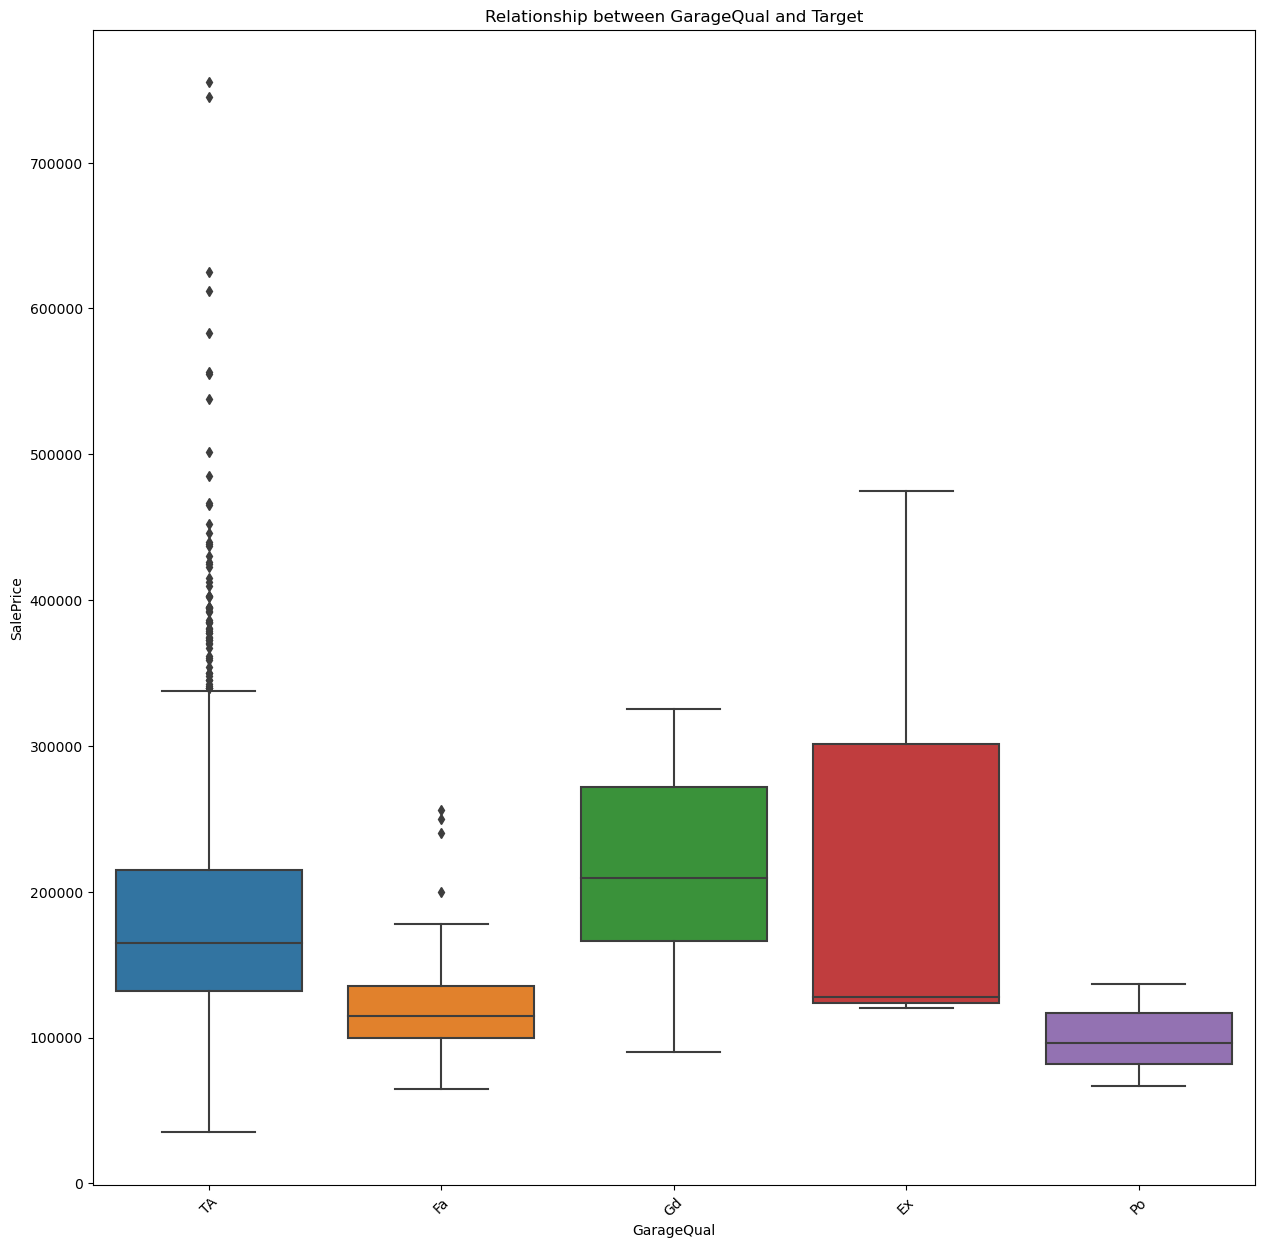

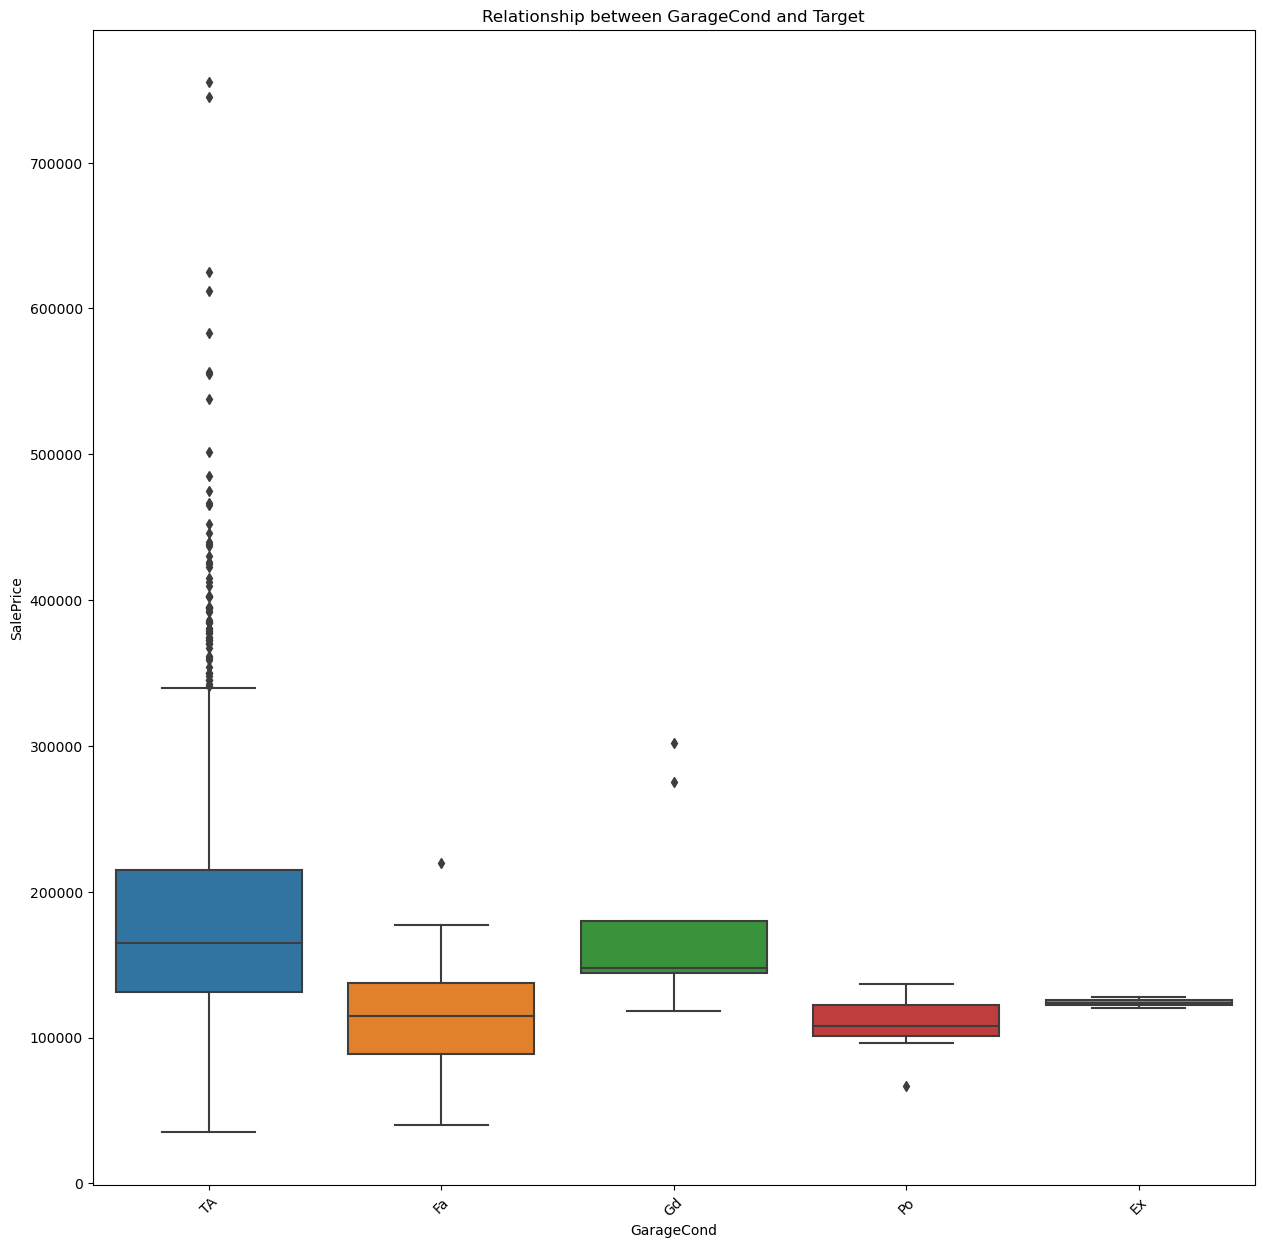

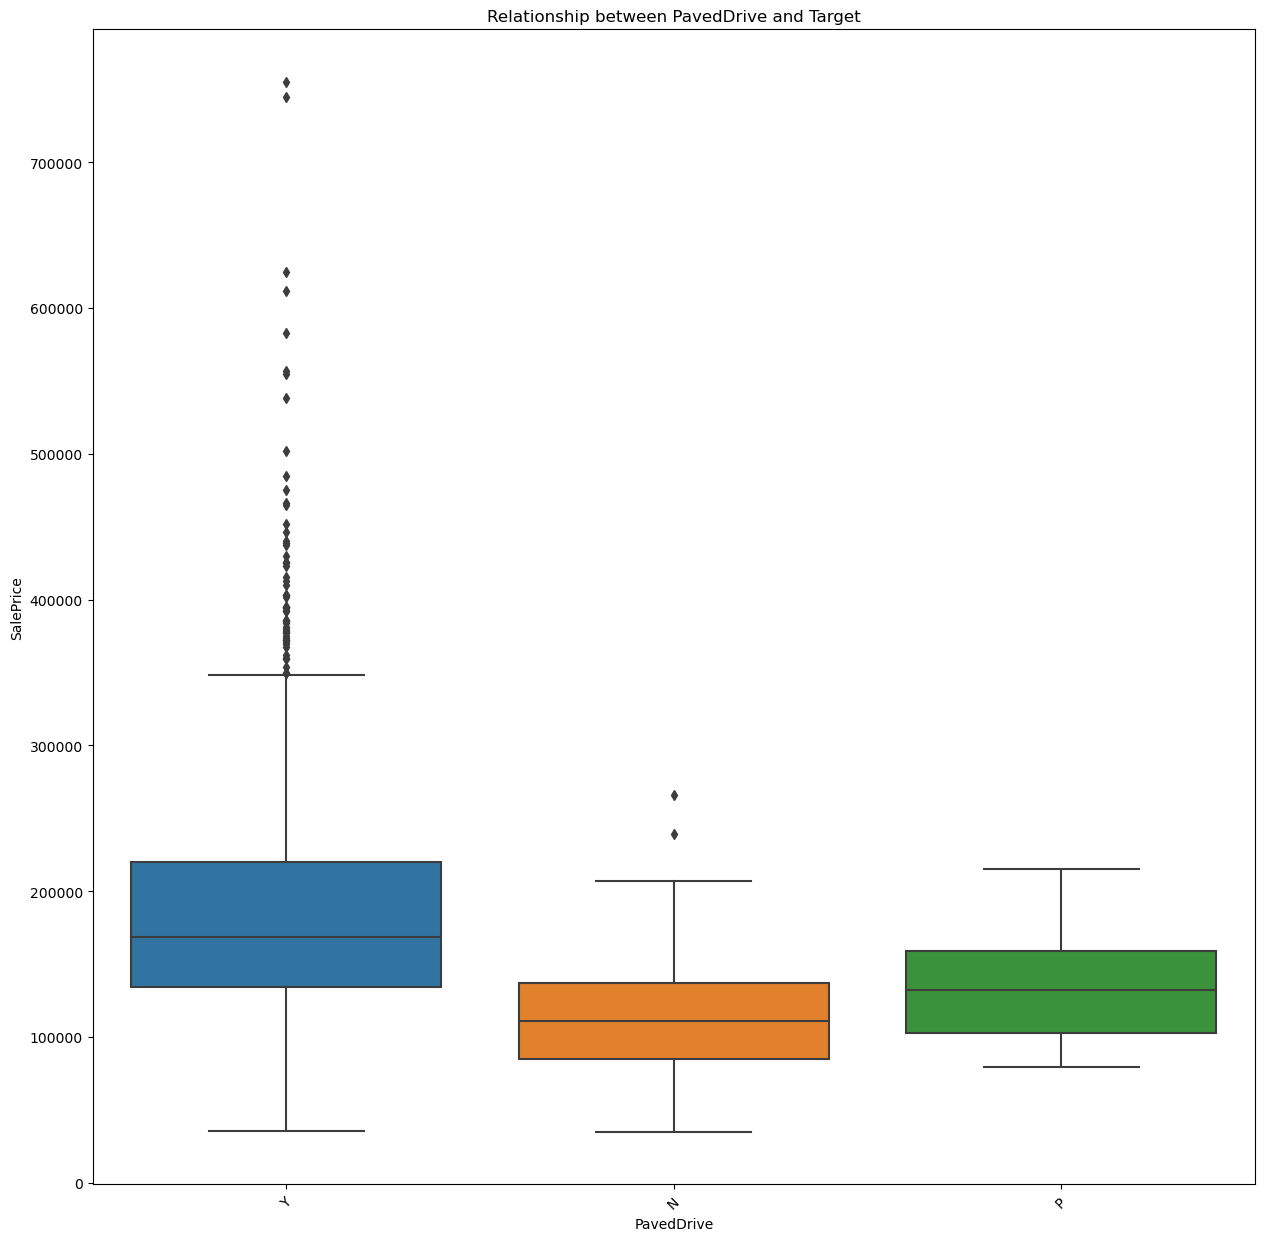

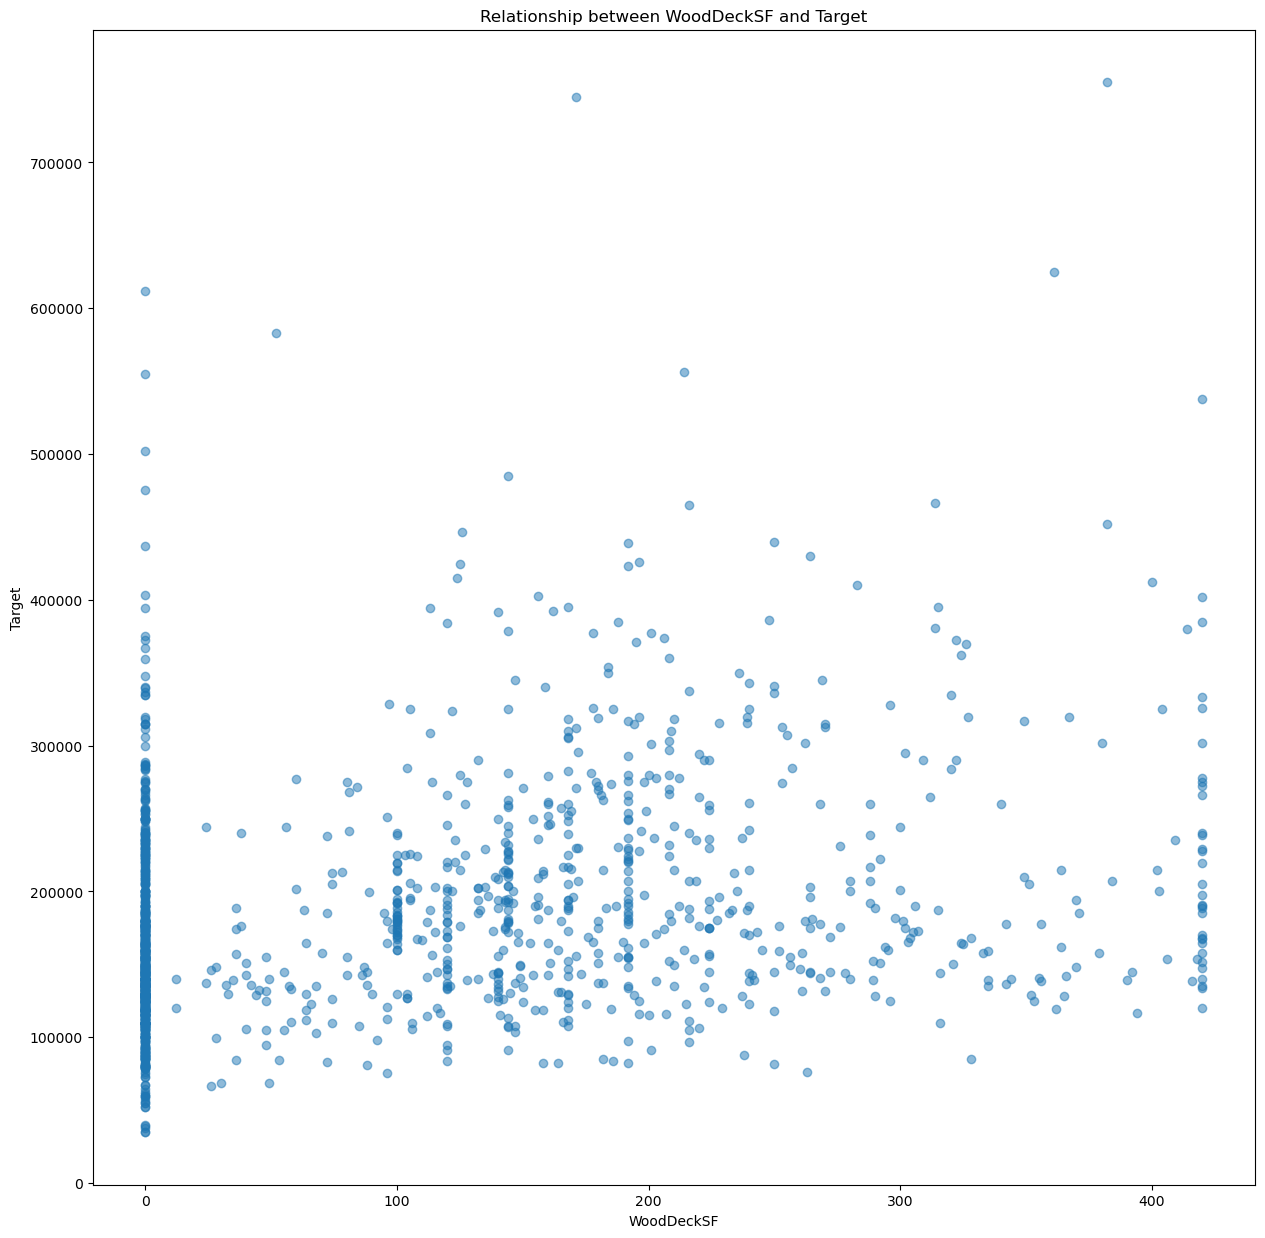

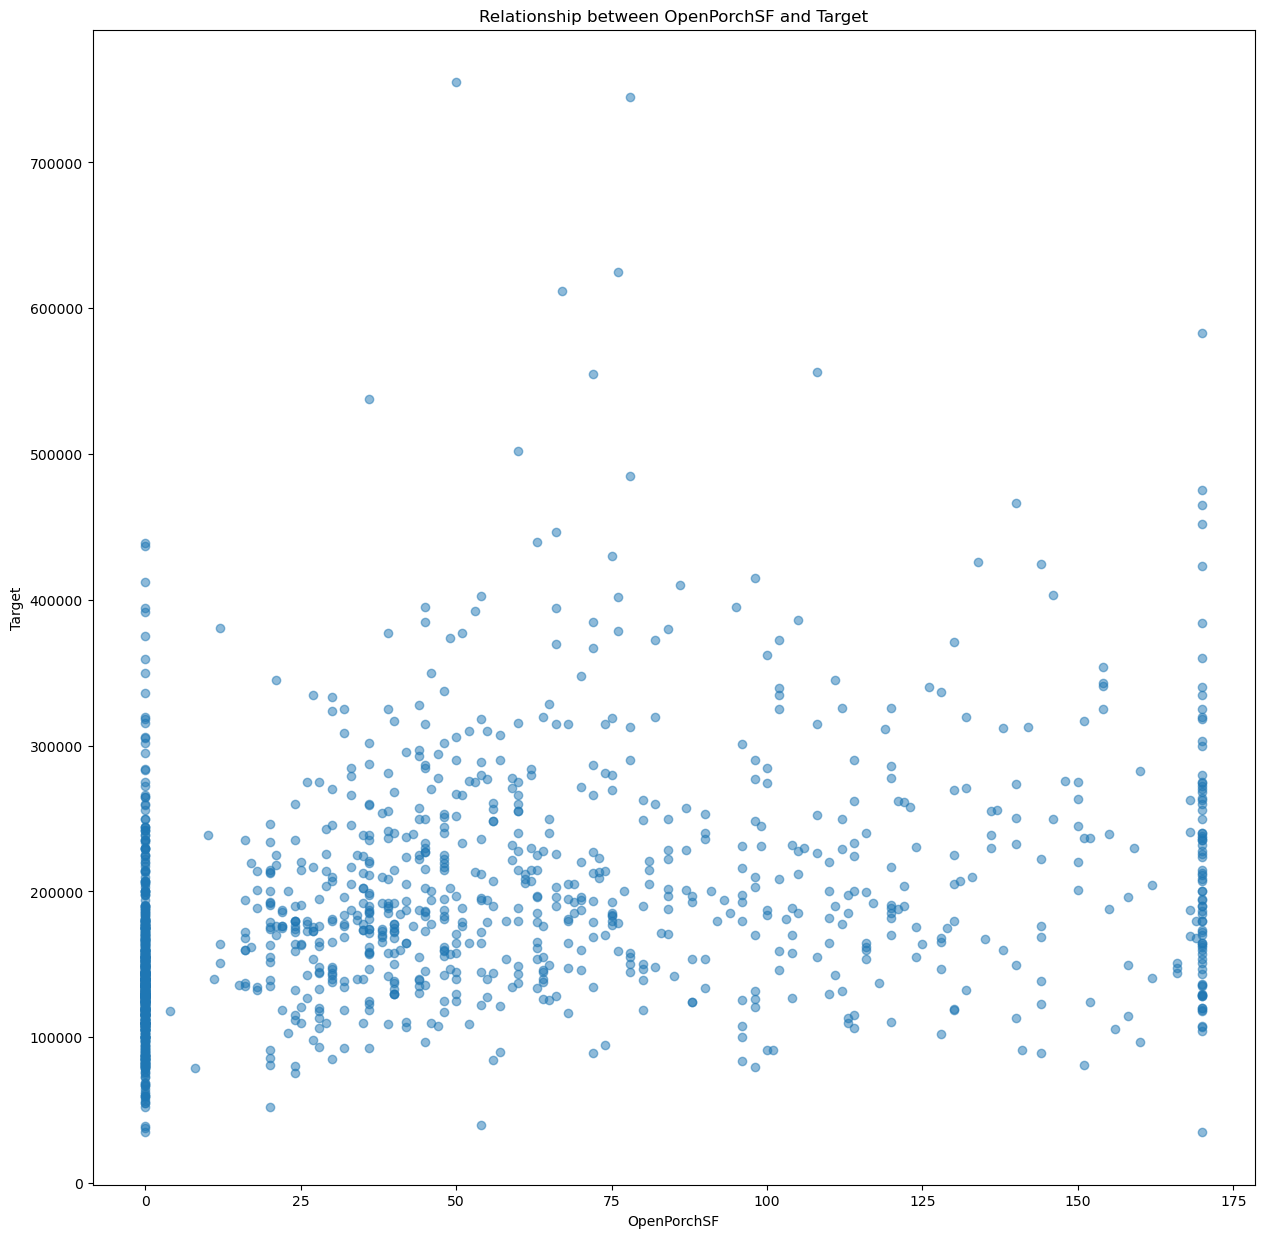

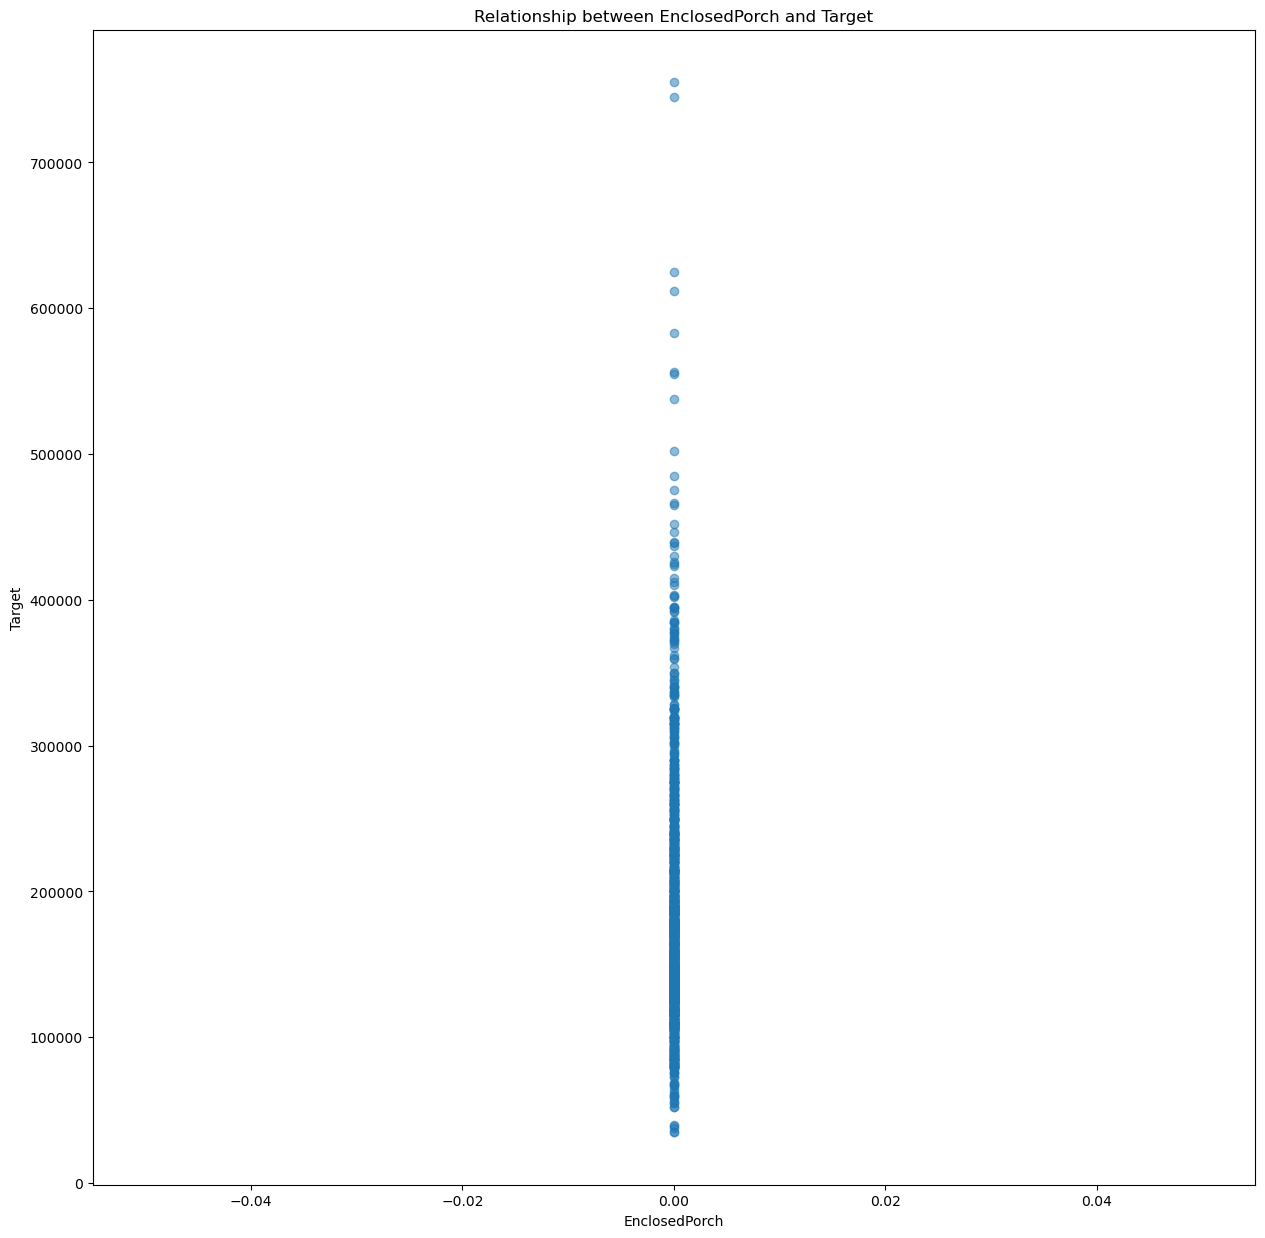

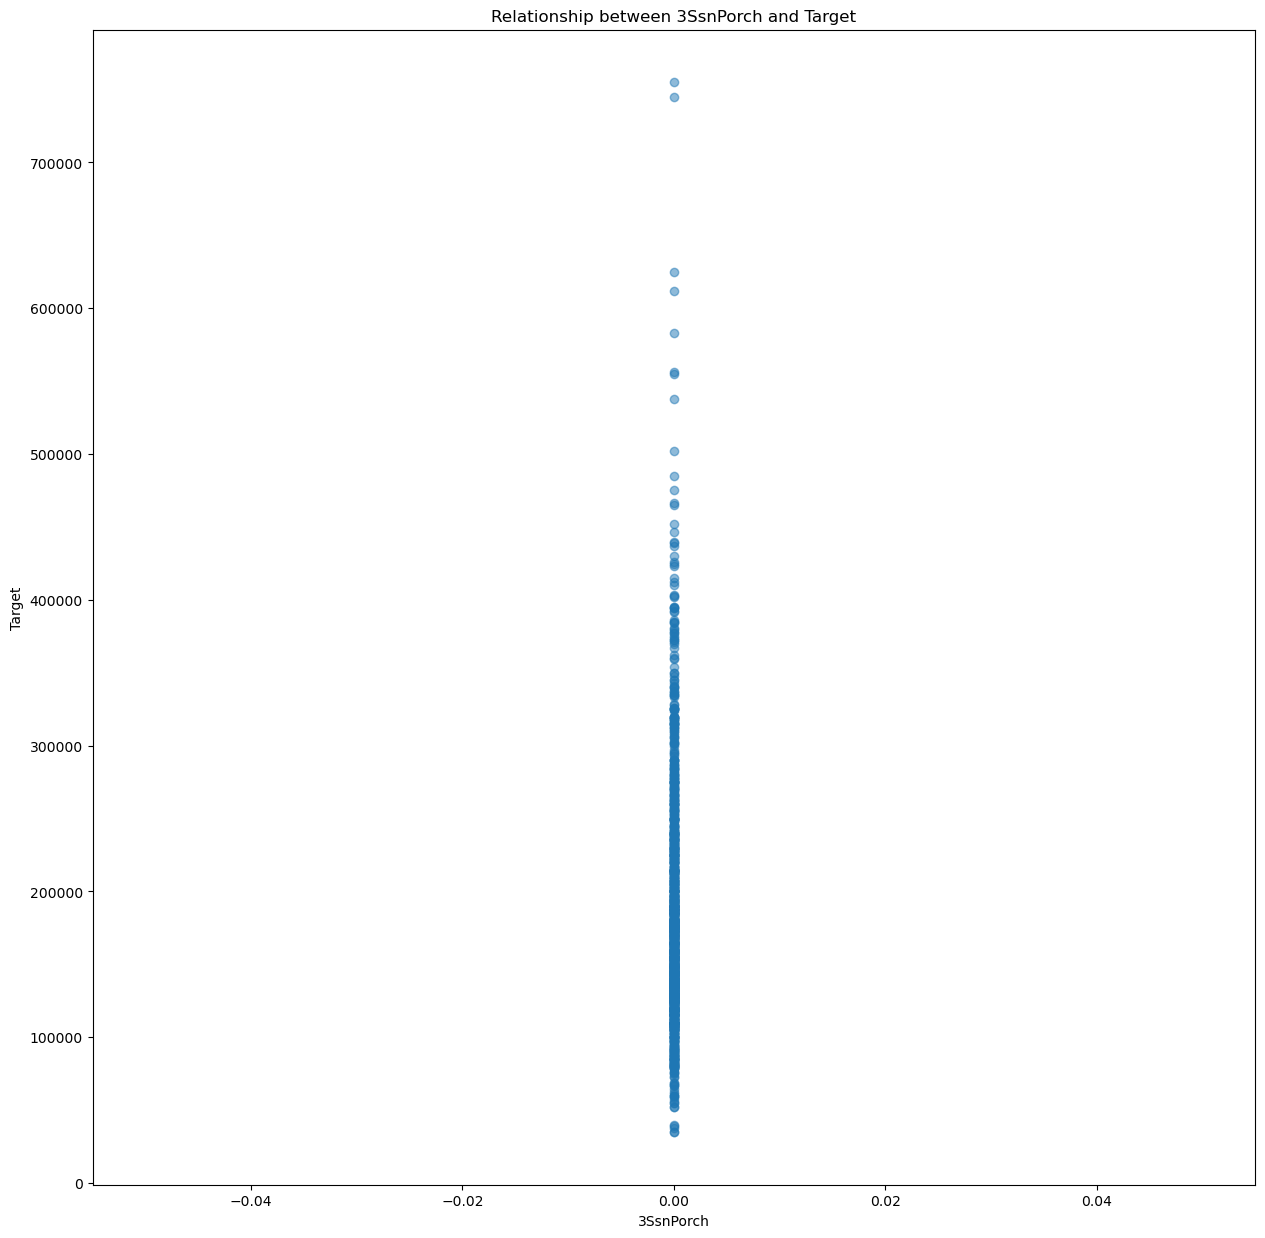

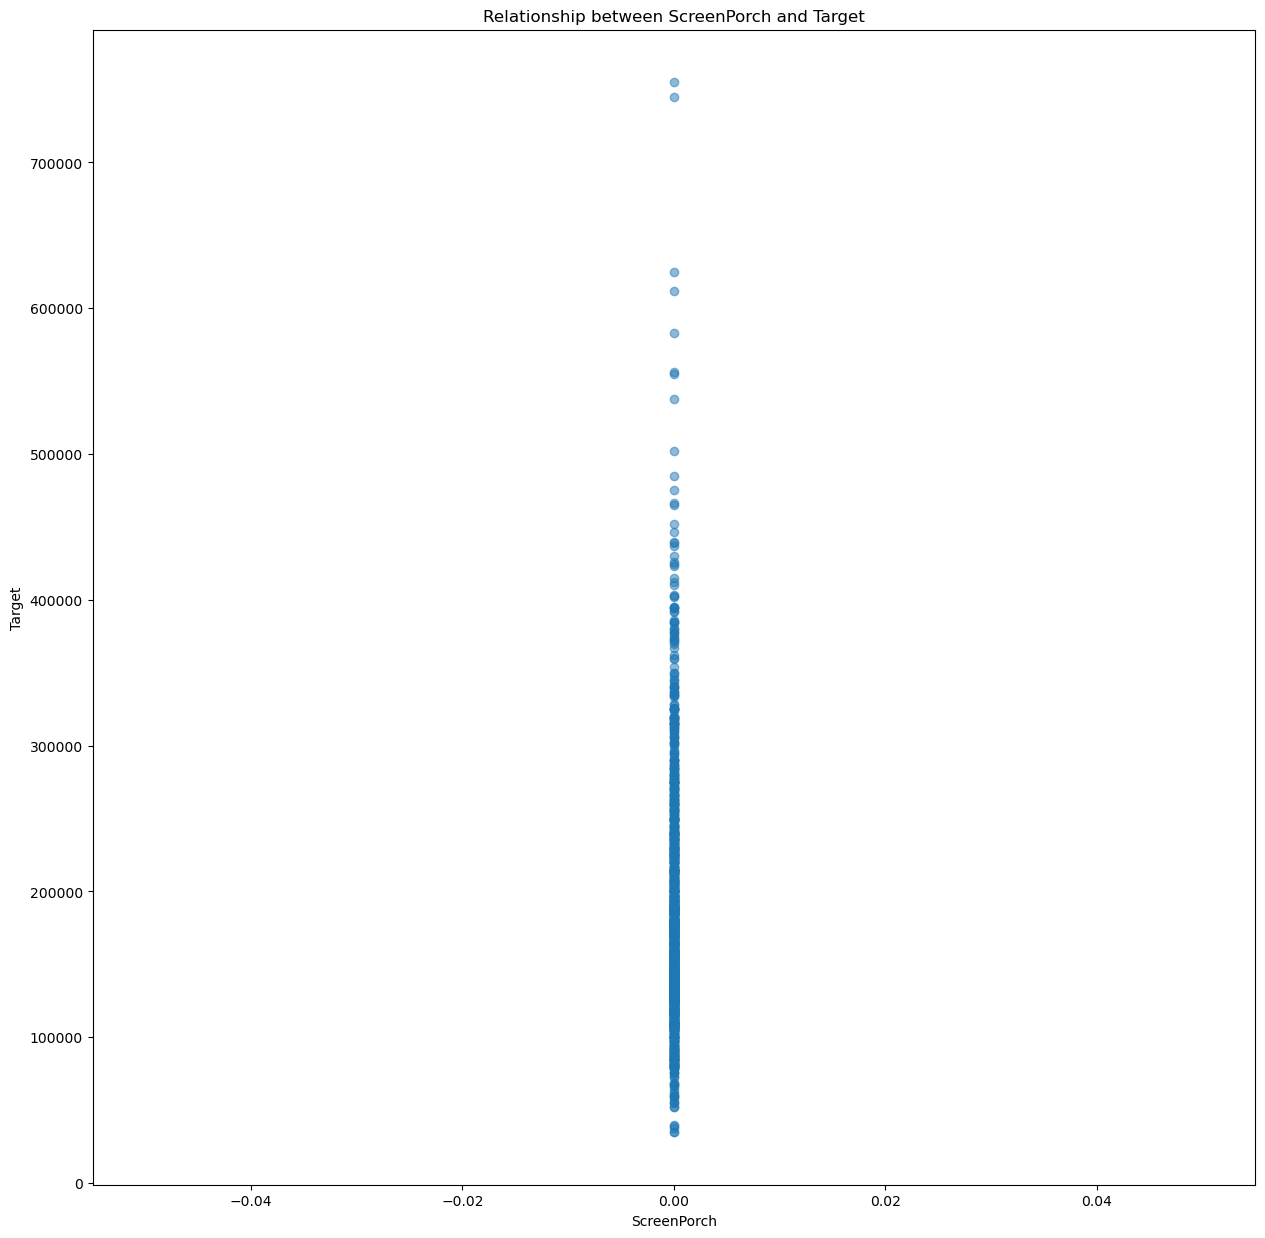

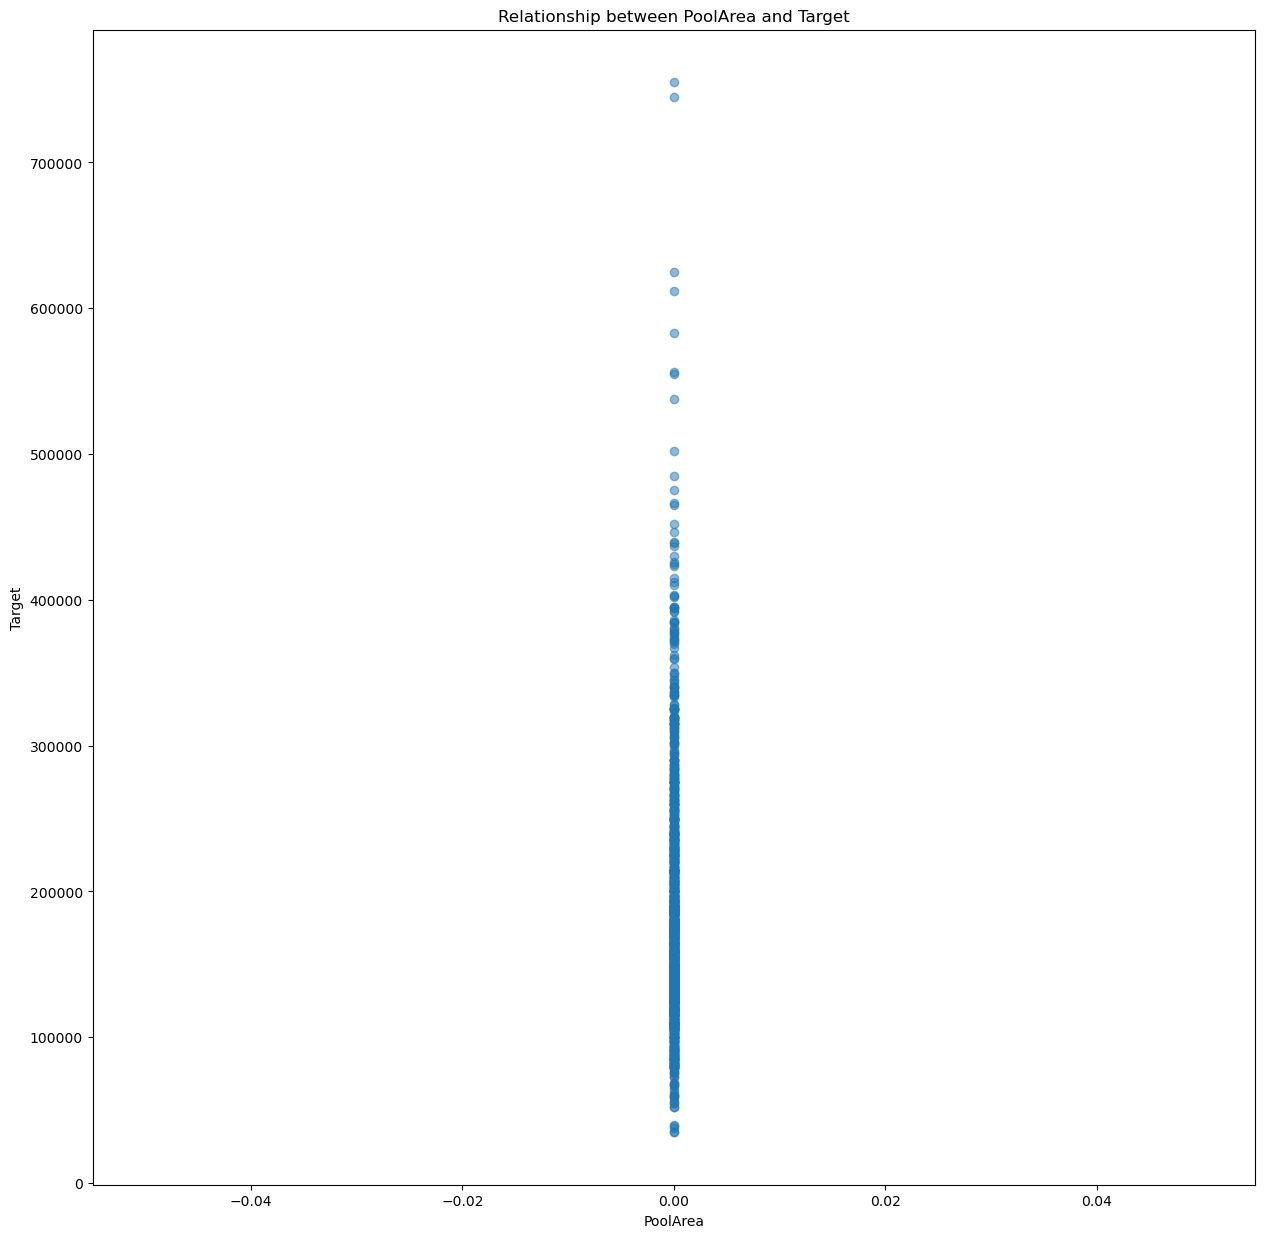

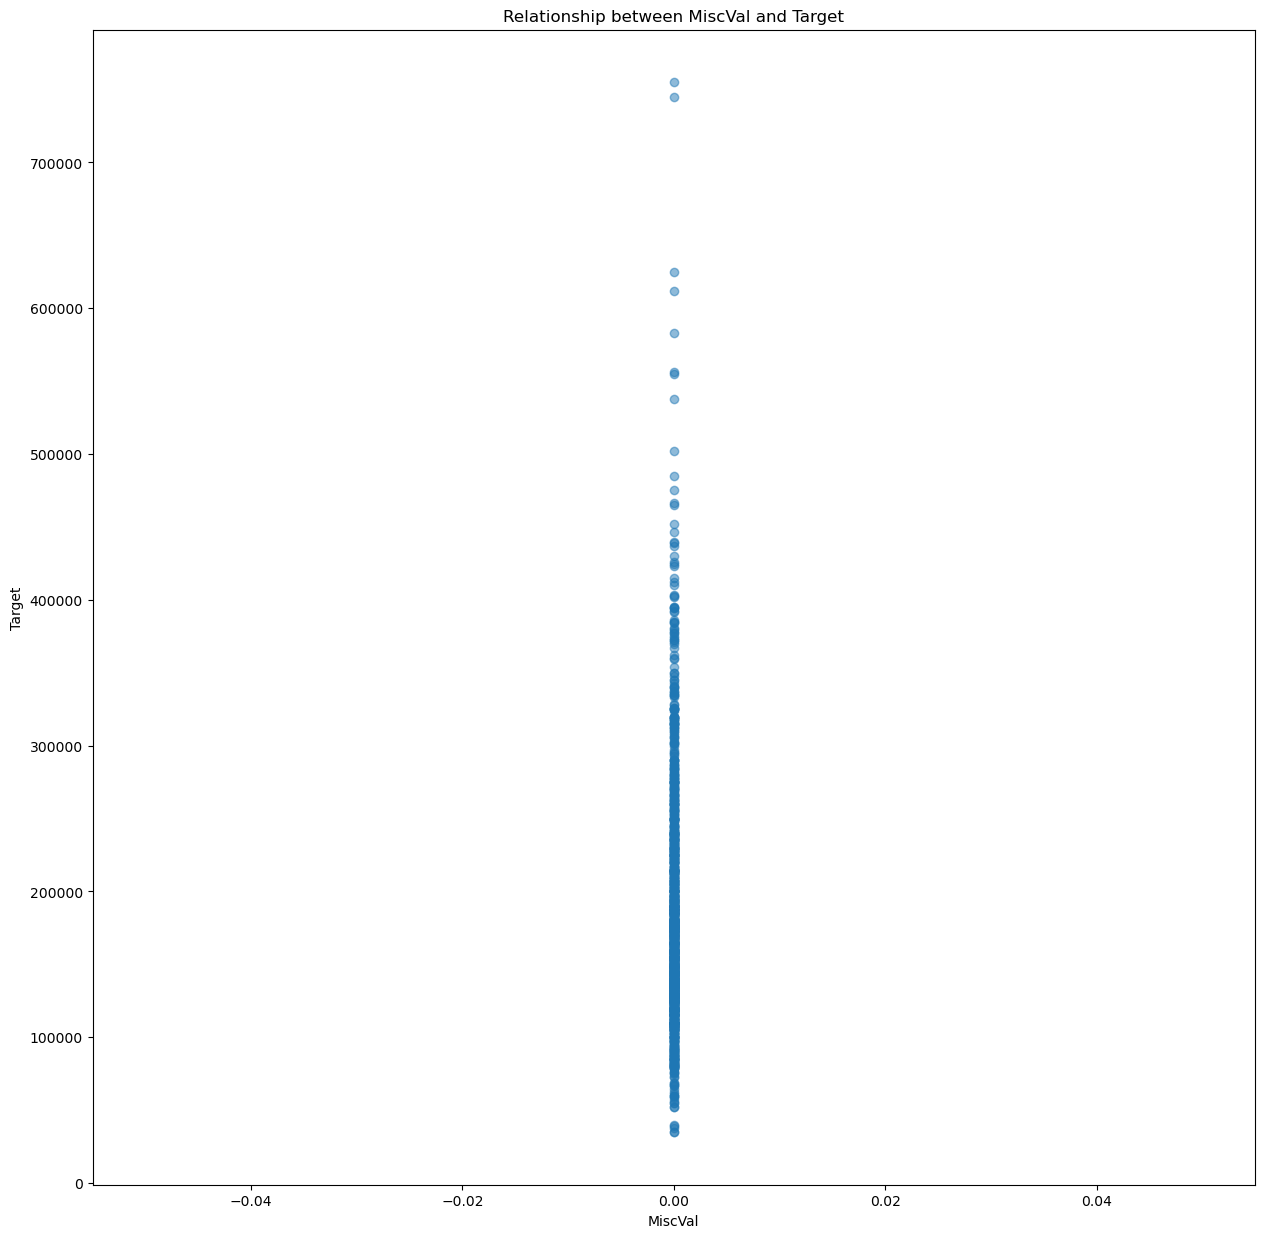

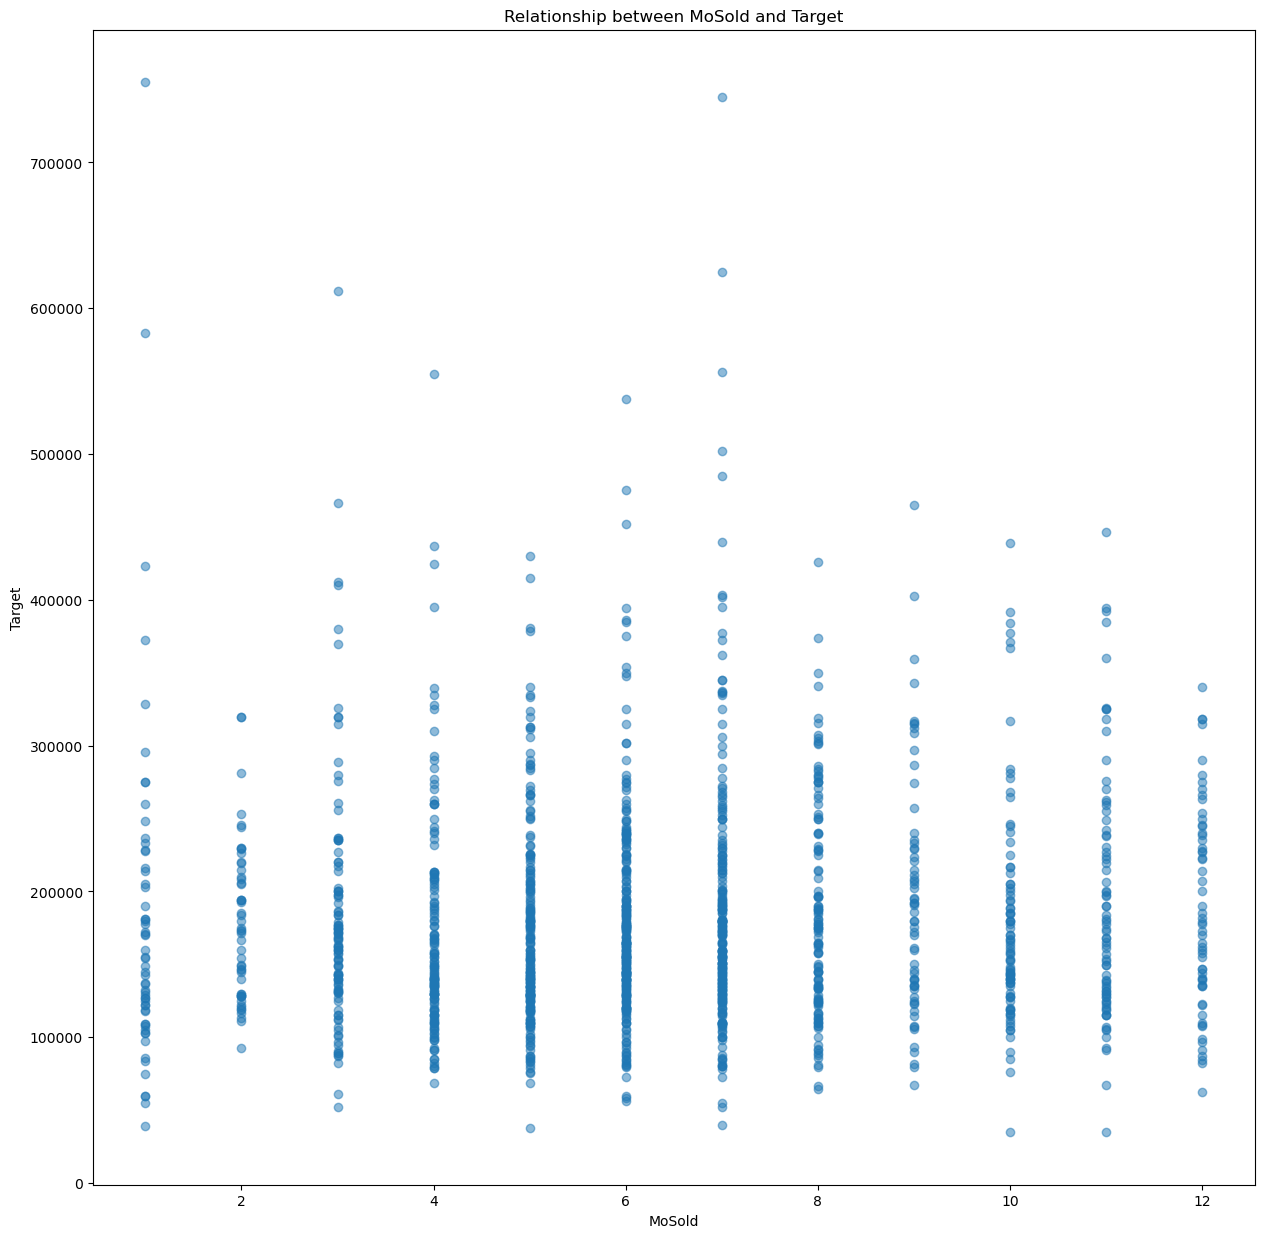

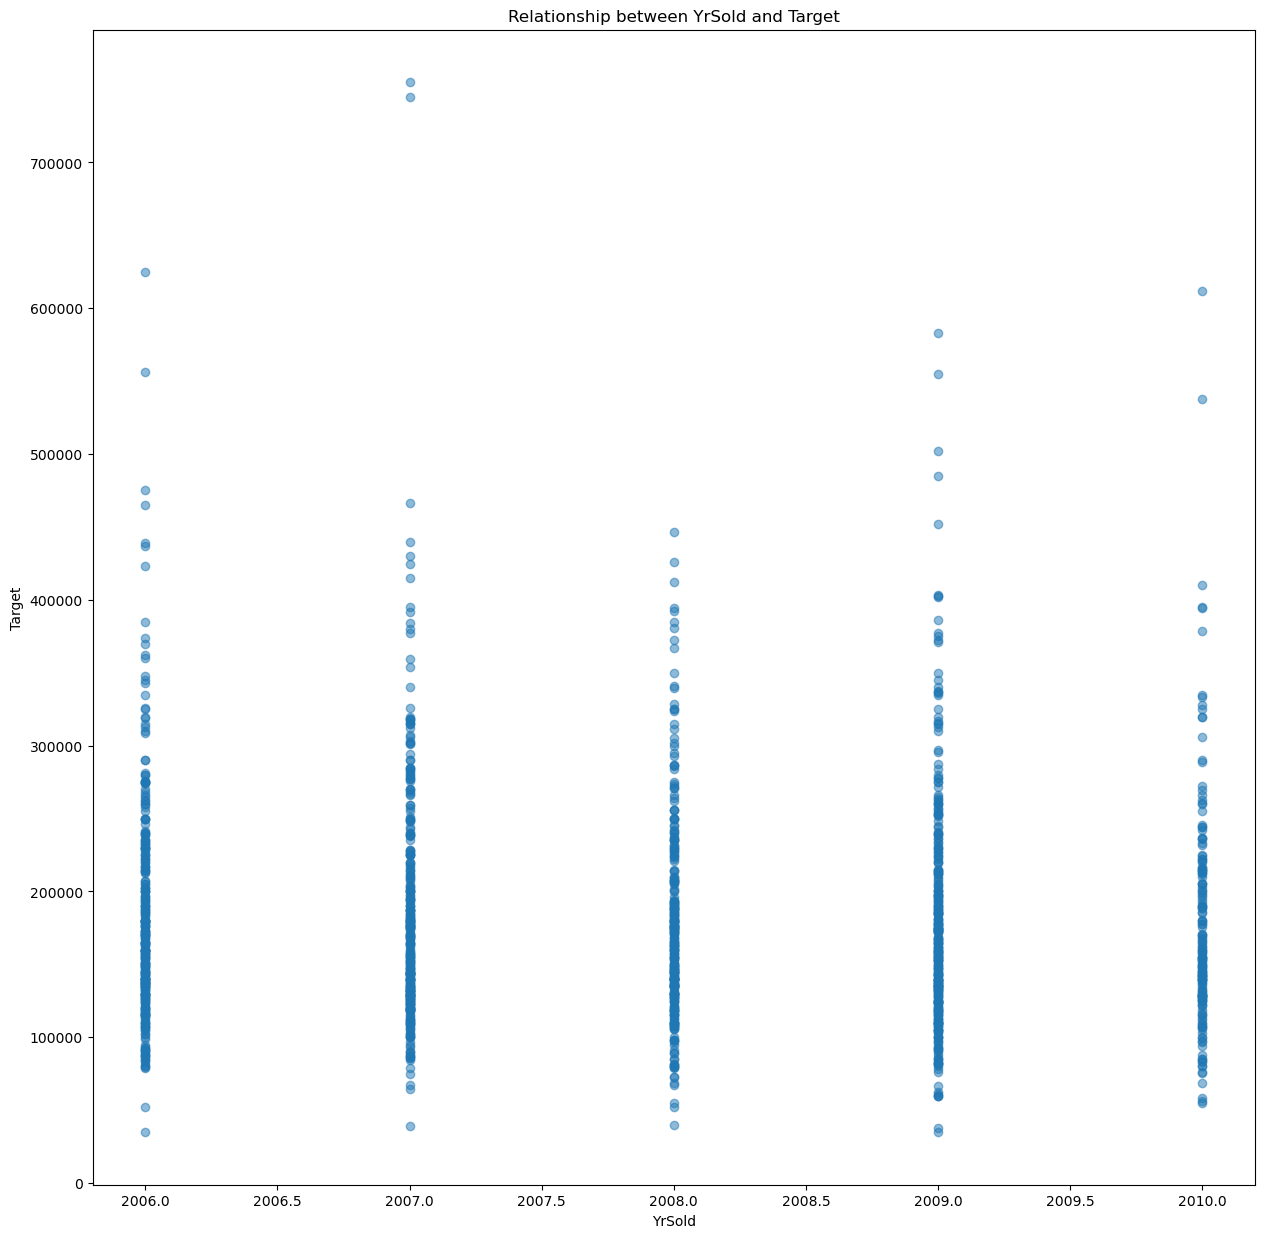

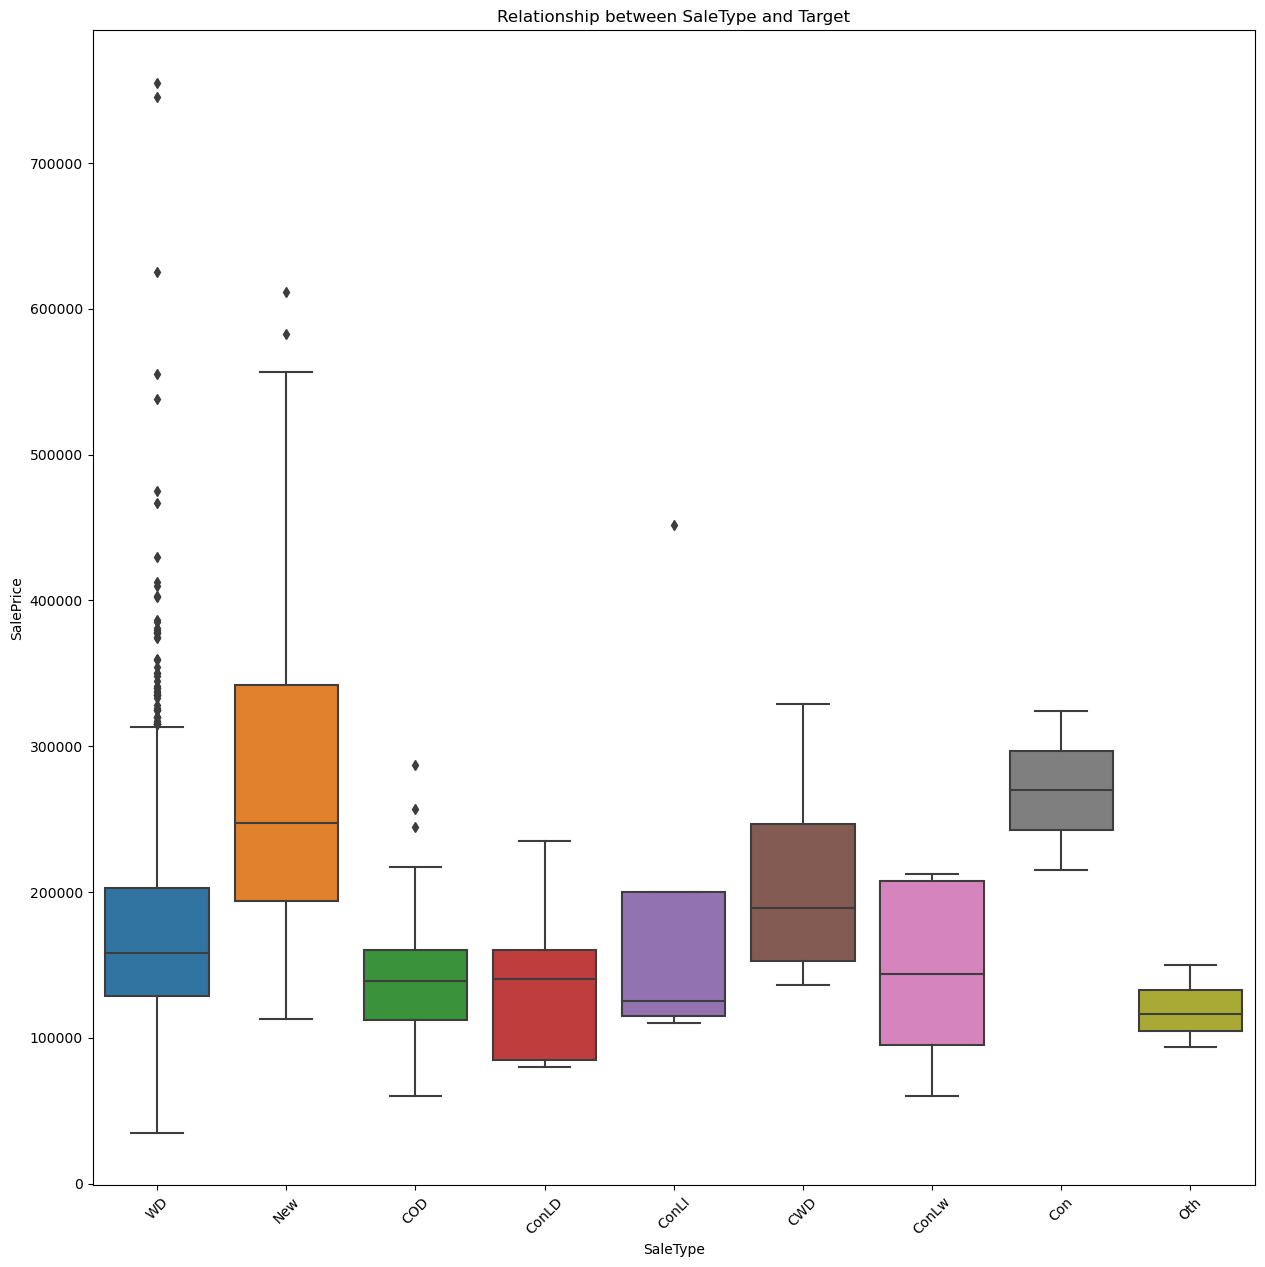

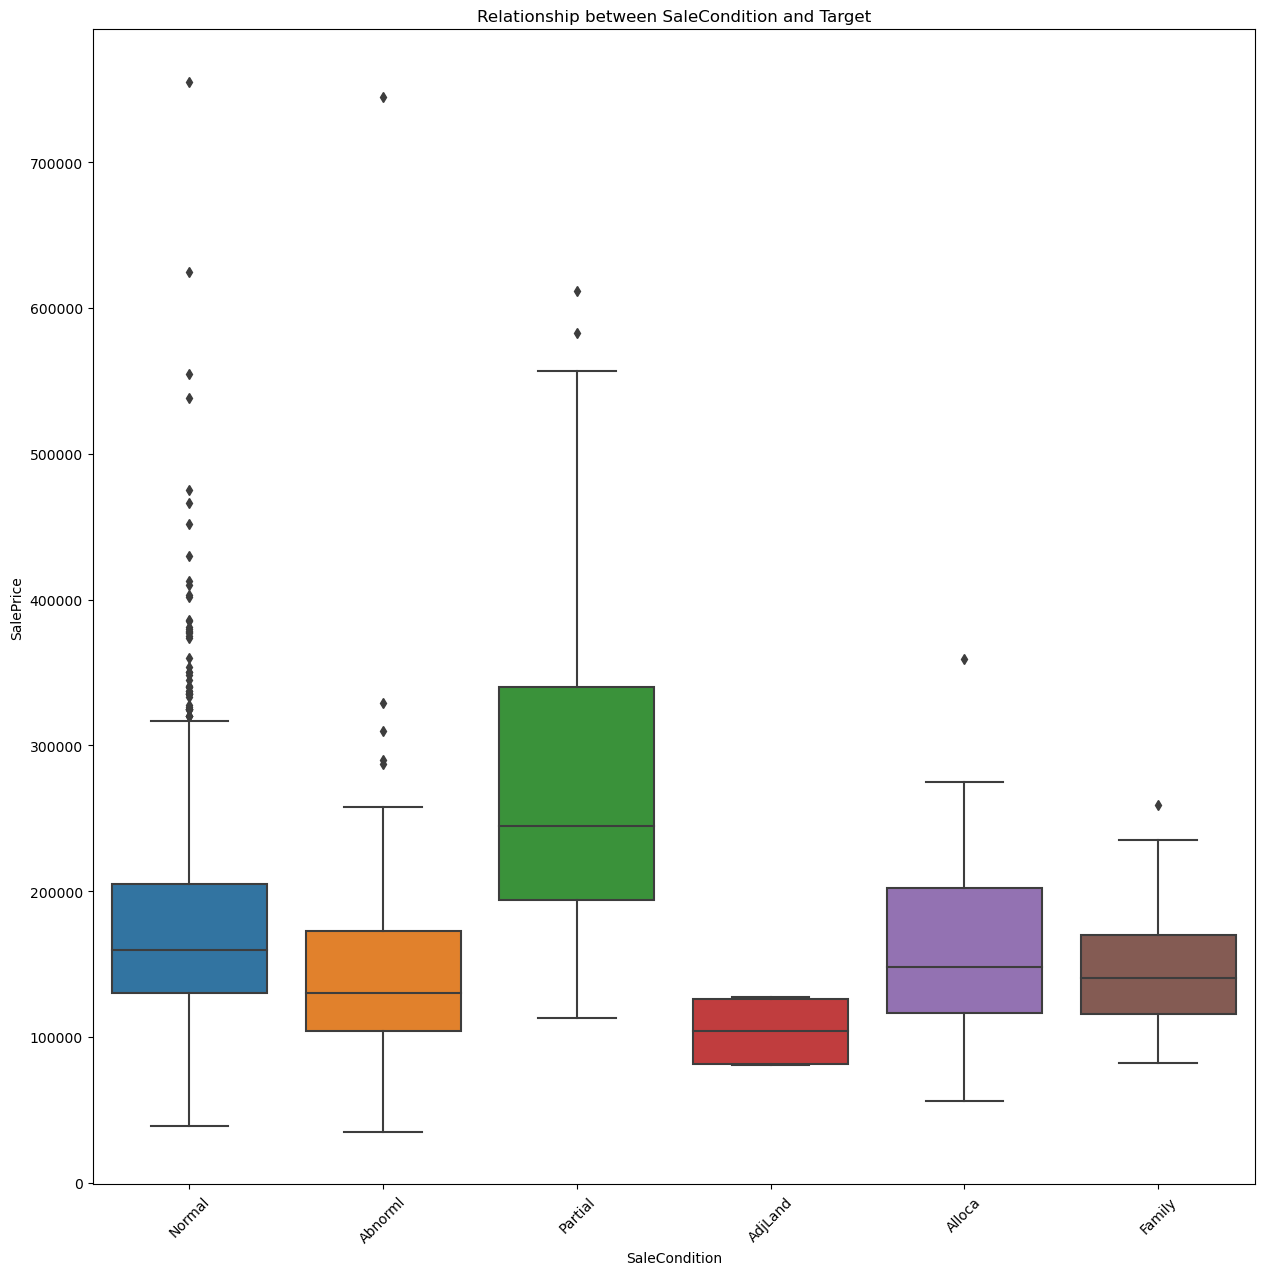

In [14]:
for column in X.columns:
    # Check if the variable is categorical or numerical
    if X[column].dtype == 'object':  # For categorical variables
        plt.figure(figsize=(15, 15))
        sns.boxplot(x=X[column], y=y)
        plt.title(f'Relationship between {column} and Target')
        plt.xticks(rotation=45)  # Ensure labels are not overlapping; adjust as needed
        plt.show()
    else:  # For numerical variables
        plt.figure(figsize=(15, 15))
        plt.scatter(X[column], y, alpha=0.5)
        plt.title(f'Relationship between {column} and Target')
        plt.xlabel(column)
        plt.ylabel('Target')
        plt.show()

1. **Overall Quality and Living Area** have strong, positive relationships with `SalePrice`. Higher overall quality and larger living areas tend to lead to higher sale prices.
2. **Neighborhoods**: Certain neighborhoods like NoRidge, NridgHt, and StoneBr show higher median sale prices, indicating location is a significant factor in housing prices.
3. **Year Built and Remodeling Year**: Newer homes and those recently remodeled tend to fetch higher prices, suggesting buyers value modern features and updates.
4. **External Materials and Finishes**: Properties with excellent (Ex) external quality or with specific materials (e.g., Stone, BrkFace) are associated with higher sale prices.
5. **Amenities**: Features such as fireplaces (especially higher-quality ones), pools, and the presence of a garage significantly impact the sale price. More so, garages with higher capacity (GarageCars) or finished garages (GarageFinish) elevate prices further.
6. **Size Metrics**: Apart from the living area, features indicating the size of the property (e.g., LotFrontage, LotArea, TotalBsmtSF, 1stFlrSF) are positively correlated with sale prices.
7. **Miscellaneous Features**: Surprisingly, the MiscVal (value of miscellaneous features) doesn't show a clear trend with SalePrice, possibly due to the varied nature of what this value might represent.

### Overall Inference:

The most significant factors affecting sale price appear to be the quality and size of the property, the neighborhood, and modern amenities or updates. The data suggests a clear trend that buyers are willing to pay more for homes that offer more space, modern features, and are located in desirable neighborhoods. Lesser emphasis is placed on features like street type, utilities, and the slope of the land, which do not show a strong individual impact on sale prices. This analysis underscores the importance of focusing on enhancing property quality, size, and ensuring key amenities are present when aiming to increase a home's market value.

In [15]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns


# Create the preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Define the Ridge regression model
ridge_model = Ridge(alpha=1.0)

# Create the Ridge regression pipeline
ridge_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', ridge_model)])

# Fit the Ridge regression pipeline on the training data
ridge_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred_ridge = ridge_pipeline.predict(X_test)

# Calculate the MSE for the Ridge regression model
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

ridge_score = ridge_pipeline.score(X_test, y_test)
print(f'Ridge R^2 Score: {ridge_score}')

Ridge R^2 Score: 0.8747724874246835


In [18]:
rmse_ridge = np.sqrt(mse_ridge)
print(f'Ridge RMSE: {rmse_ridge}')

Ridge RMSE: 30992.51315345862


In [19]:
lasso_model = Lasso(alpha=1.0)

# Create the Lasso regression pipeline
lasso_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', lasso_model)])

# Fit the Lasso regression pipeline on the training data
lasso_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lasso = lasso_pipeline.predict(X_test)

# Calculate the MSE for the Lasso regression model
mse_lasso = mean_squared_error(y_test, y_pred_lasso)


lasso_score = lasso_pipeline.score(X_test, y_test)
print(f'Lasso R^2 Score: {lasso_score}')

Lasso R^2 Score: 0.8690352214343564


In [20]:
rmse_lasso = np.sqrt(mse_lasso)
print(f'Ridge RMSE: {rmse_lasso}')

Ridge RMSE: 31694.519609082497


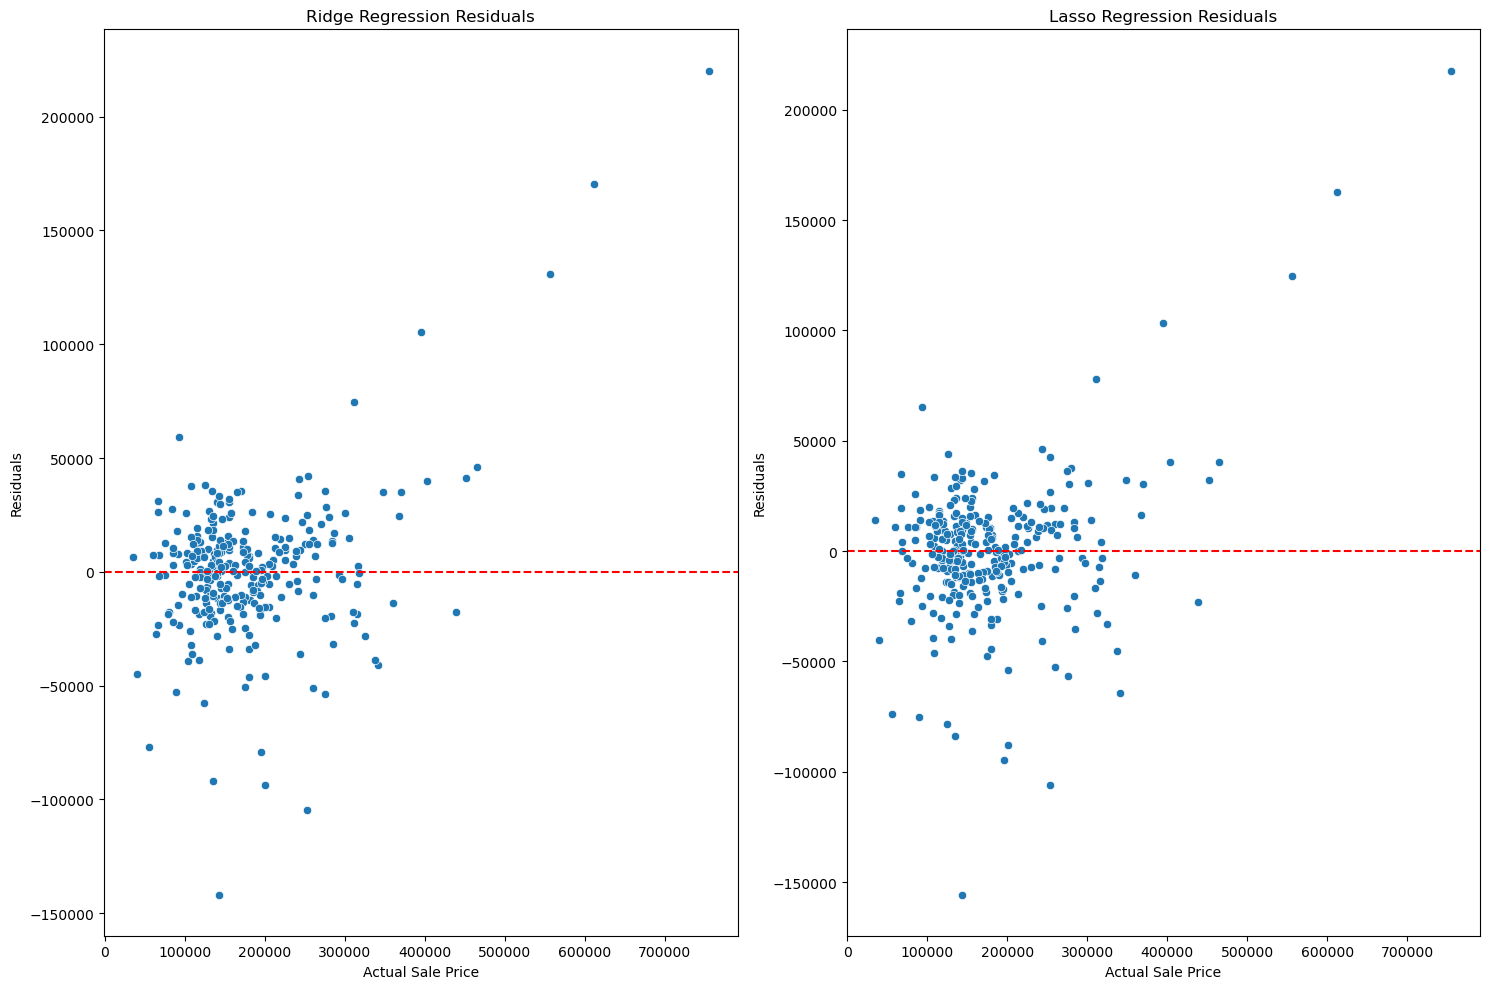

In [21]:
residuals_ridge = y_test - y_pred_ridge
residuals_lasso = y_test - y_pred_lasso

# Plotting the residuals for Ridge regression
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=residuals_ridge)
plt.title('Ridge Regression Residuals')
plt.xlabel('Actual Sale Price')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')

# Plotting the residuals for Lasso regression
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=residuals_lasso)
plt.title('Lasso Regression Residuals')
plt.xlabel('Actual Sale Price')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

finding optimal alphas for question 1

In [22]:
alphas = np.logspace(-6, 6, 13)

# Ridge Regression
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('model', ridge_cv)])
ridge_cv_pipeline.fit(X_train, y_train)
optimal_ridge_alpha = ridge_cv.alpha_
print(f"Optimal Ridge Alpha: {optimal_ridge_alpha}")

ridge_cv_score = ridge_cv_pipeline.score(X_test, y_test)
y_pred_ridge_optimal = ridge_cv_pipeline.predict(X_test)
mse_ridge_optimal = mean_squared_error(y_test, y_pred_ridge_optimal)
rmse_ridge_optimal = np.sqrt(mse_ridge_optimal)
mae_ridge_optimal = mean_absolute_error(y_test, y_pred_ridge_optimal)
print(f"Ridge Regression with Optimal Alpha R^2 Score: {ridge_cv_score}")
print(f'Ridge Regression with Optimal Alpha MSE: {mse_ridge_optimal}')
print(f'Ridge Regression with Optimal Alpha RMSE: {rmse_ridge_optimal}')
print(f'Ridge Regression with Optimal Alpha MAE: {mae_ridge_optimal}')

# Double the alpha, retrain and evaluate for Ridge Regression
ridge_double_alpha = Ridge(alpha=optimal_ridge_alpha * 2)
ridge_double_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                        ('model', ridge_double_alpha)])
ridge_double_pipeline.fit(X_train, y_train)
y_pred_ridge_double = ridge_double_pipeline.predict(X_test)
ridge_double_score = ridge_double_pipeline.score(X_test, y_test)
mse_ridge_double = mean_squared_error(y_test, y_pred_ridge_double)
rmse_ridge_double = np.sqrt(mse_ridge_double)
mae_ridge_double = mean_absolute_error(y_test, y_pred_ridge_double)
print(f"Ridge Regression with Double Alpha R^2 Score: {ridge_double_score}")
print(f'Ridge Regression with Double Alpha MSE: {mse_ridge_double}')
print(f'Ridge Regression with Double Alpha RMSE: {rmse_ridge_double}')
print(f'Ridge Regression with Double Alpha MAE: {mae_ridge_double}')

# Lasso Regression
lasso_cv = LassoCV(alphas=alphas, max_iter=10000, cv=5)
lasso_cv_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('model', lasso_cv)])
lasso_cv_pipeline.fit(X_train, y_train)
optimal_lasso_alpha = lasso_cv.alpha_
print(f"Optimal Lasso Alpha: {optimal_lasso_alpha}")

lasso_cv_score = lasso_cv_pipeline.score(X_test, y_test)
y_pred_lasso_optimal = lasso_cv_pipeline.predict(X_test)
mse_lasso_optimal = mean_squared_error(y_test, y_pred_lasso_optimal)
rmse_lasso_optimal = np.sqrt(mse_lasso_optimal)
mae_lasso_optimal = mean_absolute_error(y_test, y_pred_lasso_optimal)
print(f"Lasso Regression with Optimal Alpha R^2 Score: {lasso_cv_score}")
print(f'Lasso Regression with Optimal Alpha MSE: {mse_lasso_optimal}')
print(f'Lasso Regression with Optimal Alpha RMSE: {rmse_lasso_optimal}')
print(f'Lasso Regression with Optimal Alpha MAE: {mae_lasso_optimal}')

# Double the alpha, retrain and evaluate for Lasso Regression
lasso_double_alpha = Lasso(alpha=optimal_lasso_alpha * 2, max_iter=10000)
lasso_double_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                        ('model', lasso_double_alpha)])
lasso_double_pipeline.fit(X_train, y_train)
y_pred_lasso_double = lasso_double_pipeline.predict(X_test)
lasso_double_score = lasso_double_pipeline.score(X_test, y_test)
mse_lasso_double = mean_squared_error(y_test, y_pred_lasso_double)
rmse_lasso_double = np.sqrt(mse_lasso_double)
mae_lasso_double = mean_absolute_error(y_test, y_pred_lasso_double)
print(f"Lasso Regression with Double Alpha R^2 Score: {lasso_double_score}")
print(f'Lasso Regression with Double Alpha MSE: {mse_lasso_double}')
print(f'Lasso Regression with Double Alpha RMSE: {rmse_lasso_double}')
print(f'Lasso Regression with Double Alpha MAE: {mae_lasso_double}')

Optimal Ridge Alpha: 10.0
Ridge Regression with Optimal Alpha R^2 Score: 0.8735093567149362
Ridge Regression with Optimal Alpha MSE: 970224496.153383
Ridge Regression with Optimal Alpha RMSE: 31148.426864825502
Ridge Regression with Optimal Alpha MAE: 18328.061729549805
Ridge Regression with Double Alpha R^2 Score: 0.871454528161694
Ridge Regression with Double Alpha MSE: 985985701.4565932
Ridge Regression with Double Alpha RMSE: 31400.4092561959
Ridge Regression with Double Alpha MAE: 18185.52797150007
Optimal Lasso Alpha: 100.0
Lasso Regression with Optimal Alpha R^2 Score: 0.8811750670808668
Lasso Regression with Optimal Alpha MSE: 911425997.0368798
Lasso Regression with Optimal Alpha RMSE: 30189.83267653002
Lasso Regression with Optimal Alpha MAE: 17897.79156660496
Lasso Regression with Double Alpha R^2 Score: 0.8723483165244134
Lasso Regression with Double Alpha MSE: 979130053.1543477
Lasso Regression with Double Alpha RMSE: 31291.053883727658
Lasso Regression with Double Alpha MA

Question 1: Optimal Alpha for Ridge and Lasso Regression and the Impact of Doubling Alpha
Optimal Alpha Values:

For Ridge regression, the optimal alpha value found was 10.0.
For Lasso regression, the optimal alpha value found was 100.0.
Impact of Doubling Alpha:

Doubling the alpha for Ridge regression (from 10.0 to 20.0) slightly decreased the R² score from 0.8735 to 0.8715. This suggests a minor reduction in the model's ability to explain the variance in the target variable, likely due to increased bias.
Doubling the alpha for Lasso regression (from 100.0 to 200.0) also led to a decrease in the R² score, from 0.8812 to 0.8723. Similar to Ridge, this indicates that the model with a doubled alpha value is slightly less effective at capturing the underlying relationship between the features and the target variable.
Most Important Predictor Variables After the Change: To identify the most important predictors, especially after doubling alpha for the Lasso model, you should examine the features with non-zero coefficients. Since Lasso can shrink some coefficients to zero, those that remain are considered more relevant for the prediction. Given that Lasso with the optimal alpha already performs feature selection, doubling the alpha further simplifies the model, potentially zeroing out more coefficients. The "important features" printout after running the Lasso model with optimal alpha will show which features are most influential. Doubling the alpha likely reduces the number of these features or changes their importance.

Question 2: Choice Between Ridge and Lasso Regression
Given the R² scores:

The Lasso regression model with the optimal alpha (100.0) achieves a higher R² score (0.8812) compared to the Ridge regression with its optimal alpha (10.0), which has an R² score of 0.8735. This indicates that the Lasso model is slightly better at explaining the variance in the target variable for this particular dataset.
The choice between Ridge and Lasso should consider both the performance metrics and the model's complexity. Given that Lasso also performs feature selection, if you value a simpler model with potentially fewer features, Lasso might be the preferred choice. It simplifies the model by eliminating less important features, which is beneficial when dealing with high-dimensional data or when interpretation and understanding of the most influential features are important.

question3

In [24]:
# Assuming 'X_train' and 'categorical_cols' are defined
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols)

In [25]:
lasso_optimal = Lasso(alpha=100.0).fit(X_train_encoded, y_train)
important_features = pd.Series(lasso_optimal.coef_, index=X_train_encoded.columns)

# Print non-zero features (sorted by their absolute value)
non_zero_features = important_features[important_features != 0].abs().sort_values(ascending=False)
print("Most important predictor variables in the Lasso model with alpha=100.0:")
print(non_zero_features)

Most important predictor variables in the Lasso model with alpha=100.0:
RoofMatl_ClyTile        163376.719637
Condition2_PosN          86887.375345
Neighborhood_NoRidge     36138.169967
Neighborhood_StoneBr     34971.063964
KitchenQual_Ex           25878.586964
                            ...      
OpenPorchSF                 10.877327
MasVnrArea                   3.433281
BsmtUnfSF                    3.097800
LotArea                      1.407430
Id                           0.601595
Length: 107, dtype: float64


In [26]:
k = 5  # For example, exclude the top 5 features
top_features_to_exclude = non_zero_features.head(k).index.tolist()

# Create a new feature set excluding the top 'k' features
X_train_reduced = X_train_encoded.drop(columns=top_features_to_exclude)

# Retrain the Lasso model on the reduced feature set
lasso_retrained = Lasso(alpha=100.0).fit(X_train_reduced, y_train)

# Identify the most important variables in the retrained model
retrained_important_features = pd.Series(lasso_retrained.coef_, index=X_train_reduced.columns)
non_zero_retrained_features = retrained_important_features[retrained_important_features != 0].abs().sort_values(ascending=False)

print("Most important predictor variables in the Lasso model after excluding top features:")
print(non_zero_retrained_features)

Most important predictor variables in the Lasso model after excluding top features:
Exterior2nd_ImStucc     31610.377537
RoofMatl_WdShngl        23460.659107
Neighborhood_Mitchel    22603.906220
BsmtQual_Ex             19735.390024
Exterior1st_BrkFace     19254.910079
                            ...     
OpenPorchSF                 8.399353
BsmtUnfSF                   6.417537
LotFrontage                 4.160334
LotArea                     1.449571
Id                          0.730073
Length: 110, dtype: float64


"After applying the Lasso regression model to our dataset with an optimal alpha of 100.0, we initially identified a set of key predictor variables significantly influencing the SalePrice. These variables were derived from one-hot encoding and represented specific categories within the original categorical features. To address the scenario where such specific categories (reflected as RoofMatl_ClyTile, Condition2_PosN, Neighborhood_NoRidge, Neighborhood_StoneBr, KitchenQual_Ex) might not be available in incoming data, we attempted to exclude these predictors and retrain the model to discover alternative significant variables.

Upon reanalysis and considering the specific nuances of our dataset, we found that the direct removal of these encoded features was conceptually misaligned due to their absence in the raw, pre-encoded DataFrame. Instead, these variables emerged post-encoding, highlighting the transformation's impact on identifying influential predictors.

Subsequently, when we aimed to identify the next set of significant features by excluding the initial top predictors, we navigated the challenge by focusing on the broader categorical variables from which these encoded features originated. However, this approach underscored a critical aspect of predictive modeling where the preprocessing steps themselves—specifically, the encoding of categorical variables—play a pivotal role in feature selection and model interpretation.

In essence, this exercise illuminated the complexity of working with encoded data in regression analysis. but these are the set of new top 5 features Exterior2nd_ImStucc     
RoofMatl_WdShngl 
Neighborhood_Mitchel    
BsmtQual_Ex             
Exterior1st_BrkFace     

question 4

Ensuring a model's robustness and generalizability involves strategies that prevent overfitting and promote consistent performance across varied data. Here's how to achieve this succinctly:

Cross-Validation: Helps assess and improve model performance on unseen data.
Regularization (Lasso/Ridge): Reduces overfitting by penalizing large coefficients, simplifying the model.
Feature Selection: Identifies relevant features, avoiding the noise that can lead to overfitting.
Appropriate Model Complexity: Balances bias and variance to prevent over-complex models that overfit.
Ensemble Methods: Combines multiple models to reduce errors and improve generalization.
Implications:
Better Test Accuracy: Generalizable models perform better on new, unseen data.
Bias-Variance Trade-off: A balance is sought where the model is neither too simple nor too complex, optimizing accuracy.
Reliability: Models that generalize well are more reliable for making predictions in real-world applications.
In essence, the goal is to build models that accurately capture underlying patterns in the data, ensuring they perform well not just on the training data but also on new, unseen data. This approach enhances the trustworthiness of the model's predictions, making it valuable for practical applications.

residual analysis for best fit

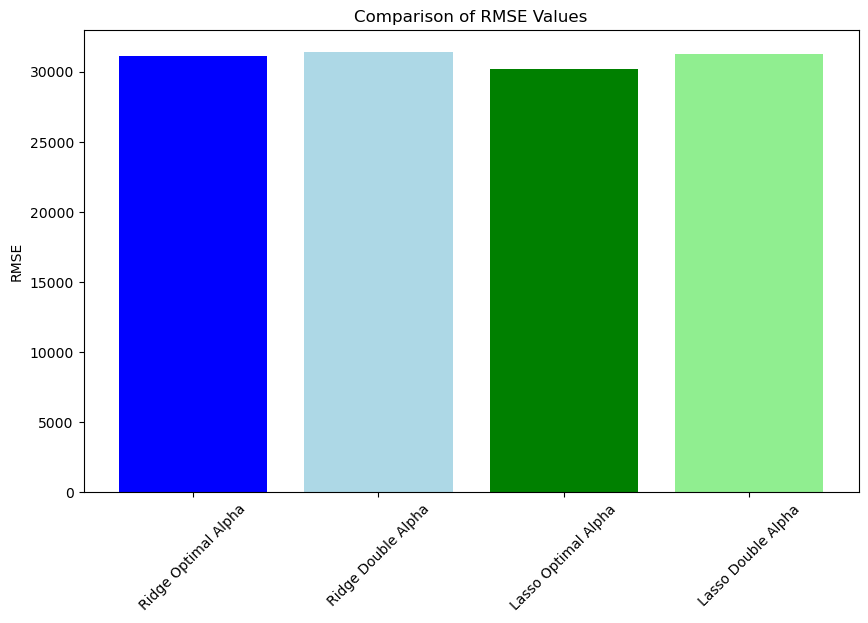

In [27]:
# Assuming RMSE values are calculated and stored in variables as mentioned above
rmse_values = {
    'Ridge Optimal Alpha': rmse_ridge_optimal,
    'Ridge Double Alpha': rmse_ridge_double,
    'Lasso Optimal Alpha': rmse_lasso_optimal,
    'Lasso Double Alpha': rmse_lasso_double
}

# Plotting RMSE values for visual comparison
plt.figure(figsize=(10, 6))
plt.bar(rmse_values.keys(), rmse_values.values(), color=['blue', 'lightblue', 'green', 'lightgreen'])
plt.ylabel('RMSE')
plt.title('Comparison of RMSE Values')
plt.xticks(rotation=45)
plt.show()

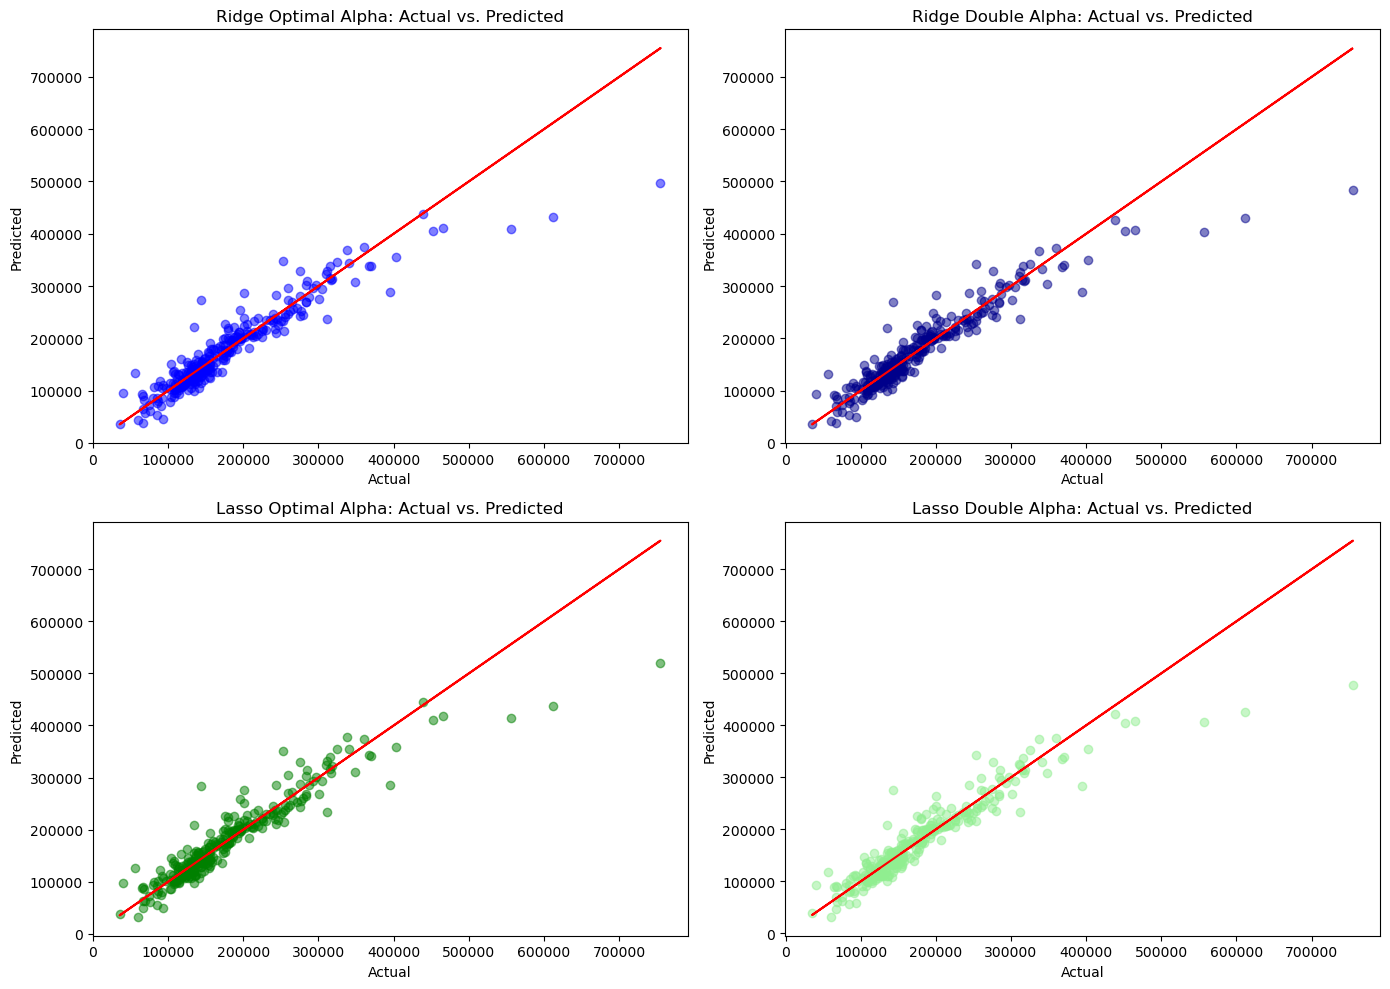

In [28]:

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot for Ridge with Optimal Alpha
axs[0, 0].scatter(y_test, y_pred_ridge_optimal, color='blue', alpha=0.5)
axs[0, 0].plot(y_test, y_test, color='red')  # Line for perfect predictions
axs[0, 0].set_title('Ridge Optimal Alpha: Actual vs. Predicted')
axs[0, 0].set_xlabel('Actual')
axs[0, 0].set_ylabel('Predicted')

# Plot for Ridge with Double Alpha
axs[0, 1].scatter(y_test, y_pred_ridge_double, color='darkblue', alpha=0.5)
axs[0, 1].plot(y_test, y_test, color='red')
axs[0, 1].set_title('Ridge Double Alpha: Actual vs. Predicted')
axs[0, 1].set_xlabel('Actual')
axs[0, 1].set_ylabel('Predicted')

# Plot for Lasso with Optimal Alpha
axs[1, 0].scatter(y_test, y_pred_lasso_optimal, color='green', alpha=0.5)
axs[1, 0].plot(y_test, y_test, color='red')
axs[1, 0].set_title('Lasso Optimal Alpha: Actual vs. Predicted')
axs[1, 0].set_xlabel('Actual')
axs[1, 0].set_ylabel('Predicted')

# Plot for Lasso with Double Alpha
axs[1, 1].scatter(y_test, y_pred_lasso_double, color='lightgreen', alpha=0.5)
axs[1, 1].plot(y_test, y_test, color='red')
axs[1, 1].set_title('Lasso Double Alpha: Actual vs. Predicted')
axs[1, 1].set_xlabel('Actual')
axs[1, 1].set_ylabel('Predicted')

plt.tight_layout()
plt.show()

Good Fit: For both Ridge and Lasso regressions, the actual and predicted prices generally line up along the red line (which represents perfect prediction). This suggests that both models are doing a good job of predicting house prices.

High-Value Predictions: In all four plots, there's a tendency for the predictions to be less accurate for higher-value homes. This is indicated by points that stray from the line as the actual values increase. It may suggest that the models could be improved for predicting the sale prices of more expensive houses.

Consistency in Performance: The similarity in the spread of points around the line for models with optimal and doubled alpha values suggests that changing the alpha parameter doesn't drastically change how well the models predict house prices.

Outliers and Variance: There are some points that are far from the line, especially in the higher price ranges, which indicates outliers or high variance in predictions for some homes. It might be beneficial to investigate why the models are not capturing these points well.

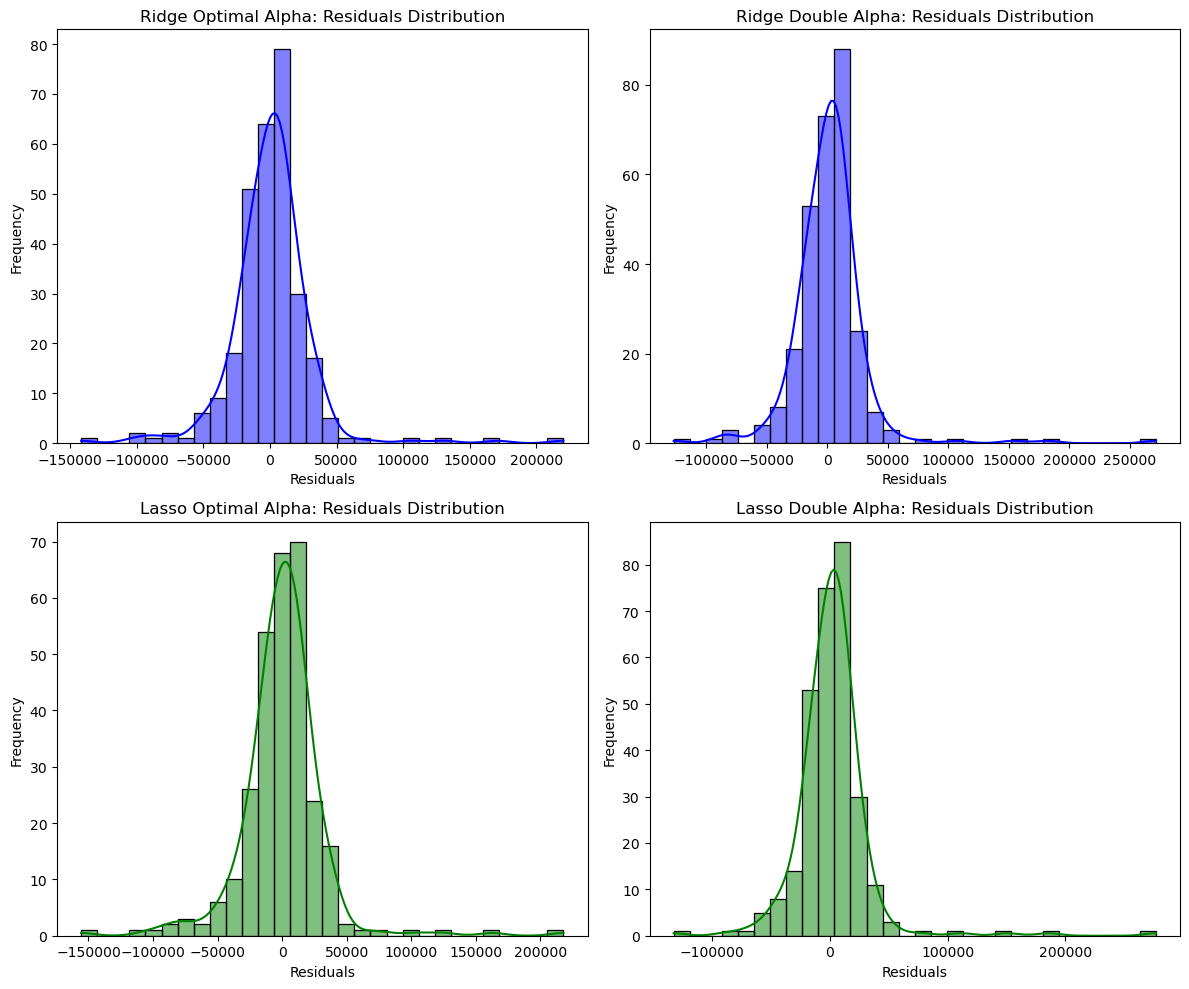

In [29]:
residuals_ridge_double = y_test - y_pred_ridge_double
residuals_lasso_double = y_test - y_pred_lasso_double

# Plotting histograms of residuals
plt.figure(figsize=(12, 10))

# Residuals for Ridge regression with optimal alpha
plt.subplot(2, 2, 1)
sns.histplot(residuals_ridge, kde=True, bins=30, color='blue')
plt.title('Ridge Optimal Alpha: Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Residuals for Ridge regression with double alpha
plt.subplot(2, 2, 2)
sns.histplot(residuals_ridge_double, kde=True, bins=30, color='blue')
plt.title('Ridge Double Alpha: Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Residuals for Lasso regression with optimal alpha
plt.subplot(2, 2, 3)
sns.histplot(residuals_lasso, kde=True, bins=30, color='green')
plt.title('Lasso Optimal Alpha: Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Residuals for Lasso regression with double alpha
plt.subplot(2, 2, 4)
sns.histplot(residuals_lasso_double, kde=True, bins=30, color='green')
plt.title('Lasso Double Alpha: Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Centered Residuals: For both types of models, Ridge and Lasso, the differences between the predicted house prices and the actual sale prices (what we call residuals) seem to hover around the zero mark. This tells us that the models aren't regularly guessing too high or too low—they're about right on average.

Resembling a Bell Curve: When looking at how often the residuals occur at different amounts, the pattern looks a lot like a bell curve, which is exactly what we want to see. It suggests the models are working as they should, although there are a few exceptions where the errors are bigger than we'd expect. Those could be due to unusual cases or perhaps something that's not quite right in the model.

Spread of Errors: There's a noticeable range in the size of the errors—some are small, but some are pretty big. These big errors hint that the model's predictions for certain houses are way off from their actual selling prices. It would be helpful to look more into why these big errors are happening.